# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**Group delivery**

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we use a network with softmax output.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from viewer import Viewer

In [2]:
# create gym environment
env = gym.make('CartPole-v0')

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [3]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [-0.00351377  0.04454608  0.04241274  0.03688757]
sample action: 0


Let us see how the environment looks when we just take random actions.

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



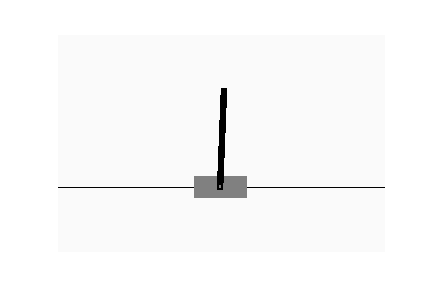
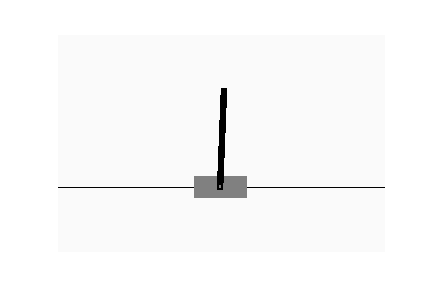
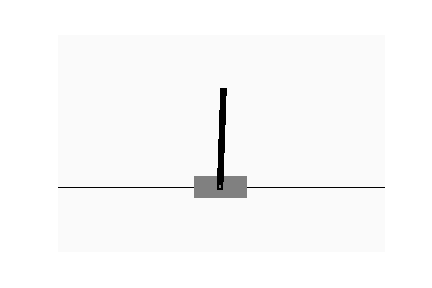
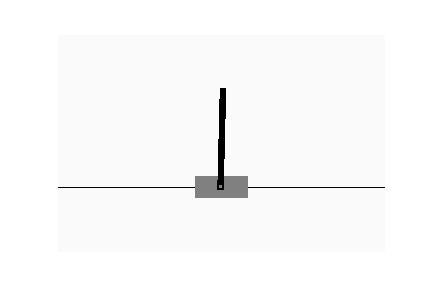
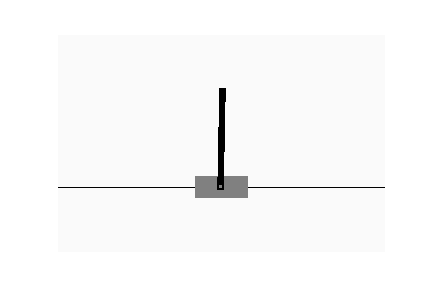
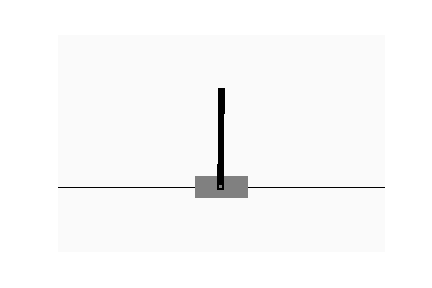
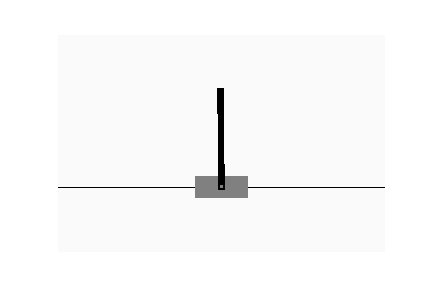
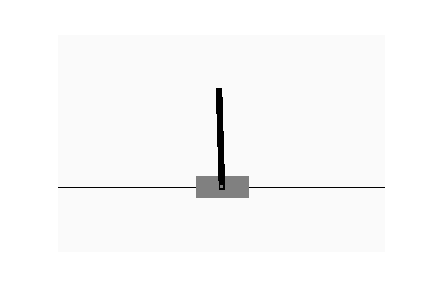
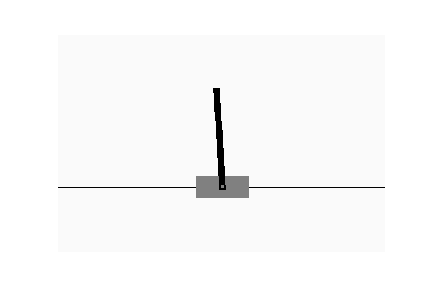
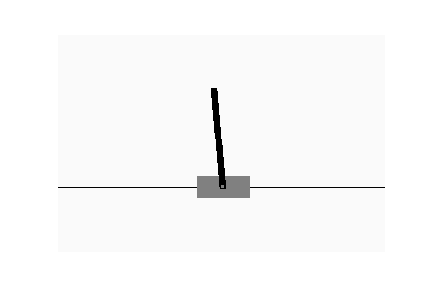
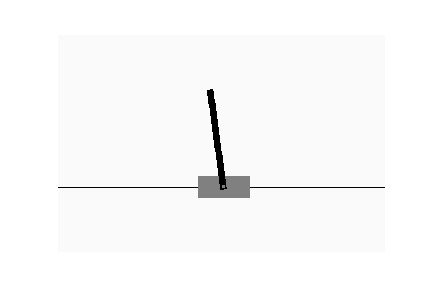
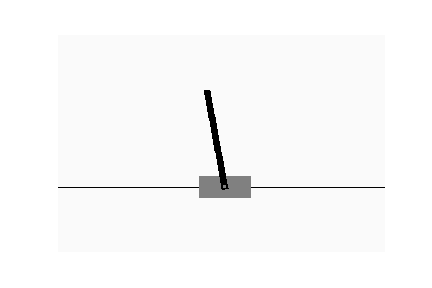
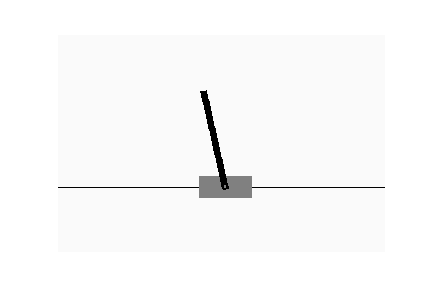
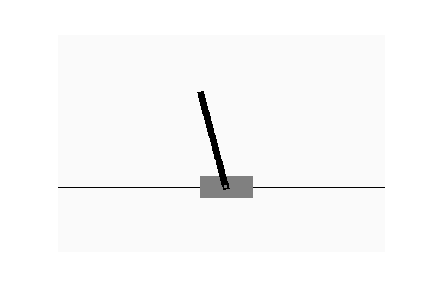
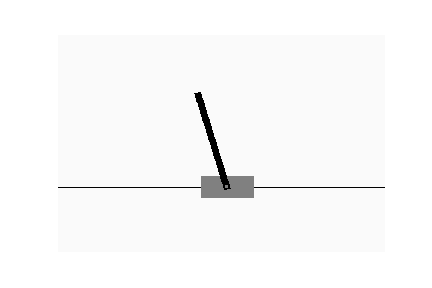
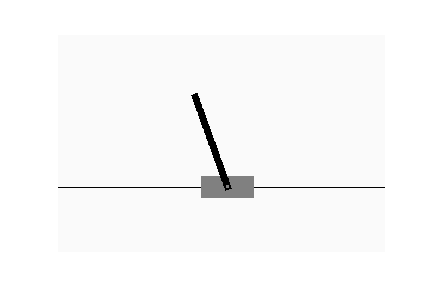
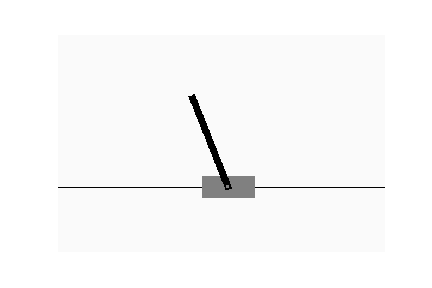
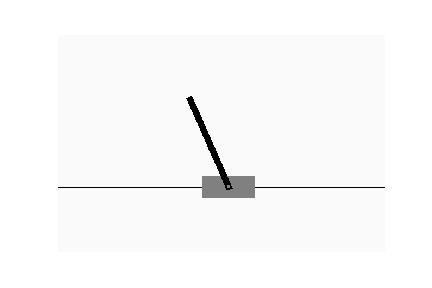
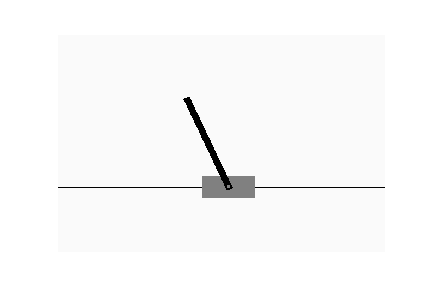
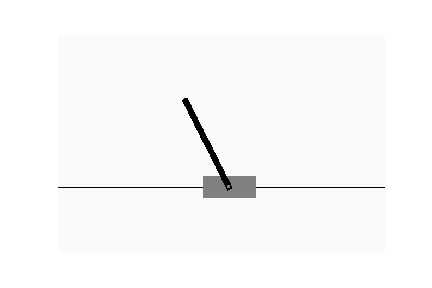
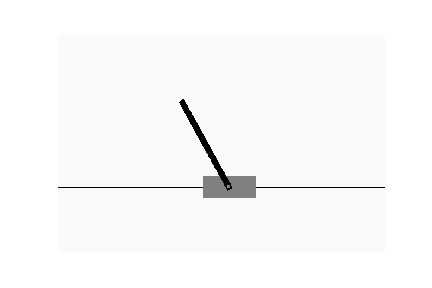
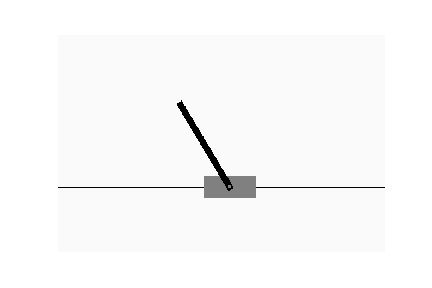
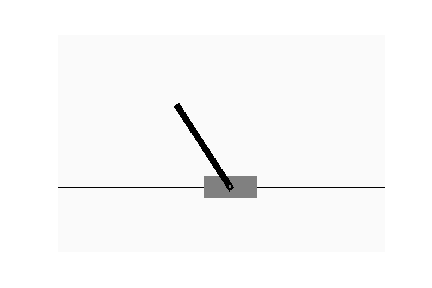
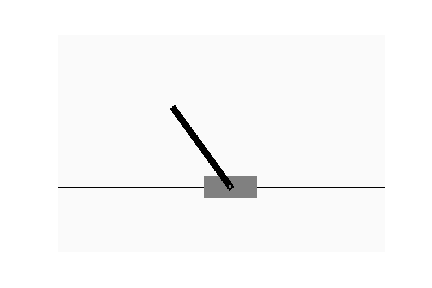
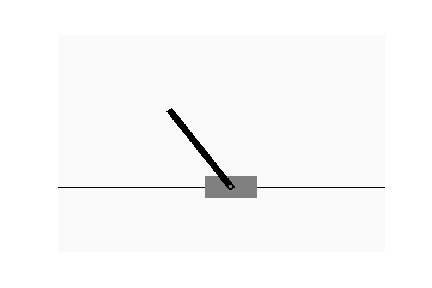
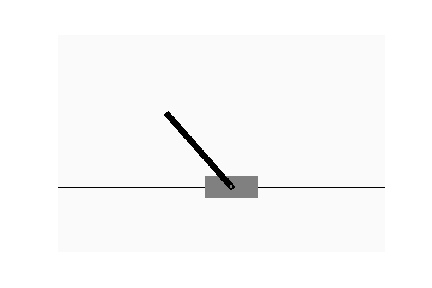
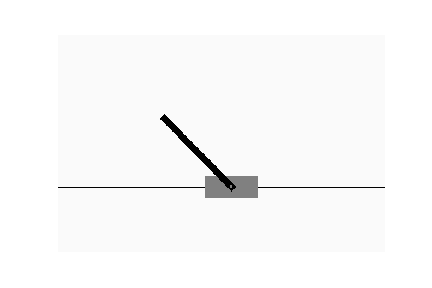
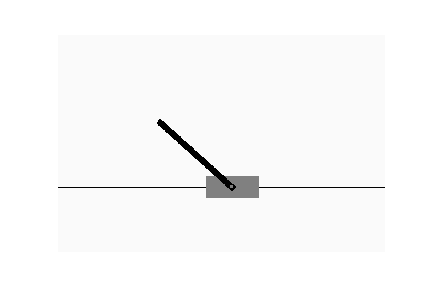
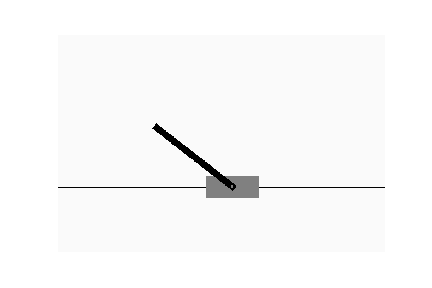
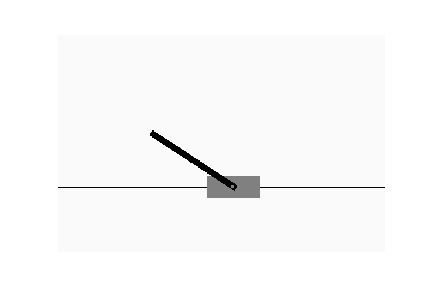
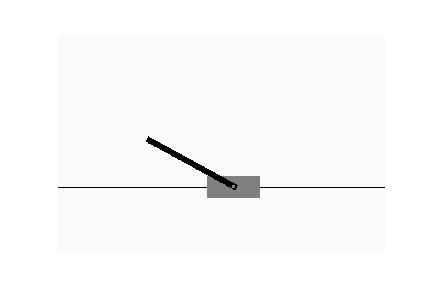
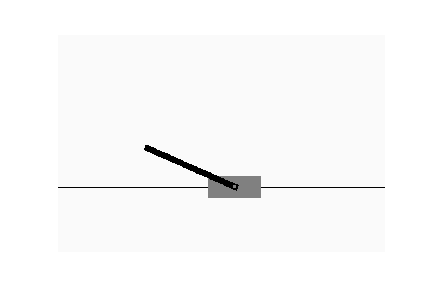
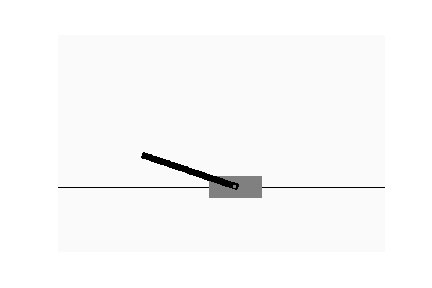
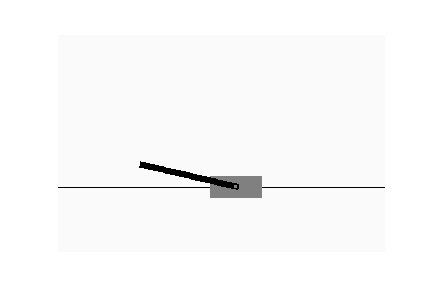
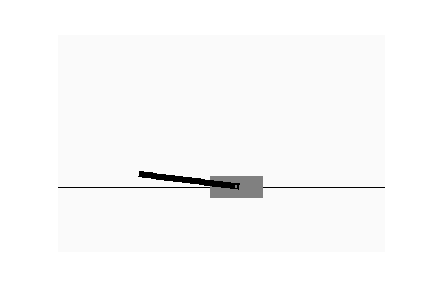
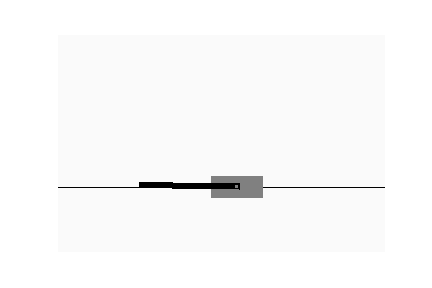
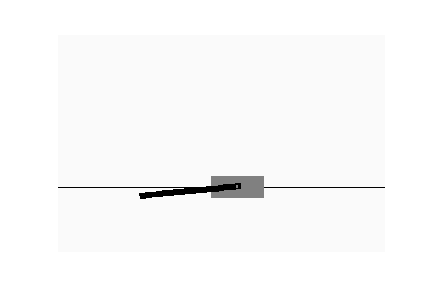
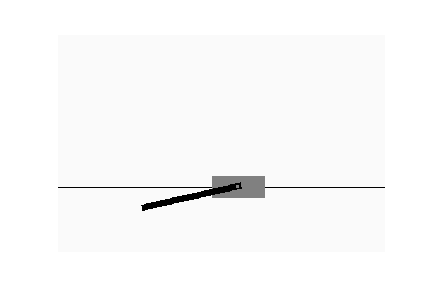
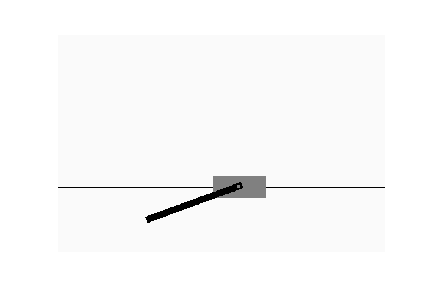
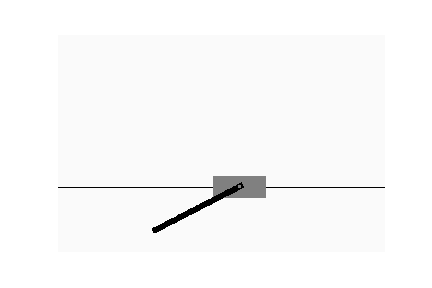
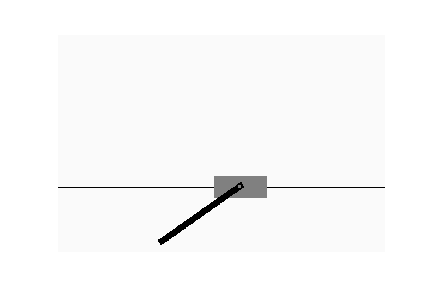
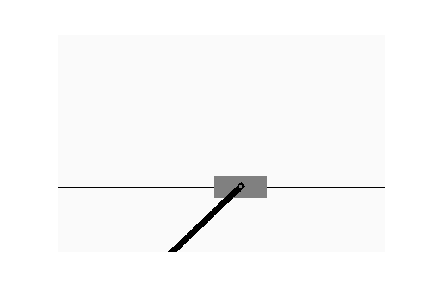
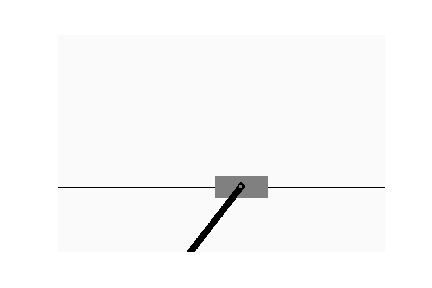
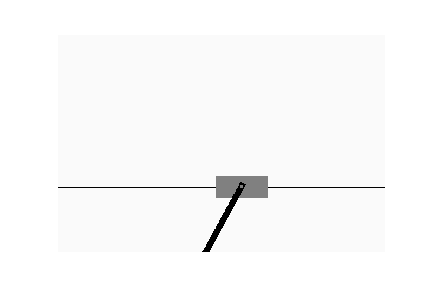
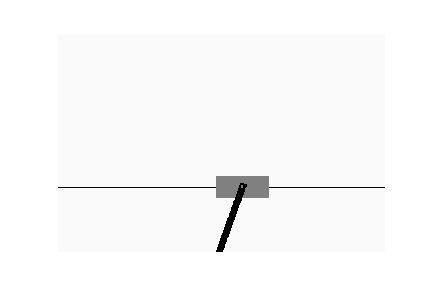
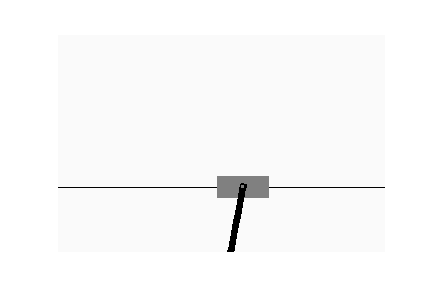
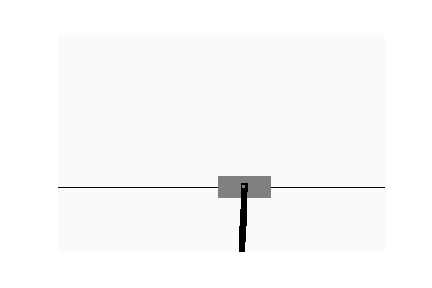
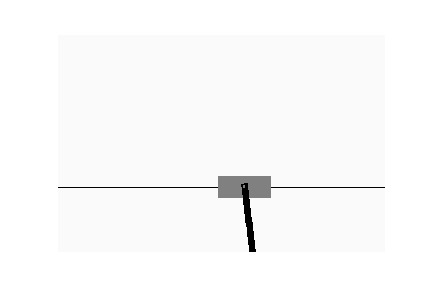
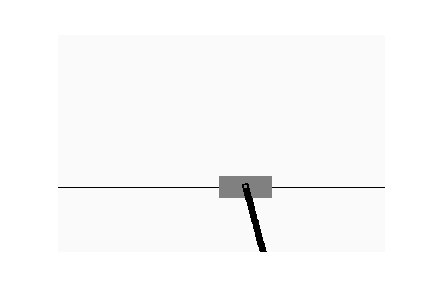
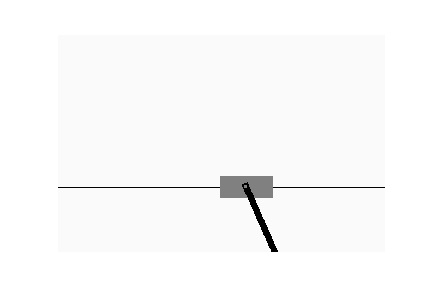
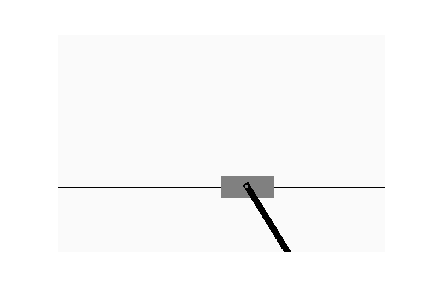
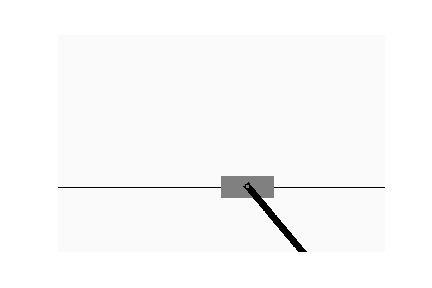
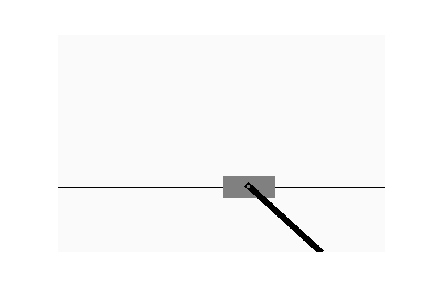
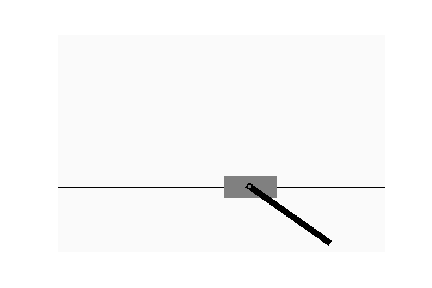
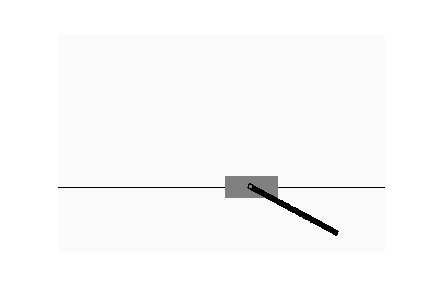
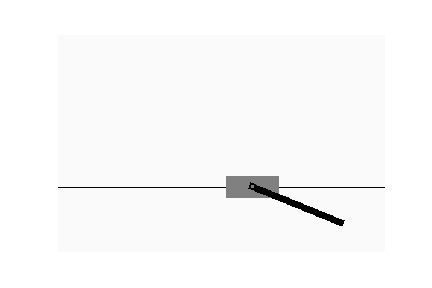
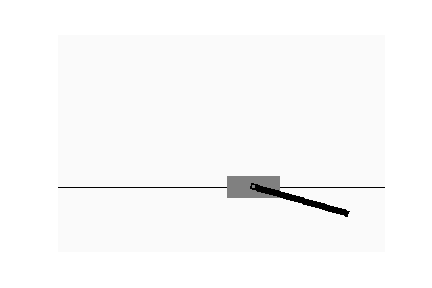
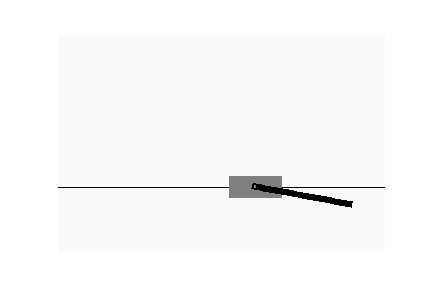
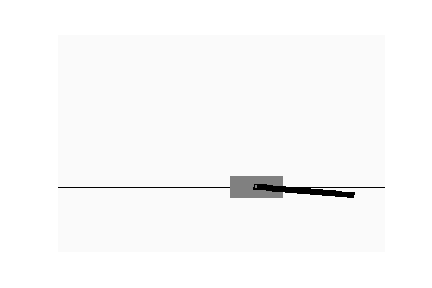
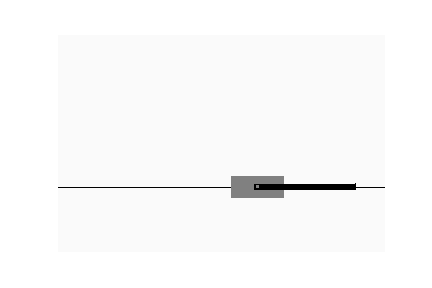
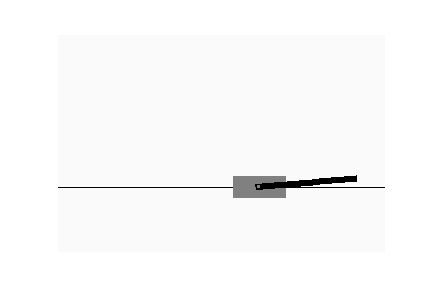
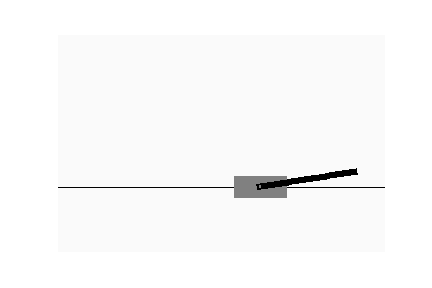
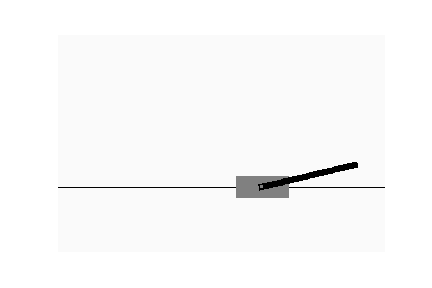
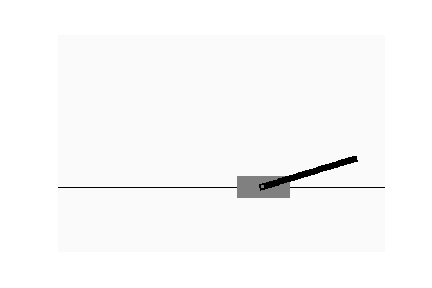
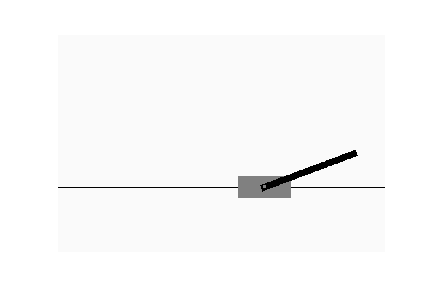
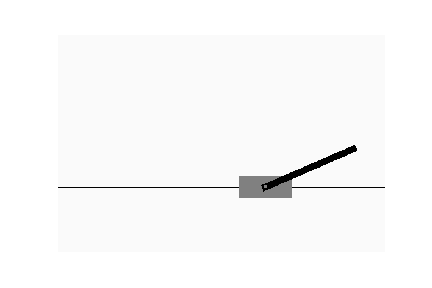
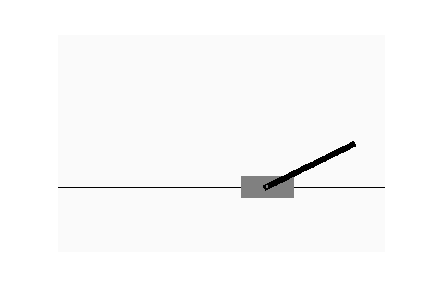
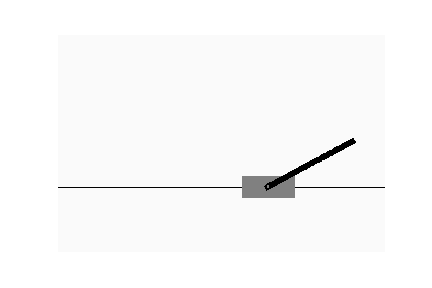
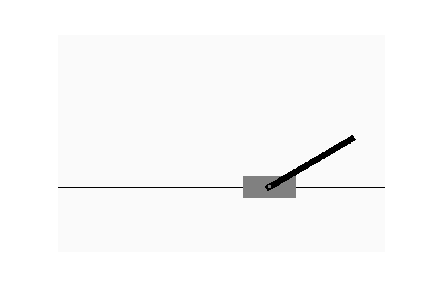
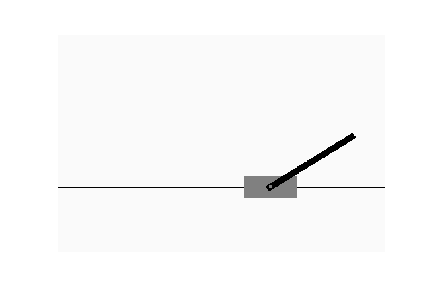
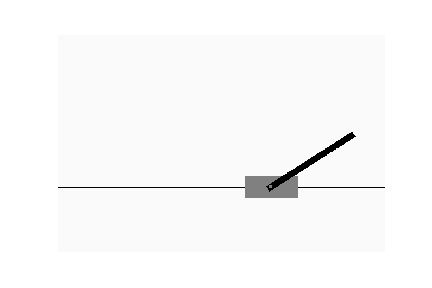
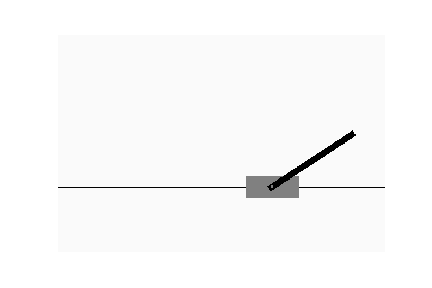
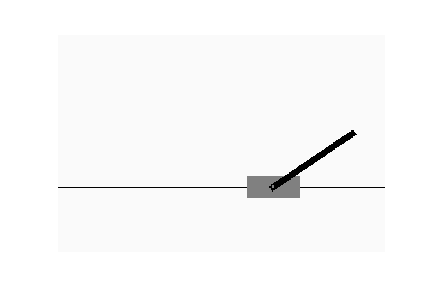
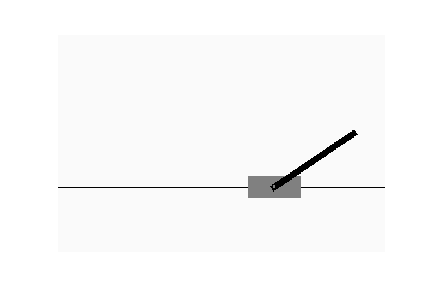
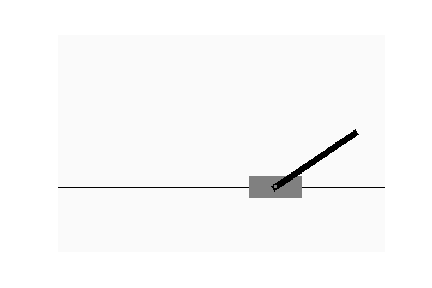
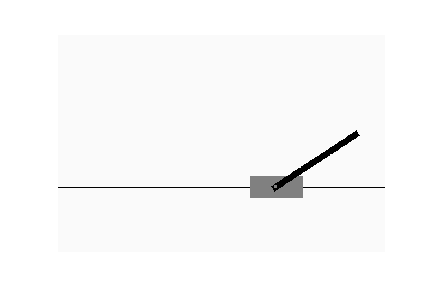
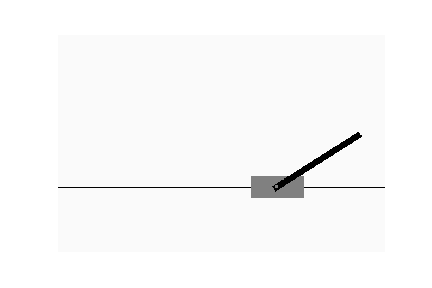
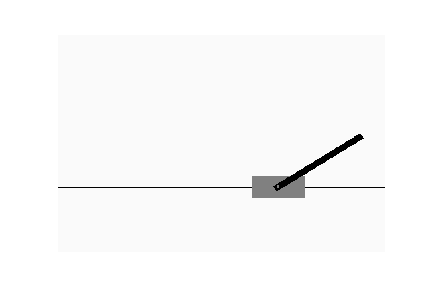
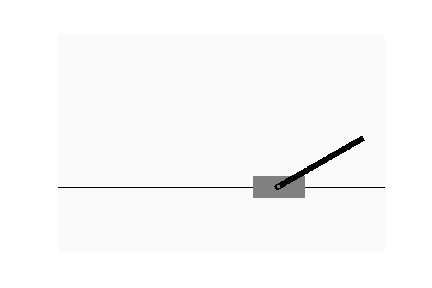
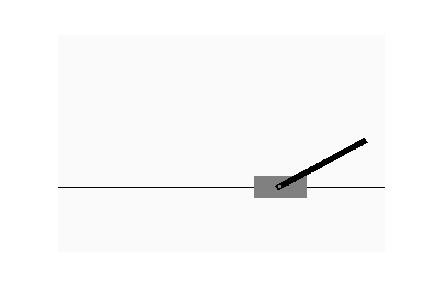
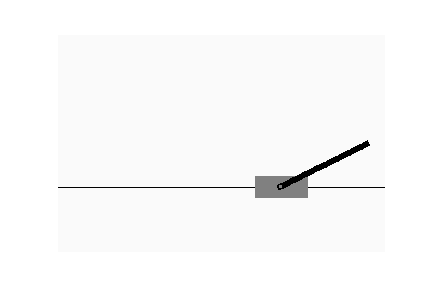
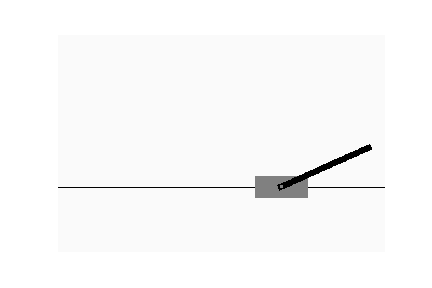
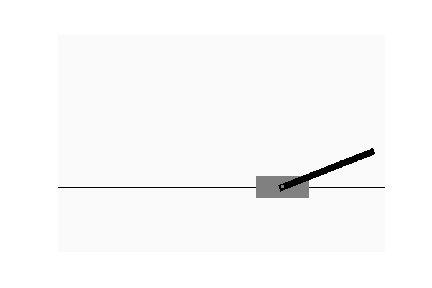
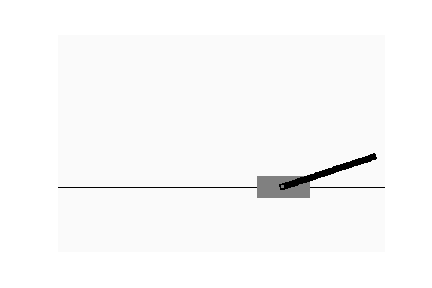
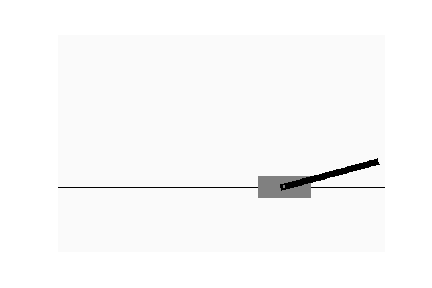
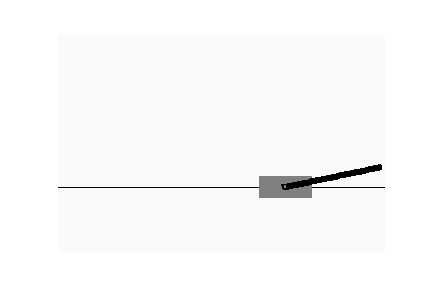
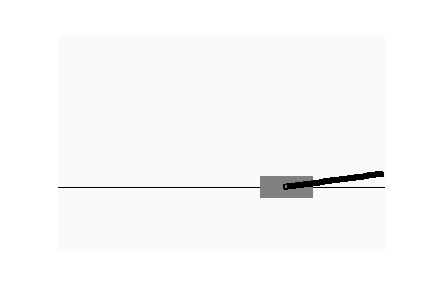
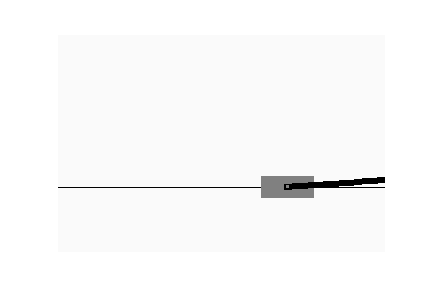
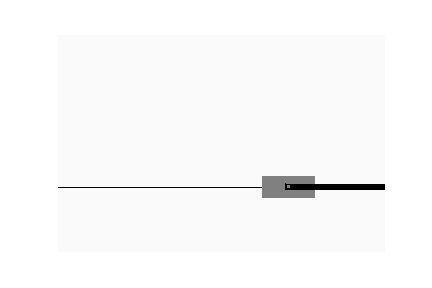
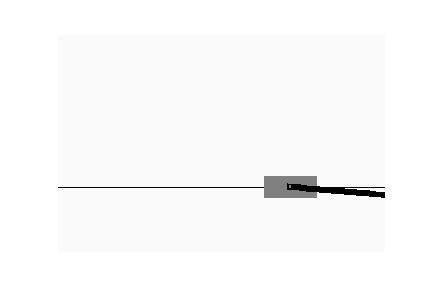
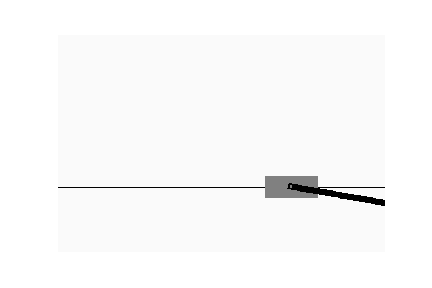
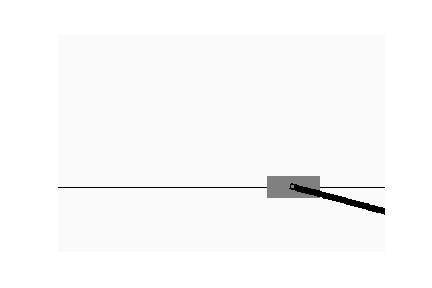
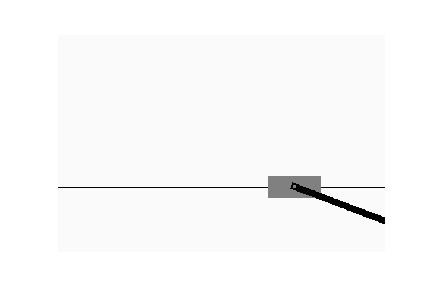
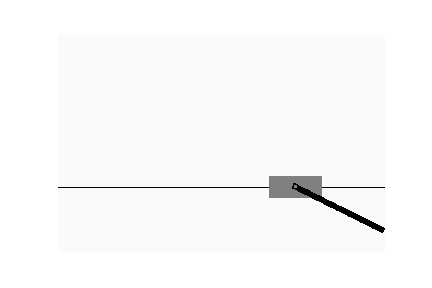
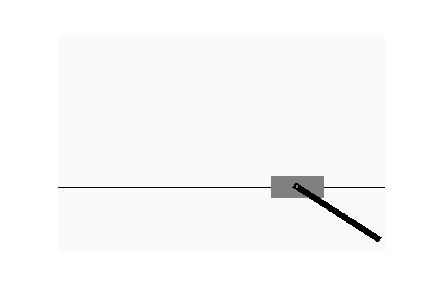
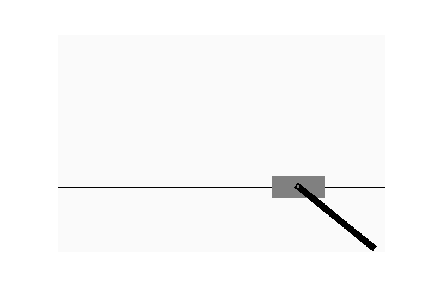
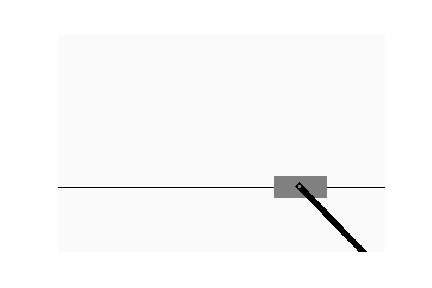
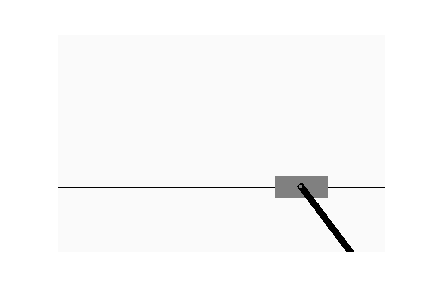
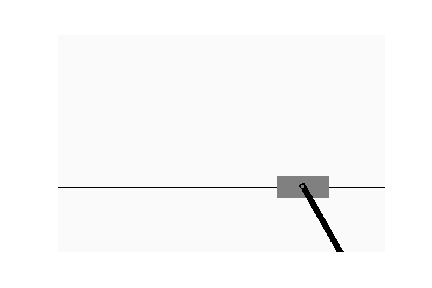
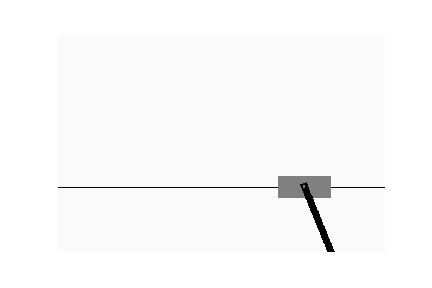
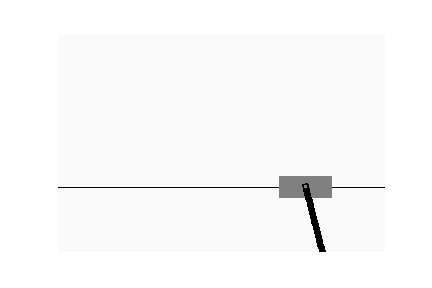
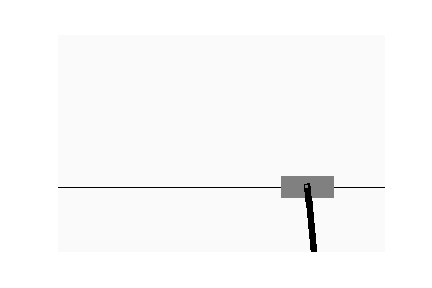
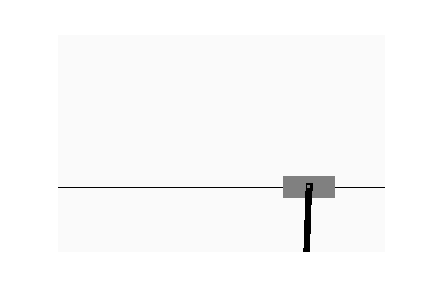
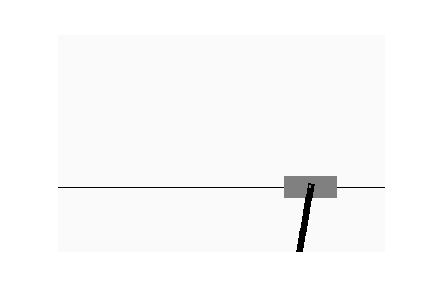
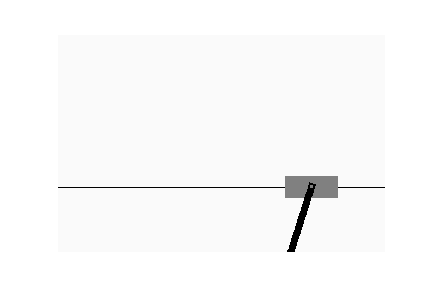
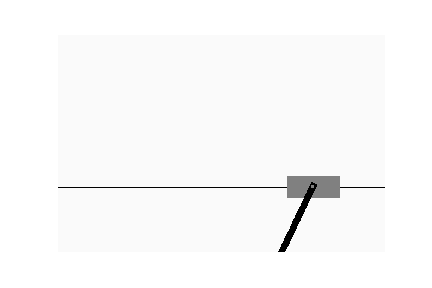
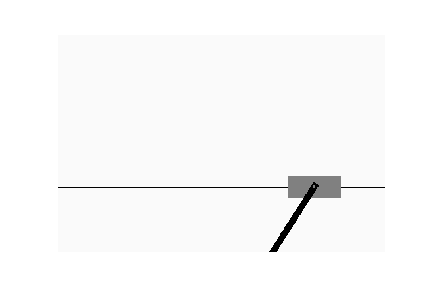
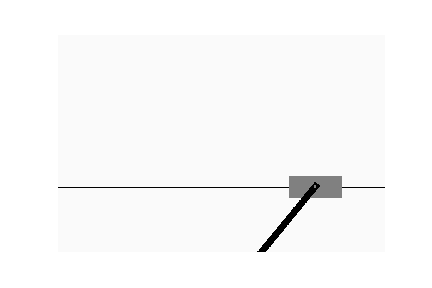
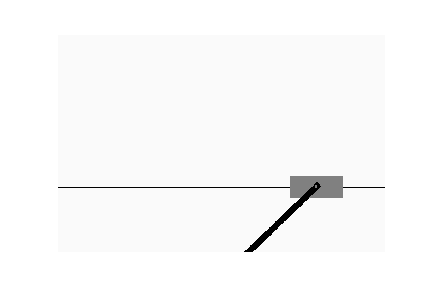
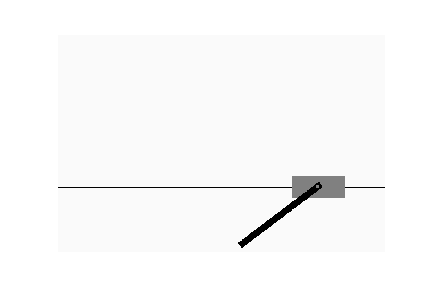
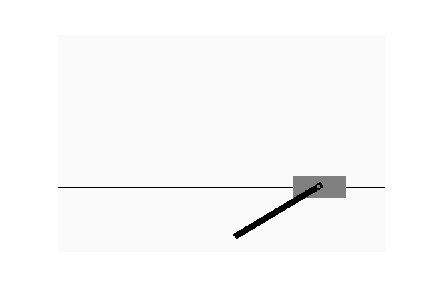
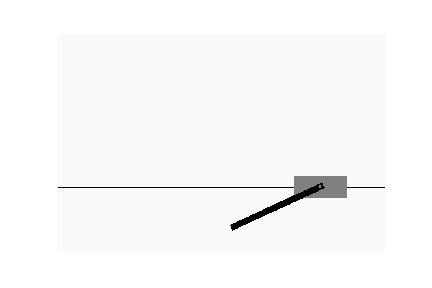
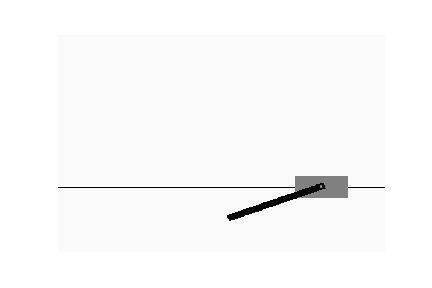
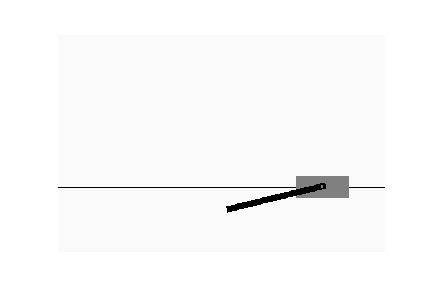
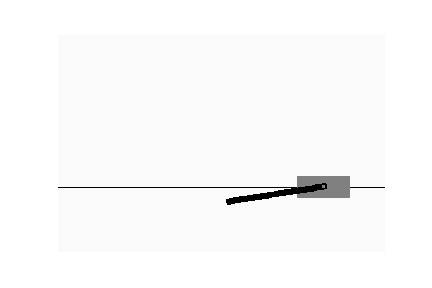
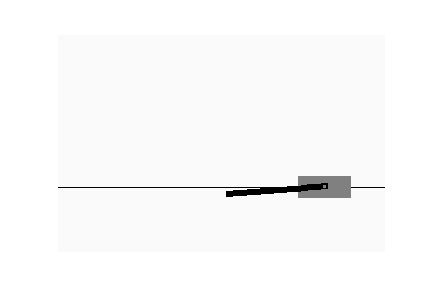
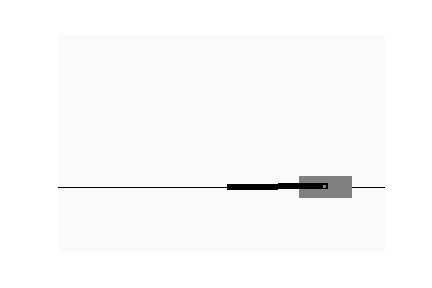
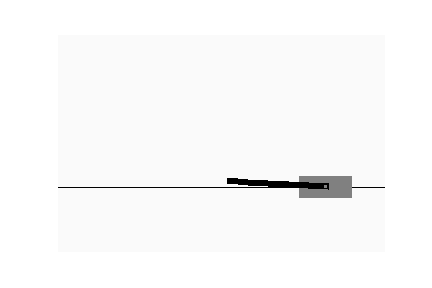
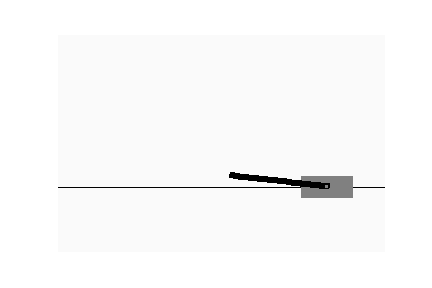
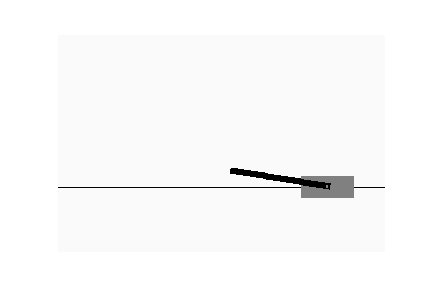
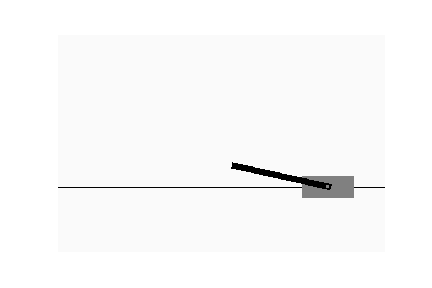
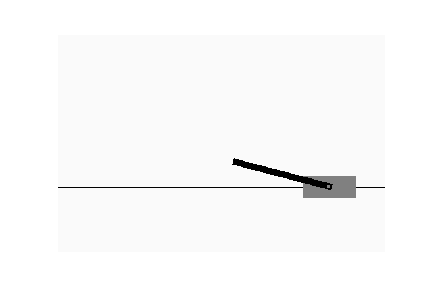
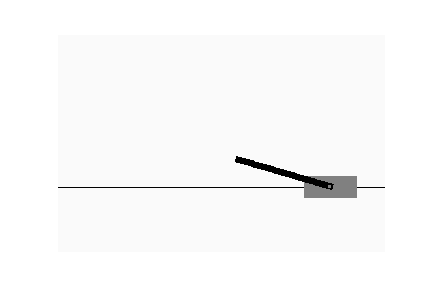
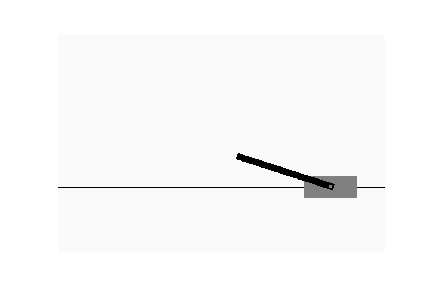
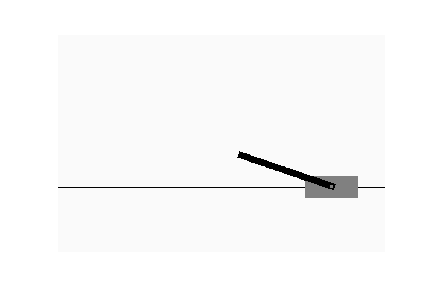
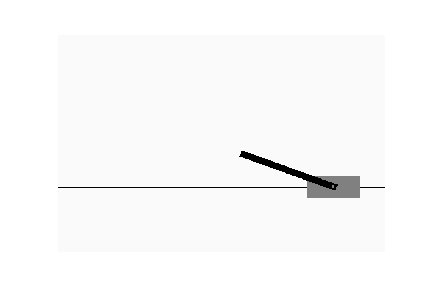
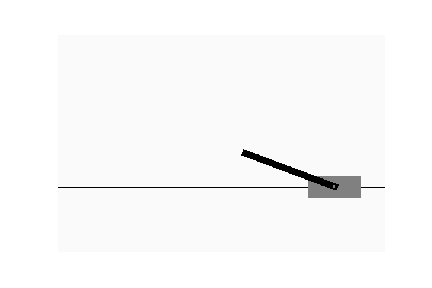
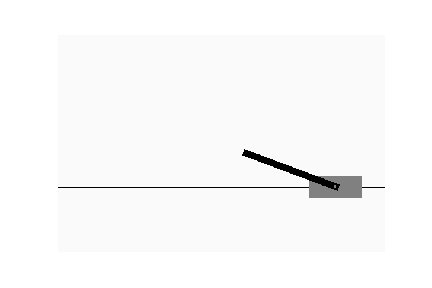
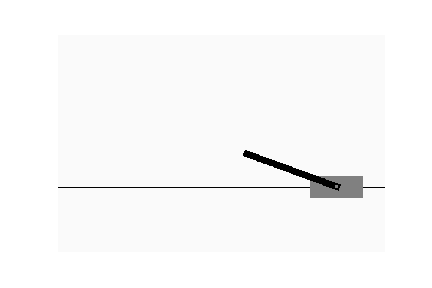
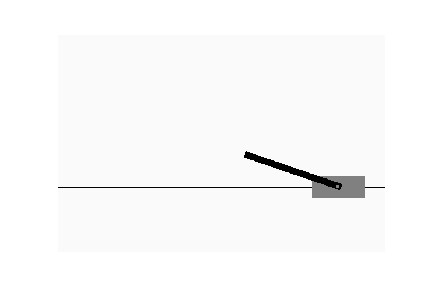
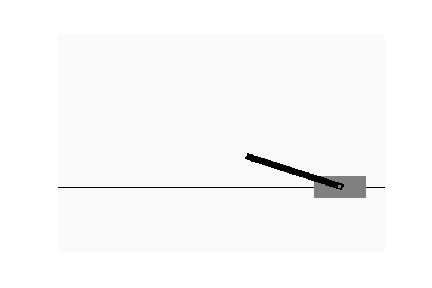
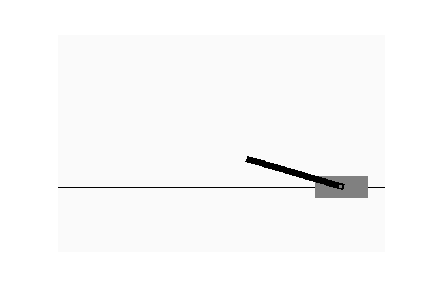
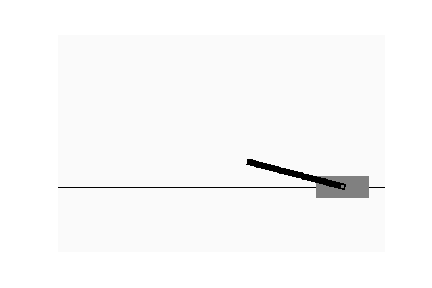
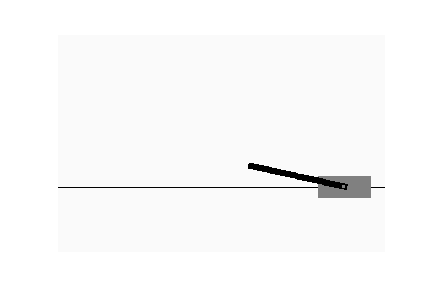
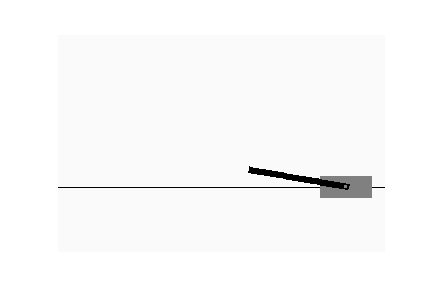
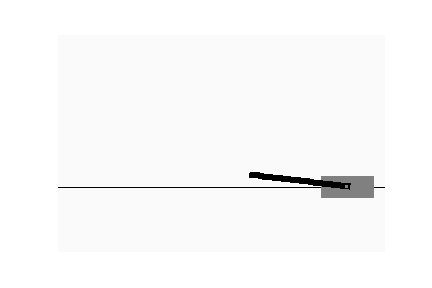
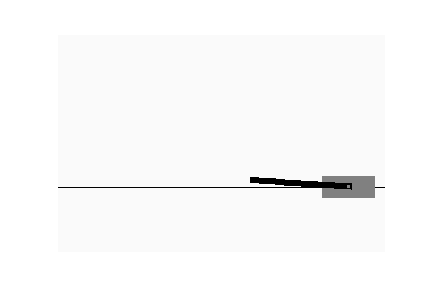
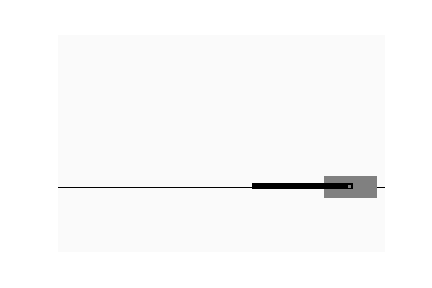
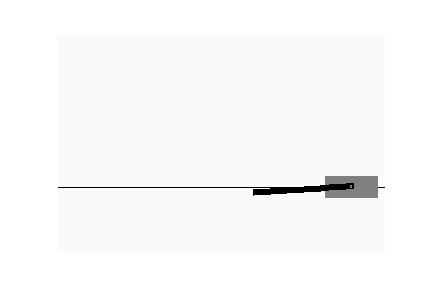
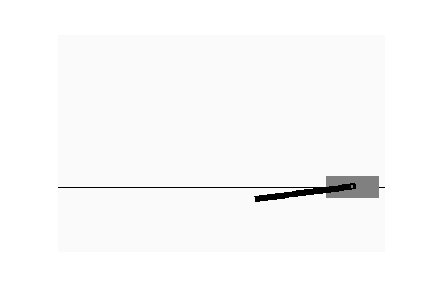
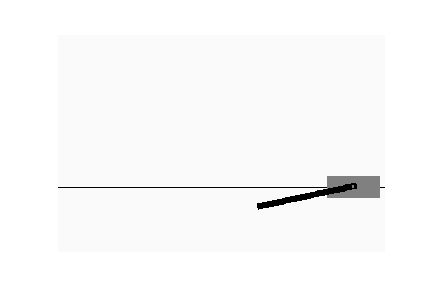
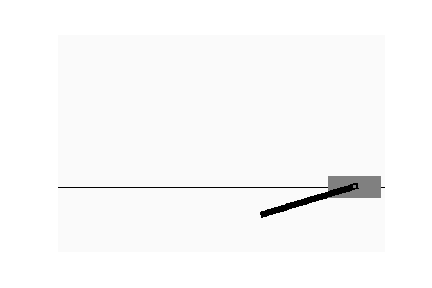
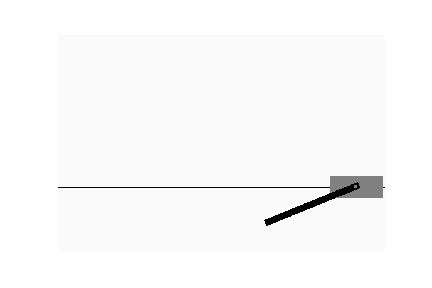
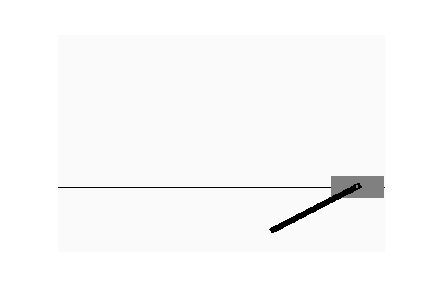
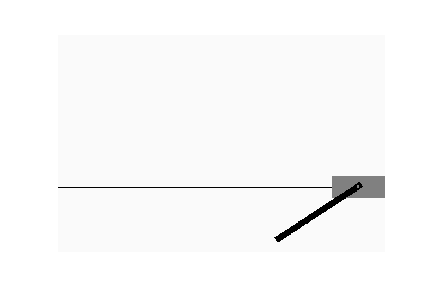
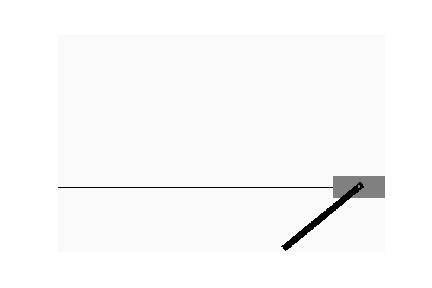
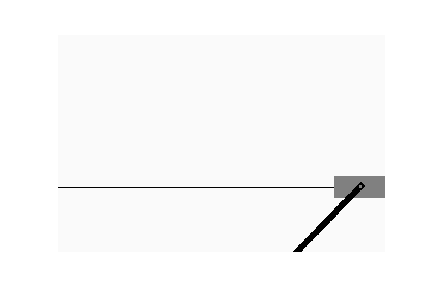
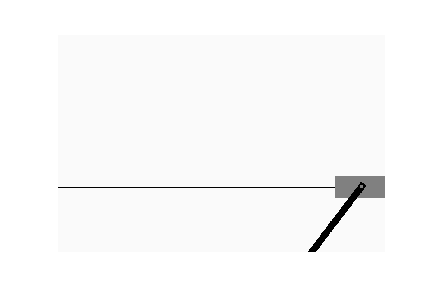
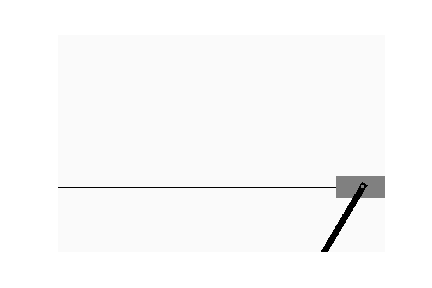
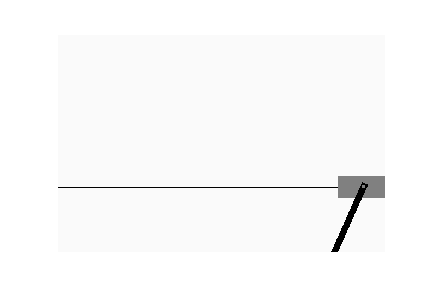
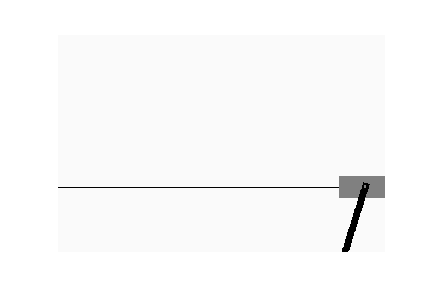
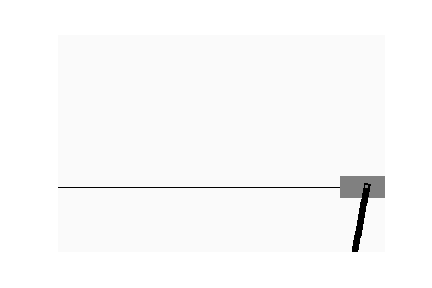
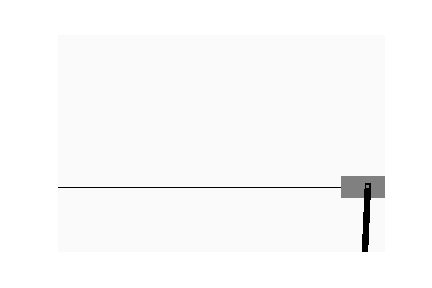
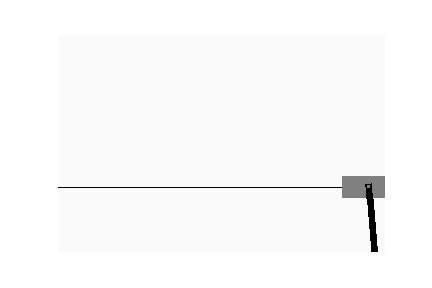
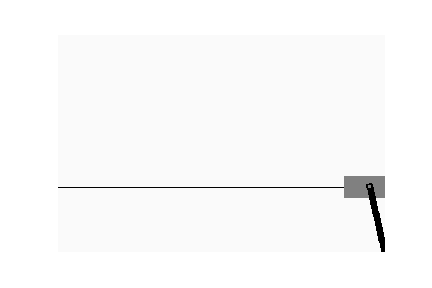
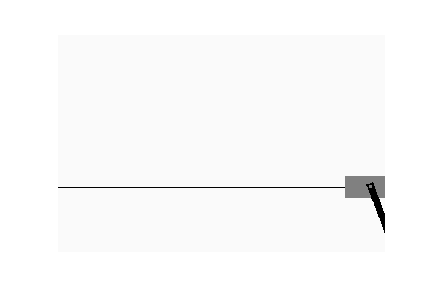
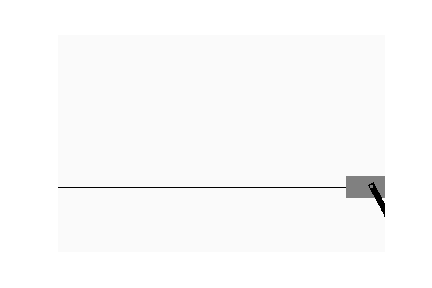
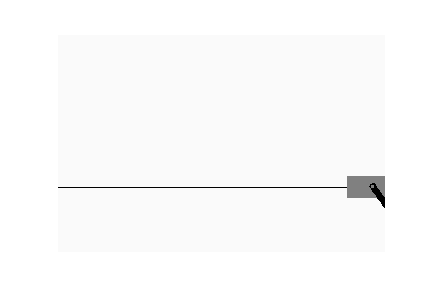
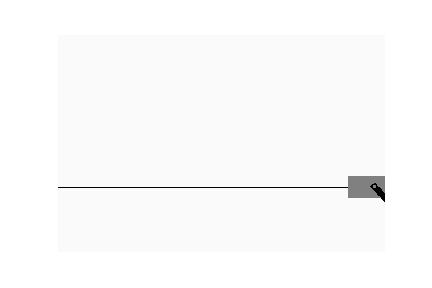
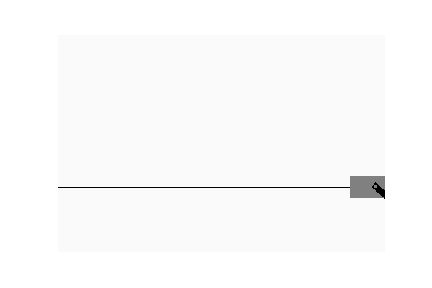
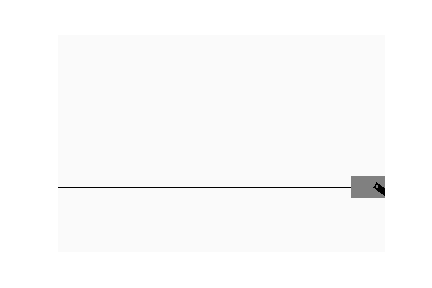
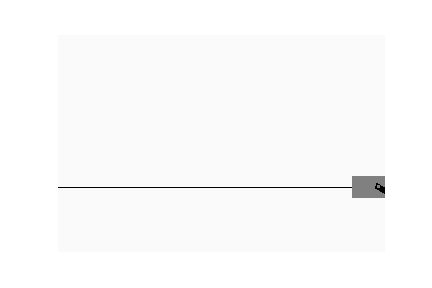
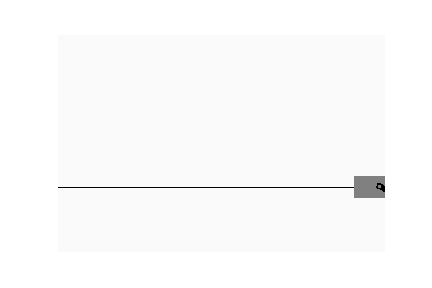
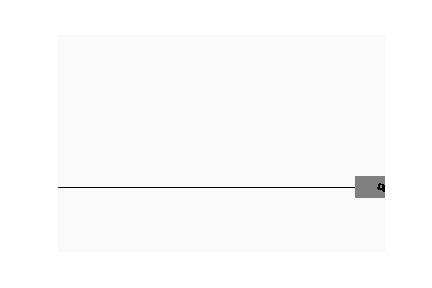
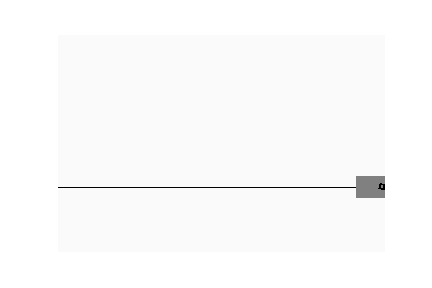
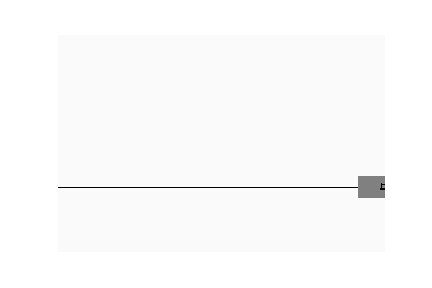
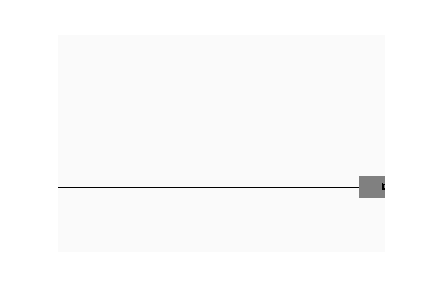
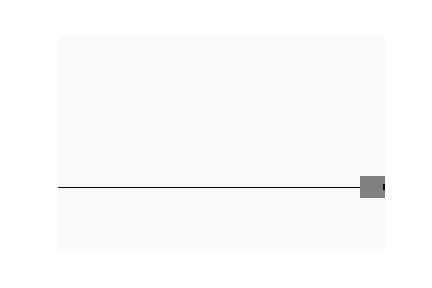
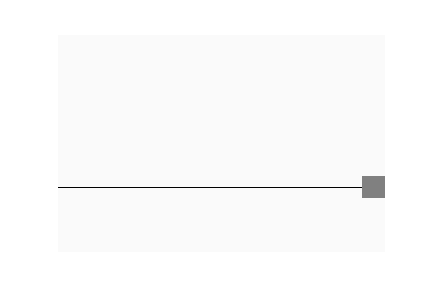
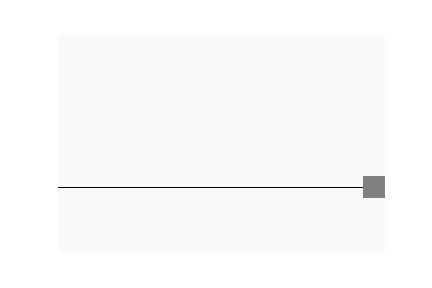
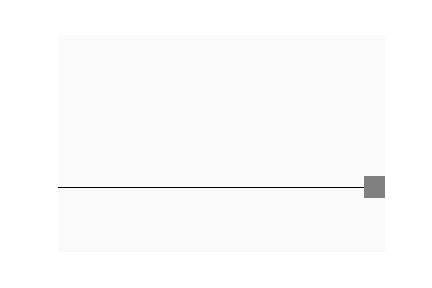
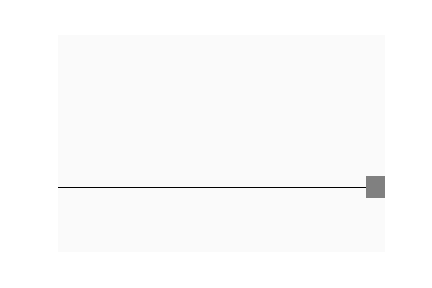
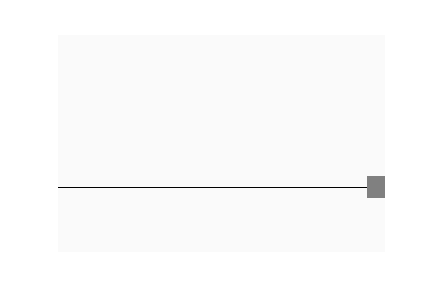
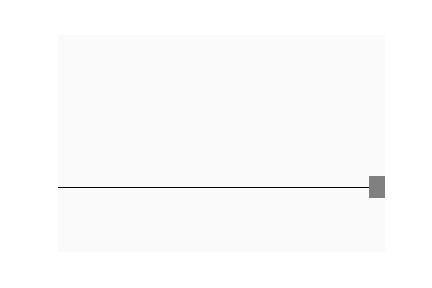
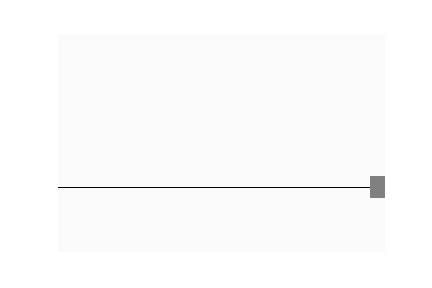
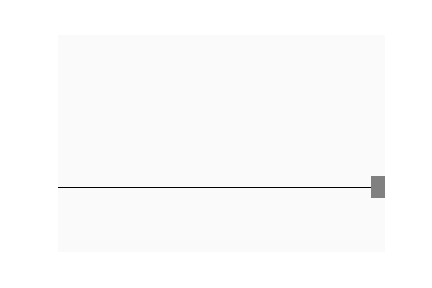
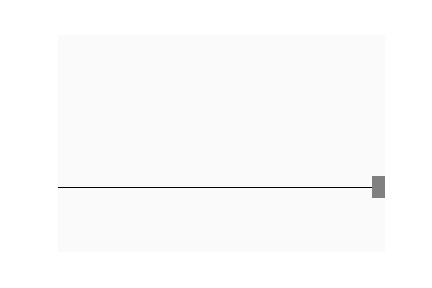
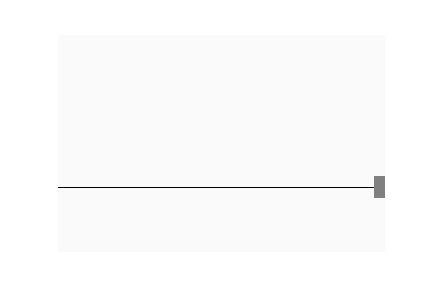
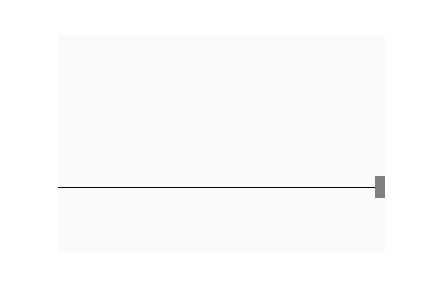
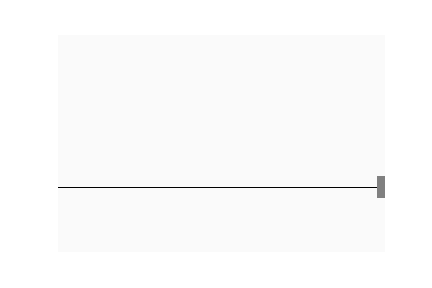
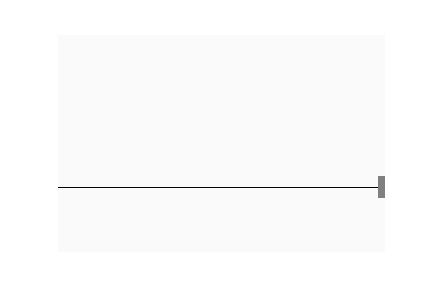
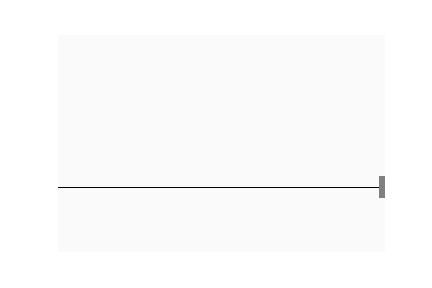
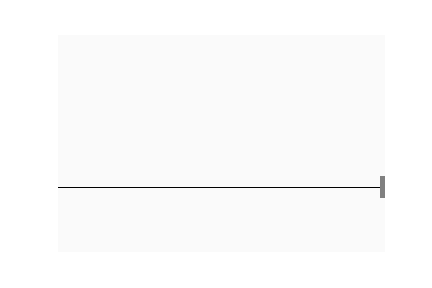
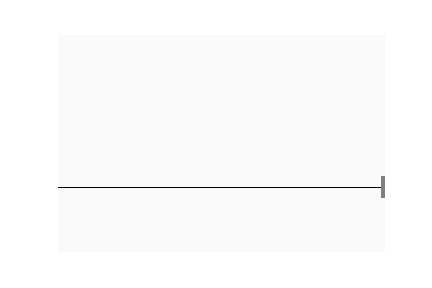
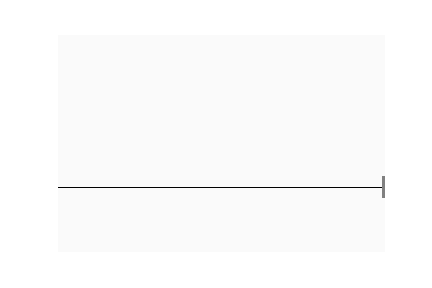
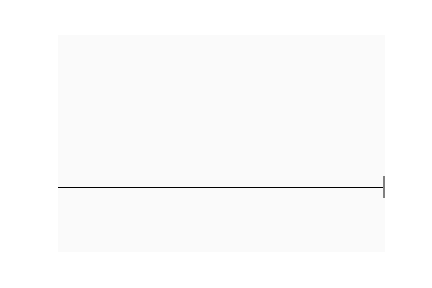
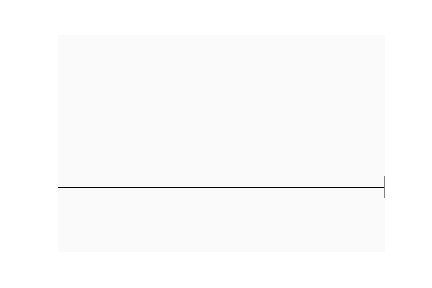
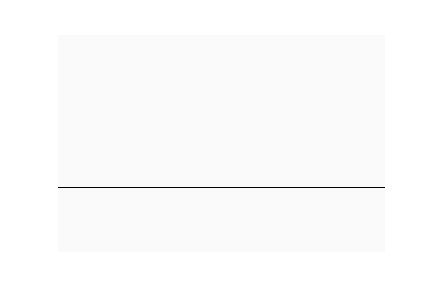
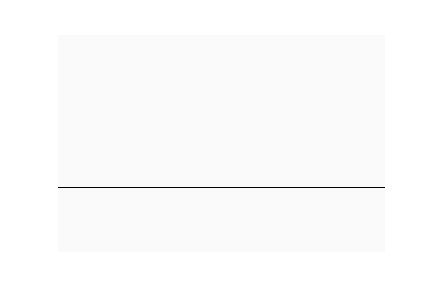
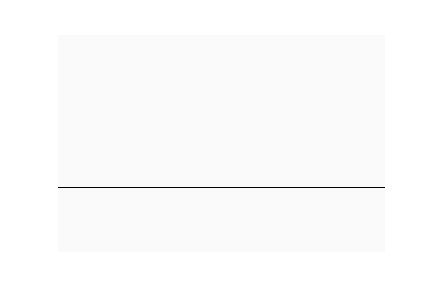
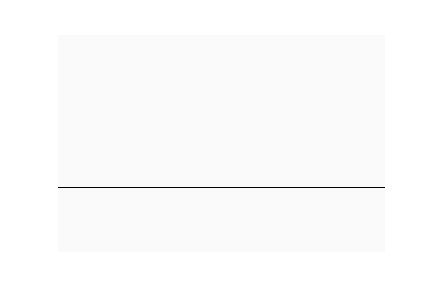
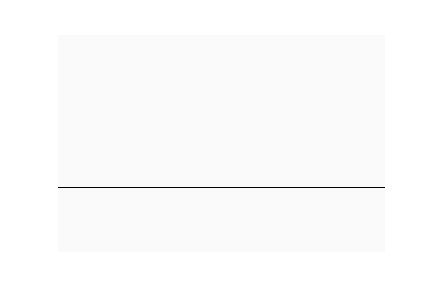
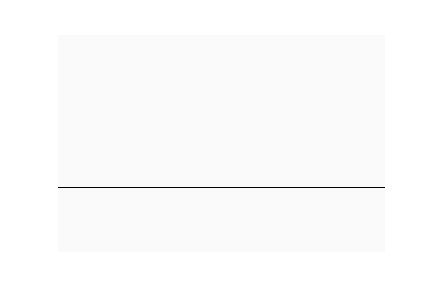
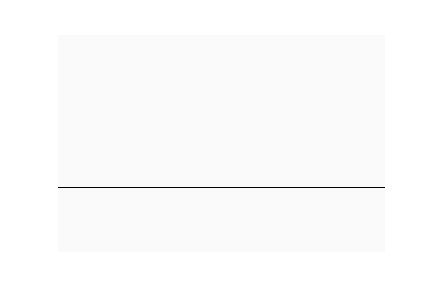
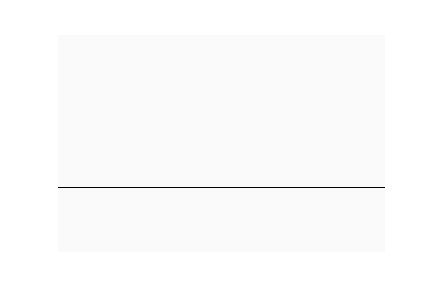
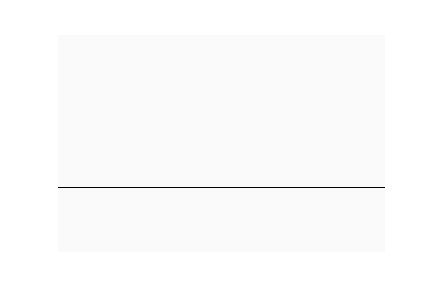
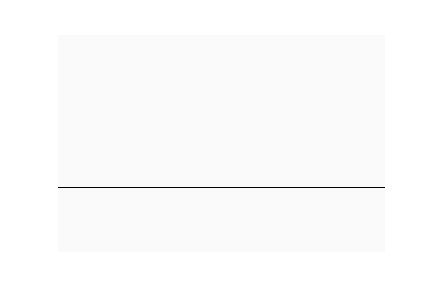
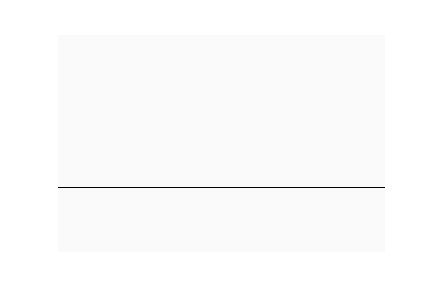
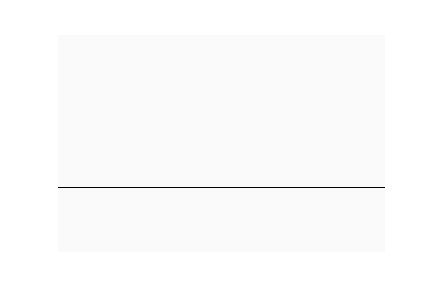
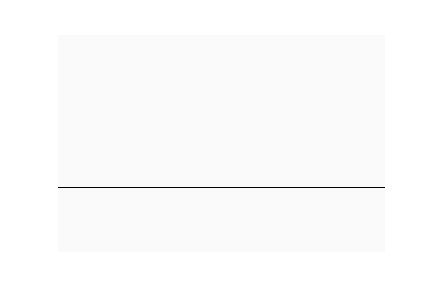

In [4]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render() # display the environment inline in the notebook
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [21]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [22]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [23]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [55]:
# training settings

num_episodes = 2000
rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 1.05 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.003 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  28.32, mean validation reward: 112.60, mean loss: 43.3131
 200. mean training reward:  42.78, mean validation reward: 150.00, mean loss: 73.8864
 300. mean training reward: 105.90, mean validation reward: 200.00, mean loss: 4627.1414
 400. mean training reward: 136.11, mean validation reward: 137.00, mean loss: 6351.6107
 500. mean training reward: 122.02, mean validation reward: 162.10, mean loss: 4211.9318
 600. mean training reward: 163.50, mean validation reward: 200.00, mean loss: 11032.4902
 700. mean training reward: 187.15, mean validation reward: 200.00, mean loss: 16842.1867
 800. mean training reward: 199.75, mean validation reward: 200.00, mean loss: 20769.2890
 900. mean training reward: 198.60, mean validation reward: 200.00, mean loss: 20158.4398
1000. mean training reward: 195.63, mean validation reward: 200.00, mean loss: 17268.5164
1100. mean training reward: 195.65, mean validation reward: 199.90, mean loss: 17153.9642
1200

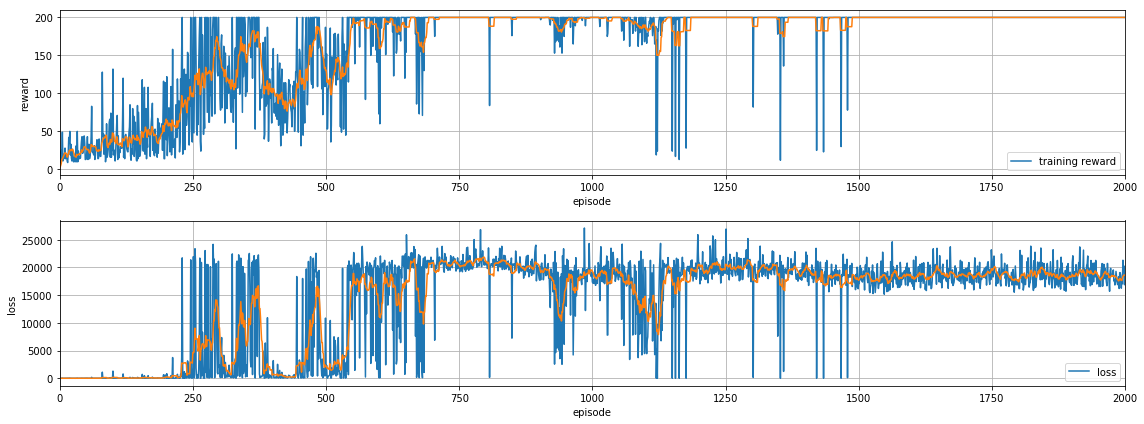

In [56]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()


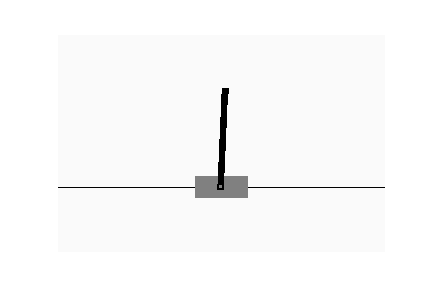
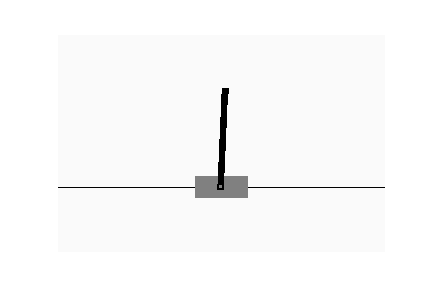
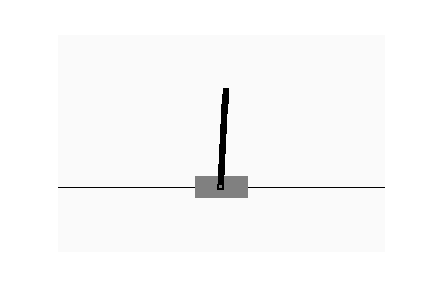
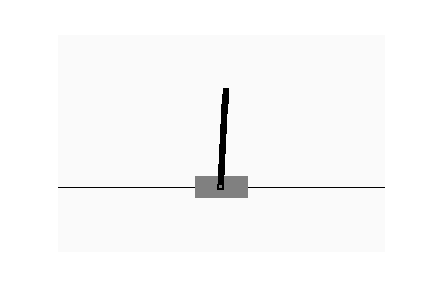
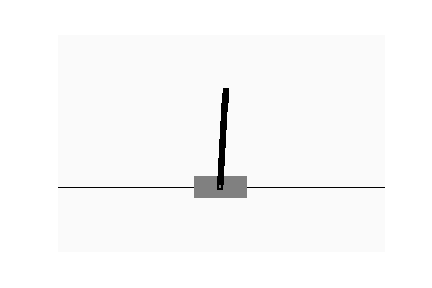
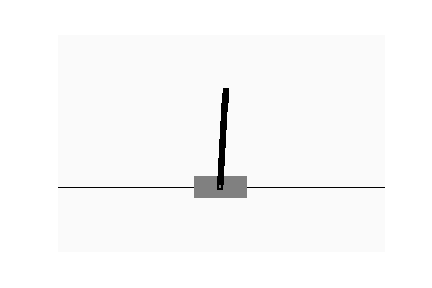
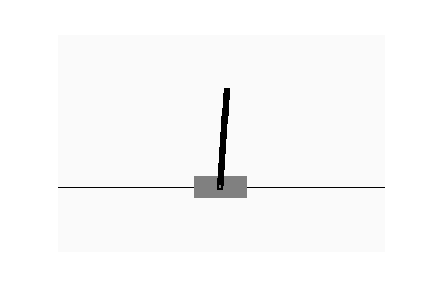
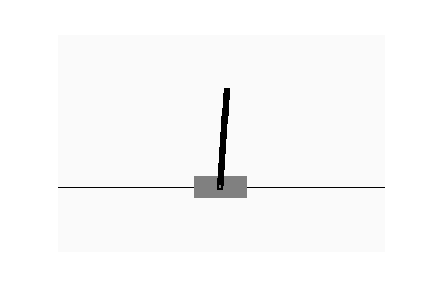
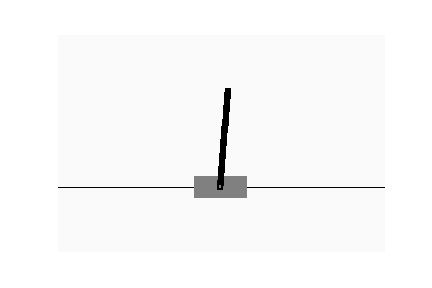
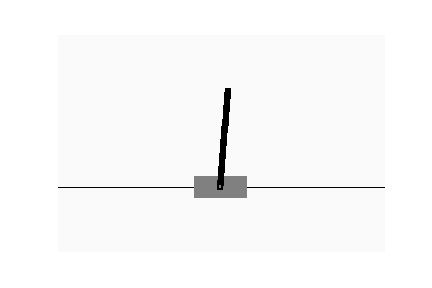
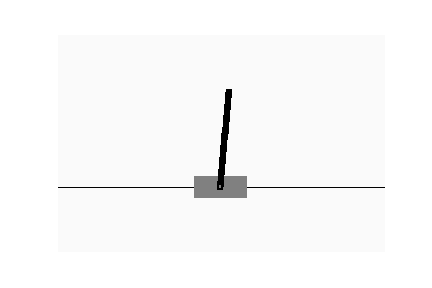
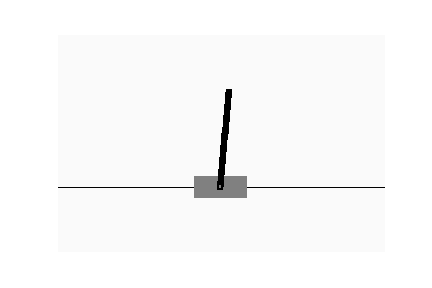
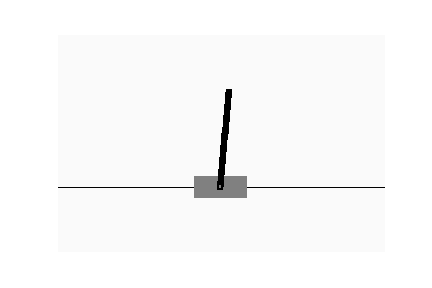
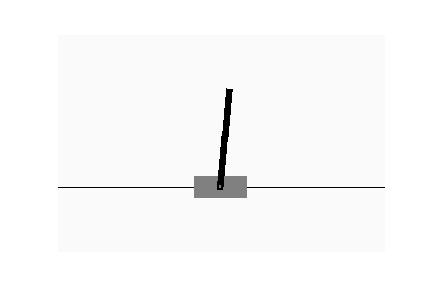
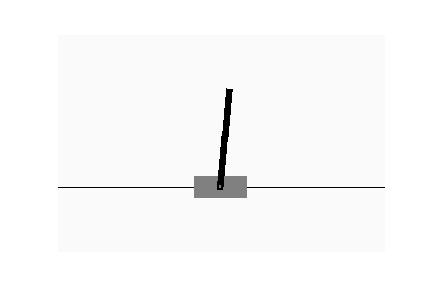
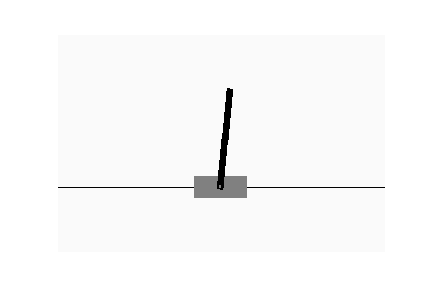
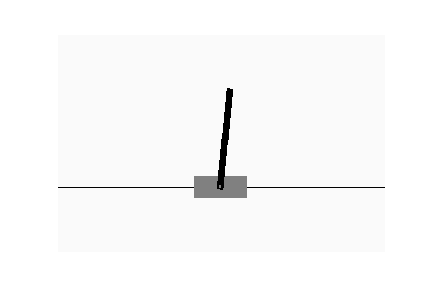
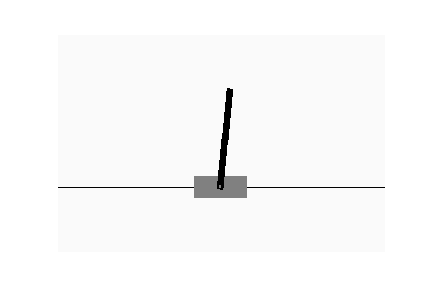
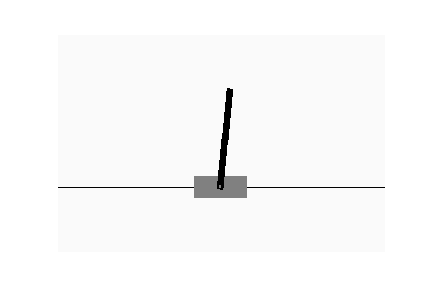
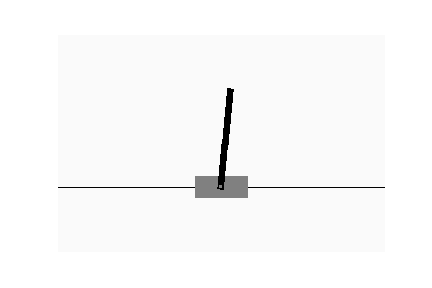
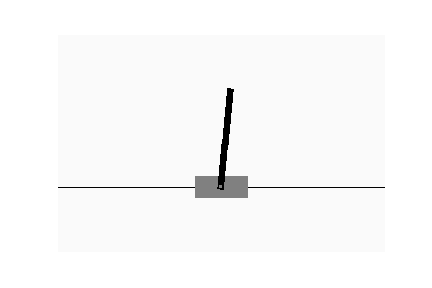
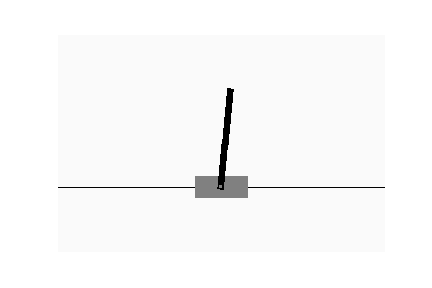
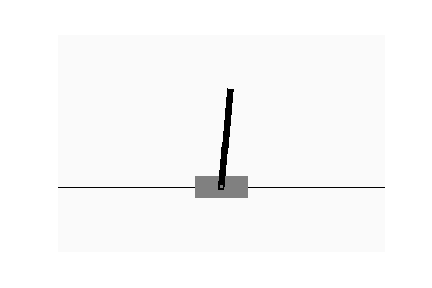
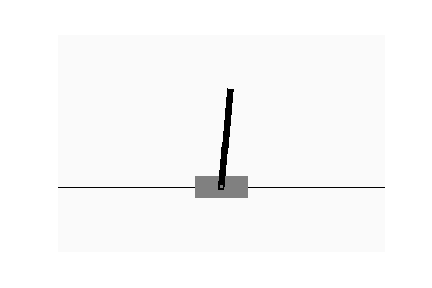
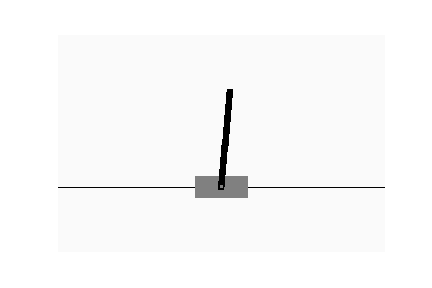
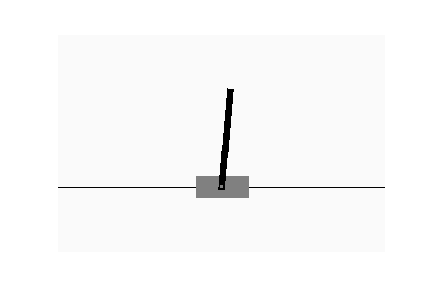
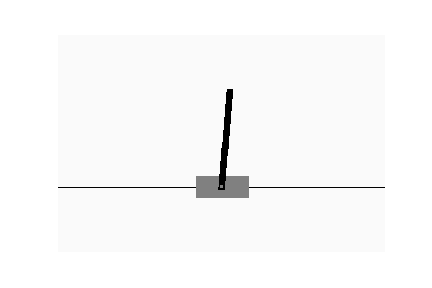
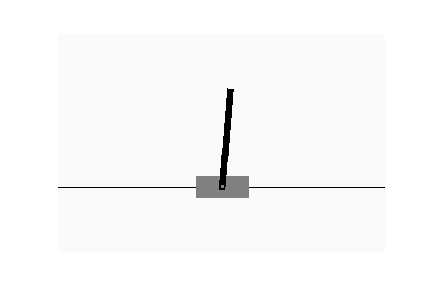
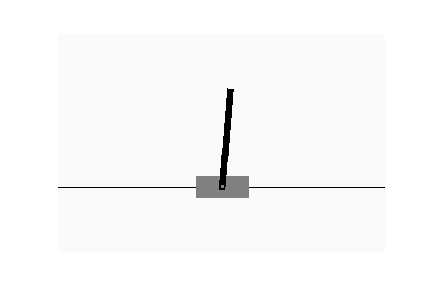
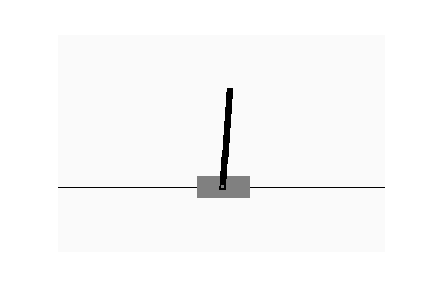
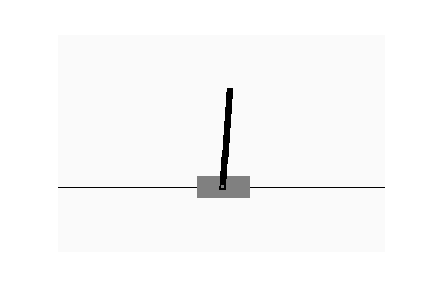
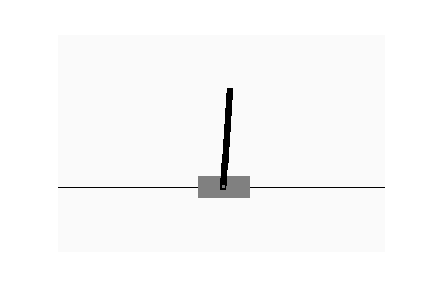
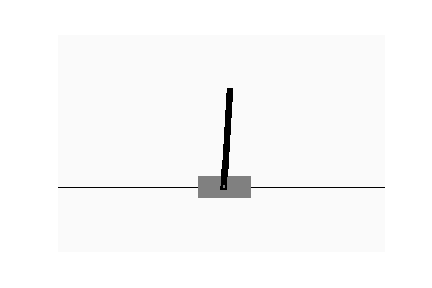
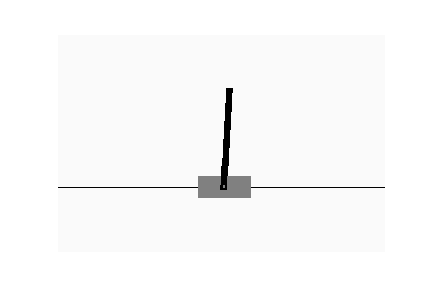
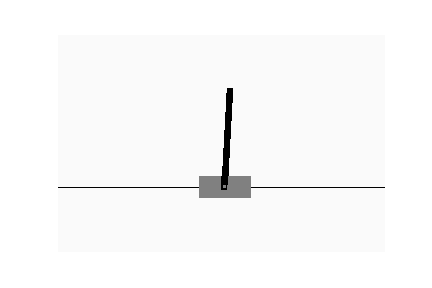
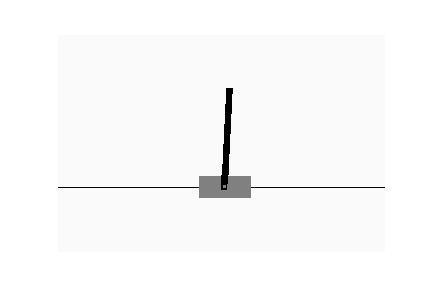
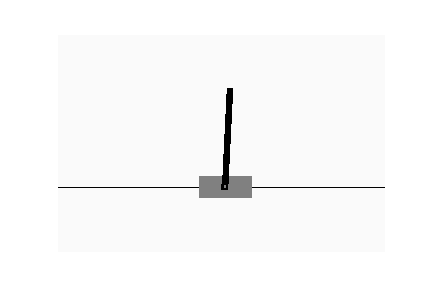
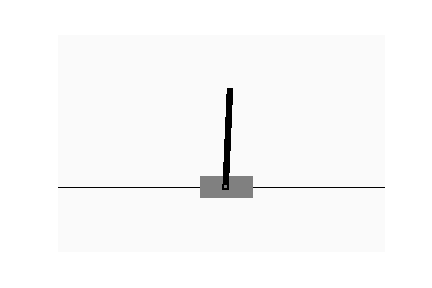
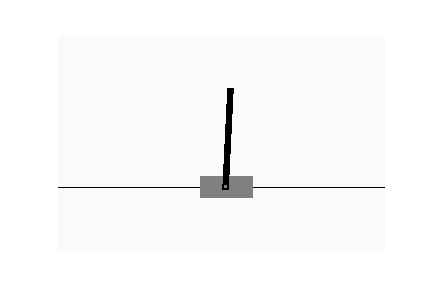
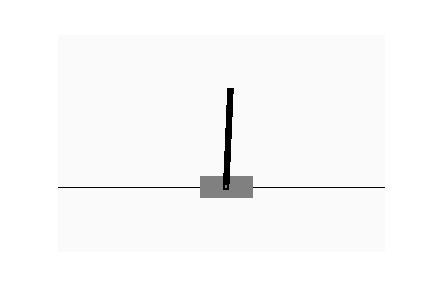
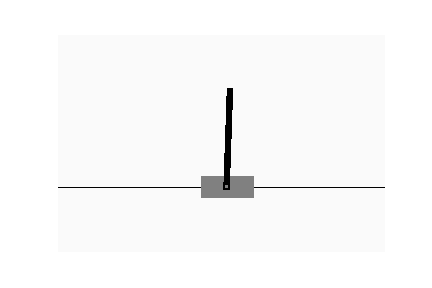
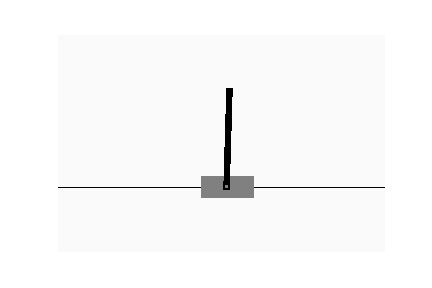
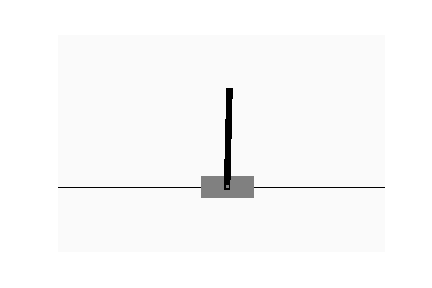
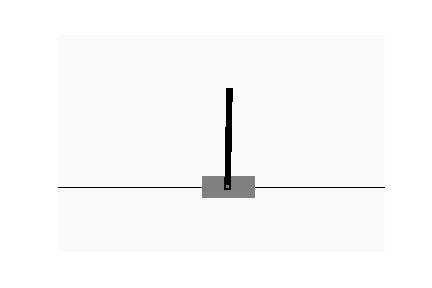
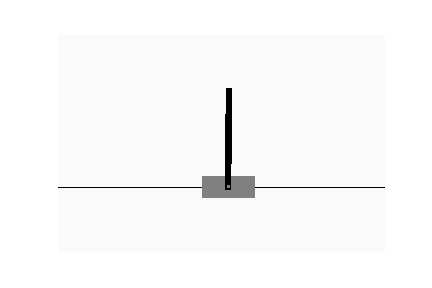
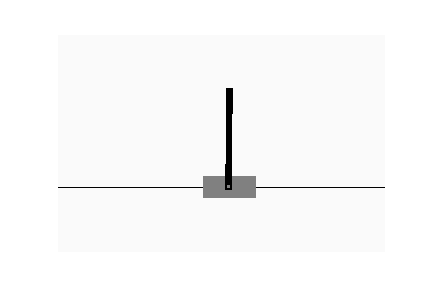
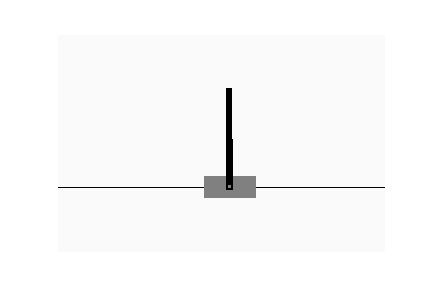
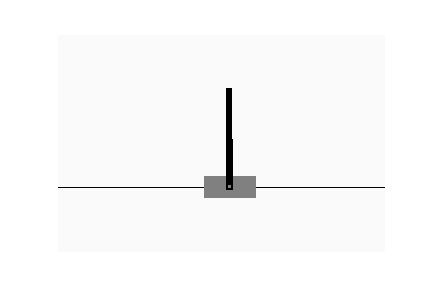
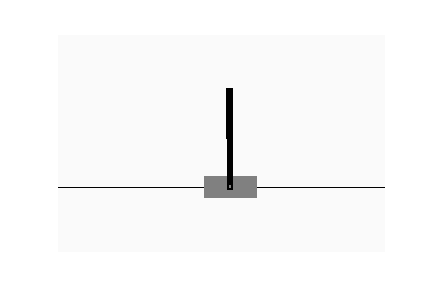
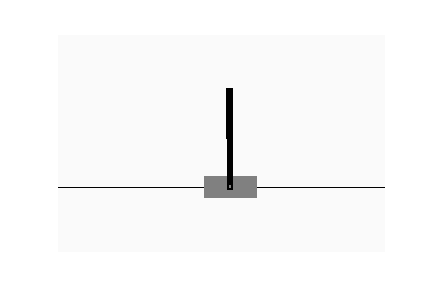
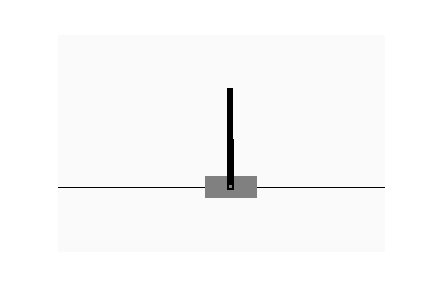
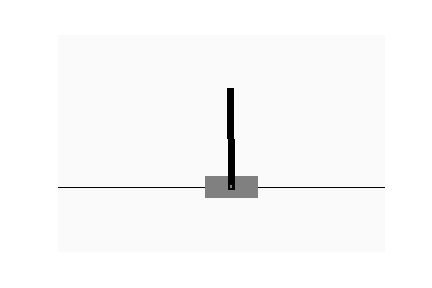
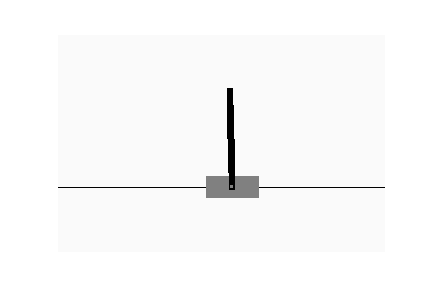
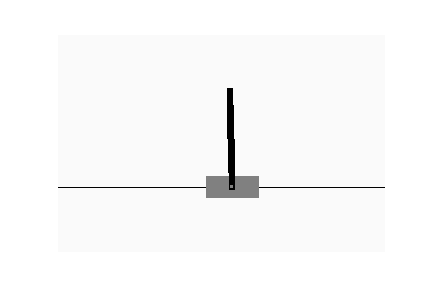
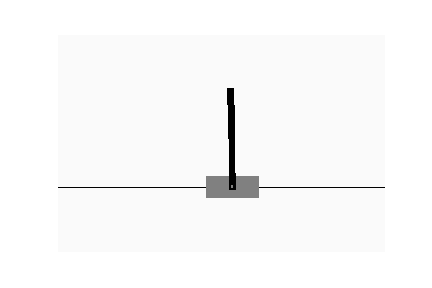
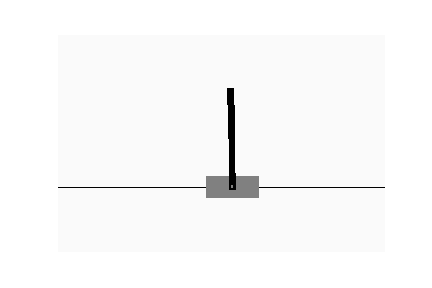
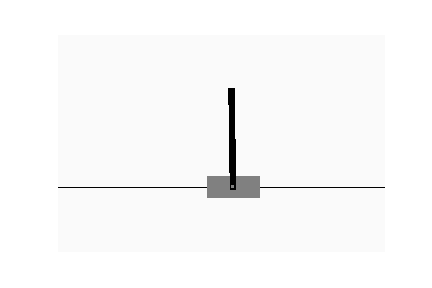
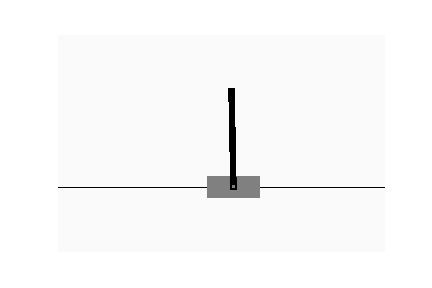
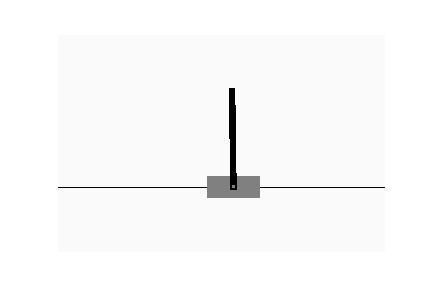
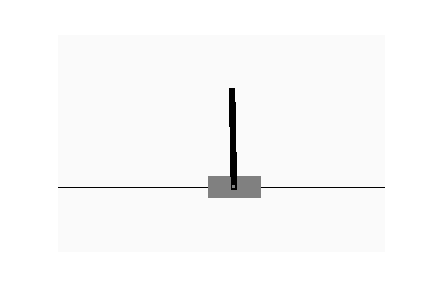
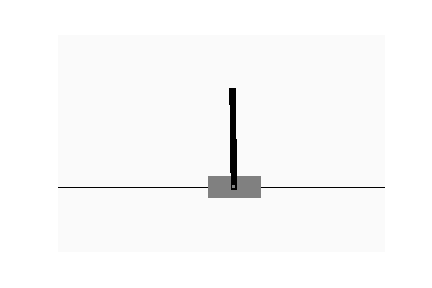
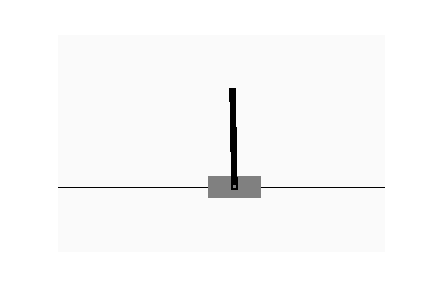
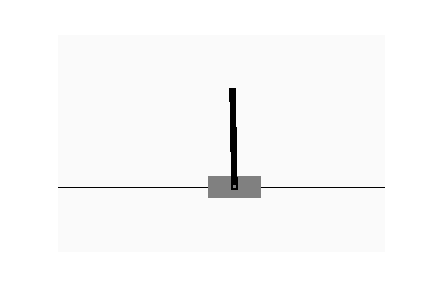
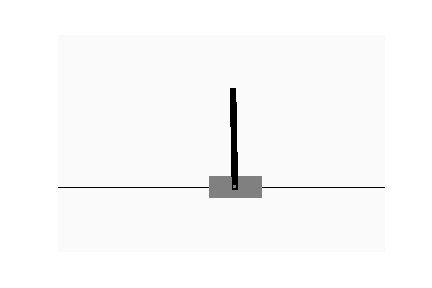
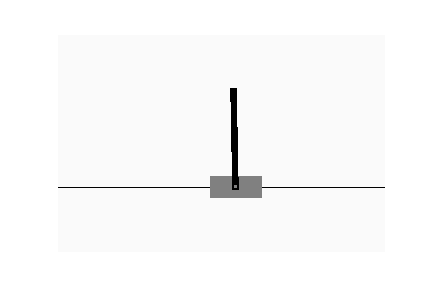
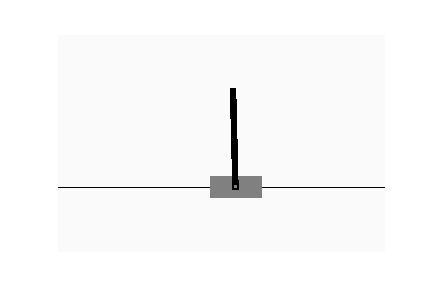
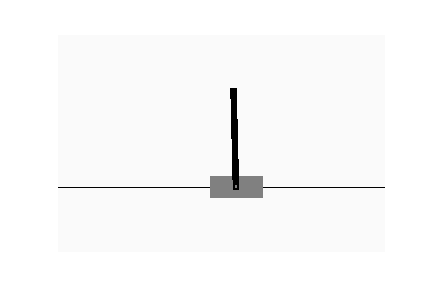
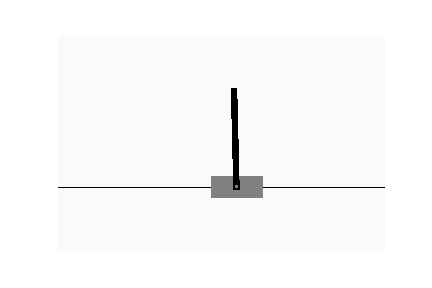
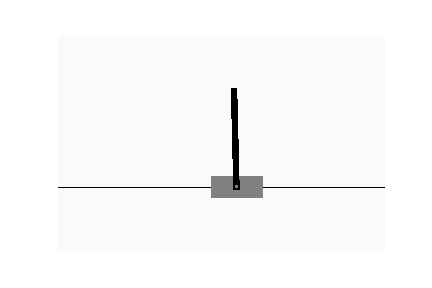
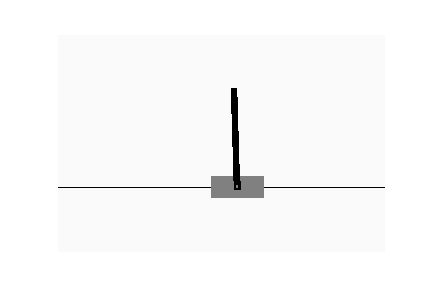
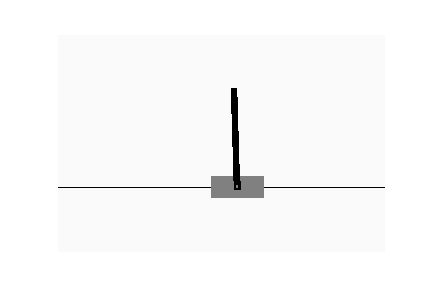
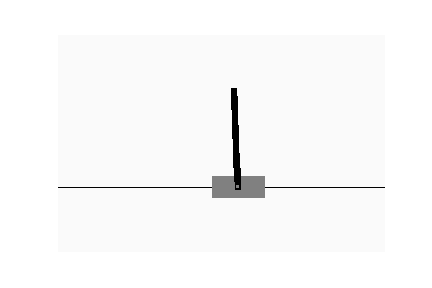
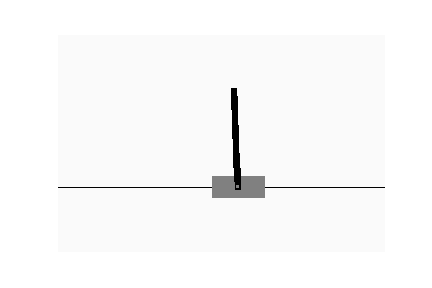
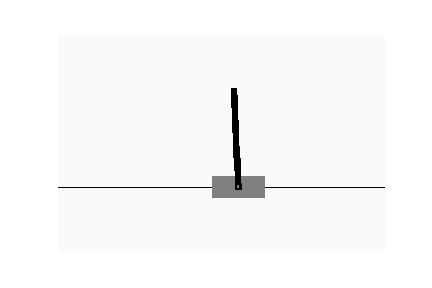
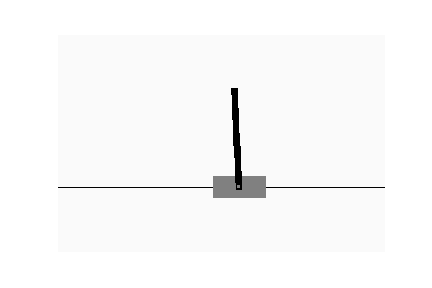
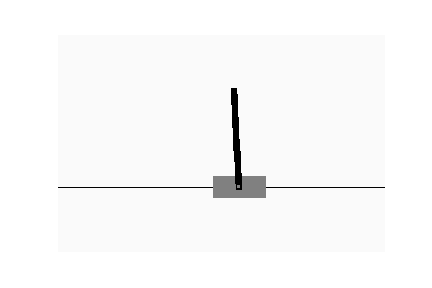
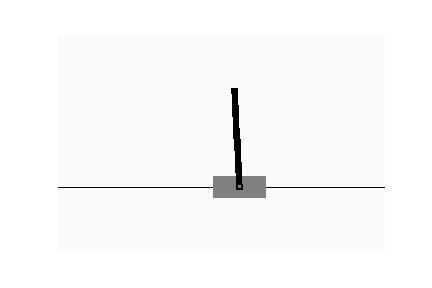
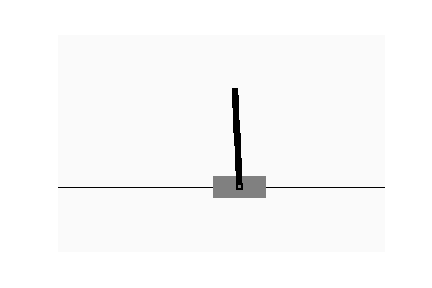
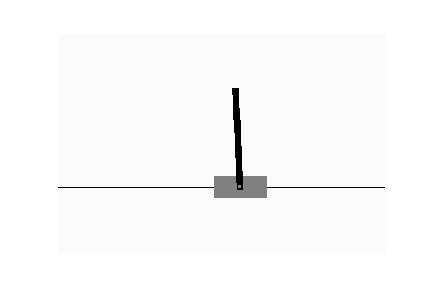
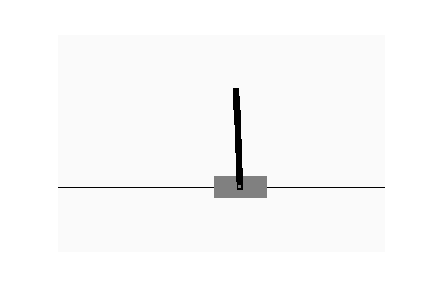
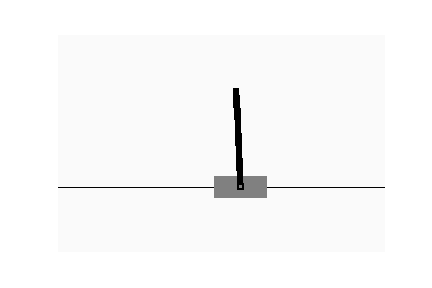
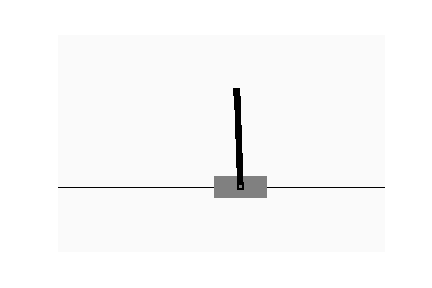
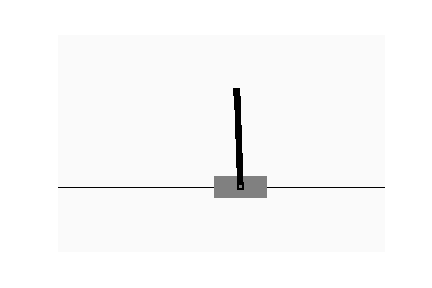
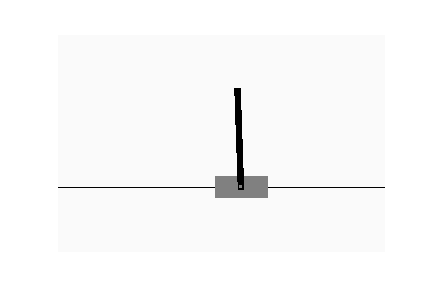
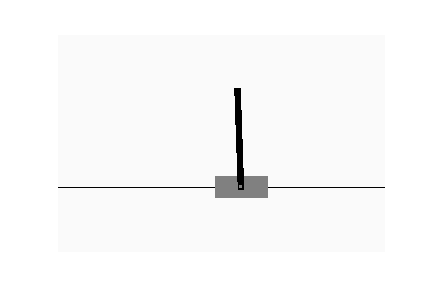
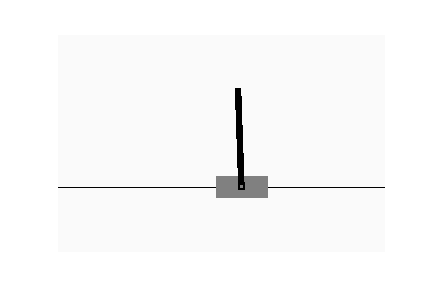
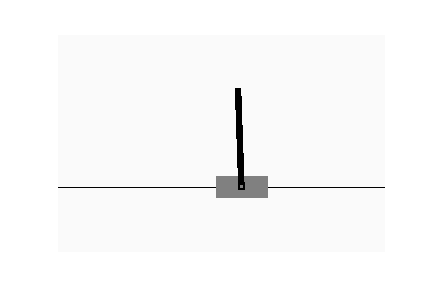
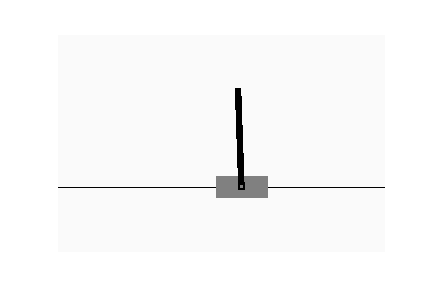
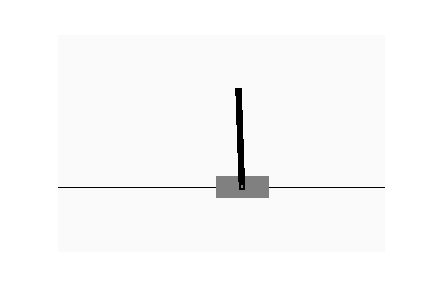
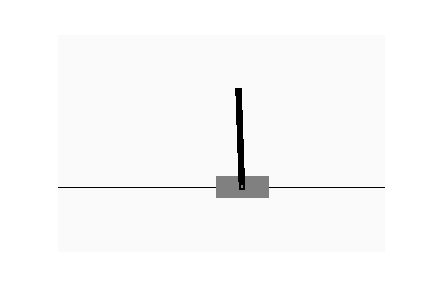
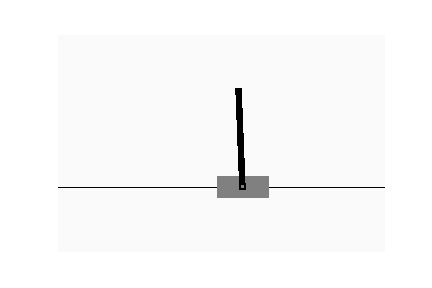
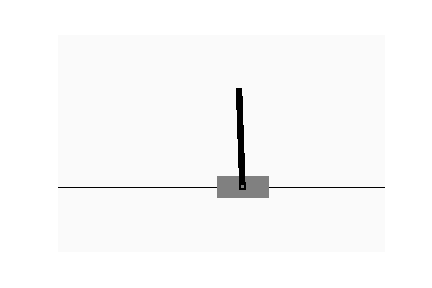
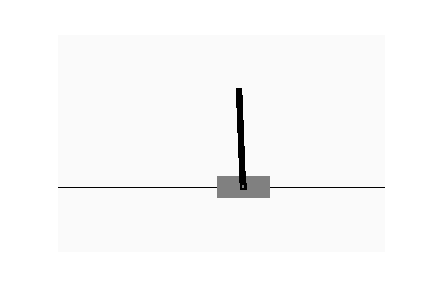
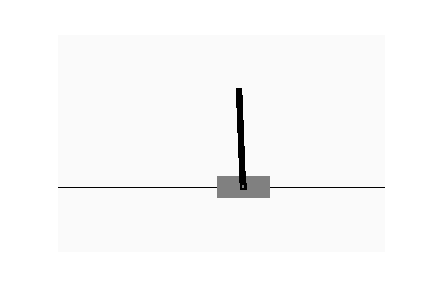
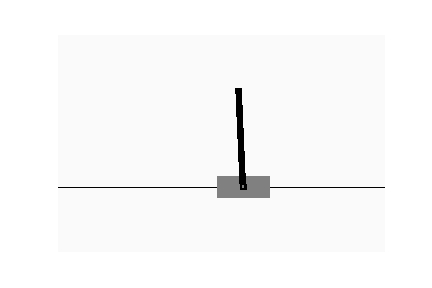
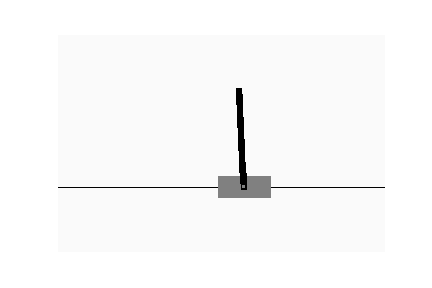
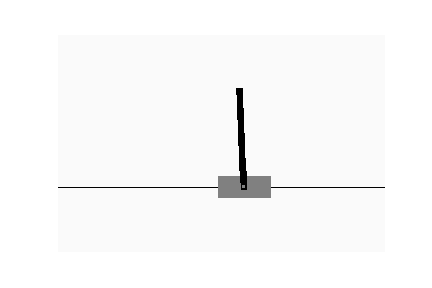
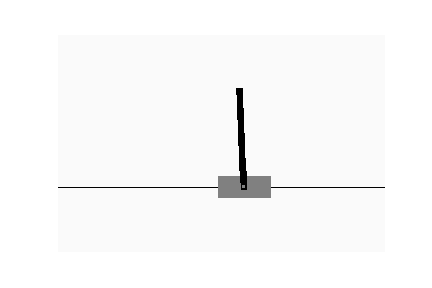
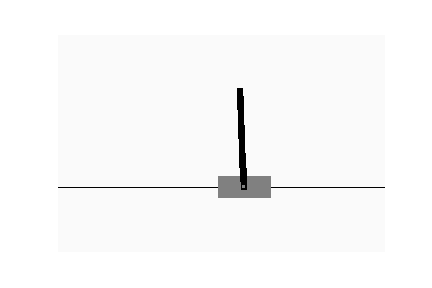
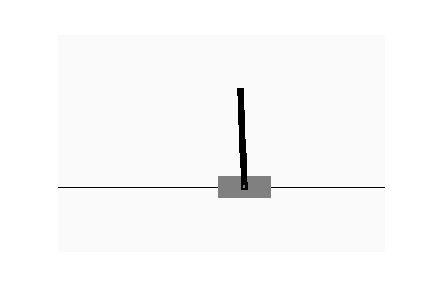
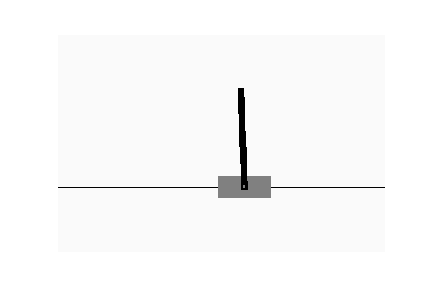
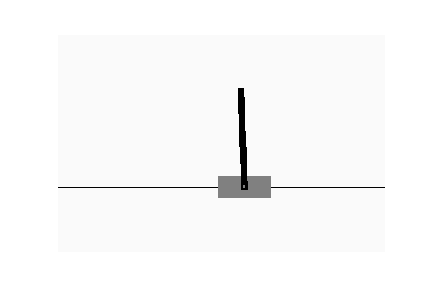
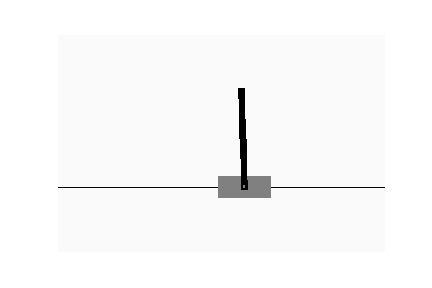
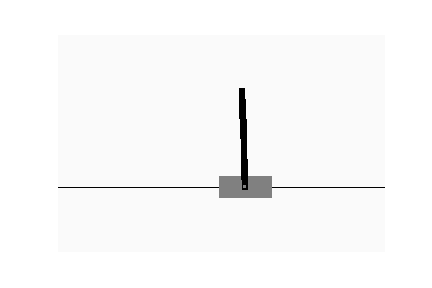
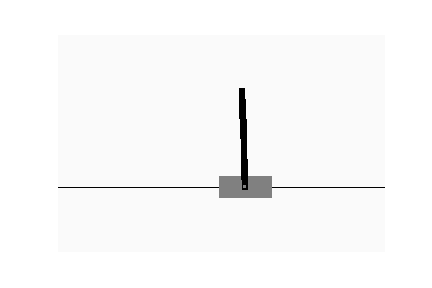
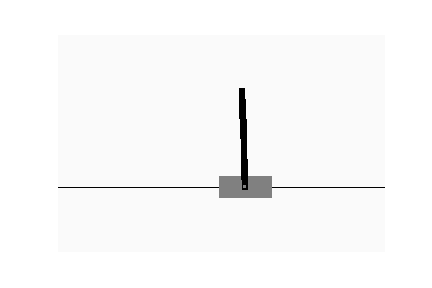
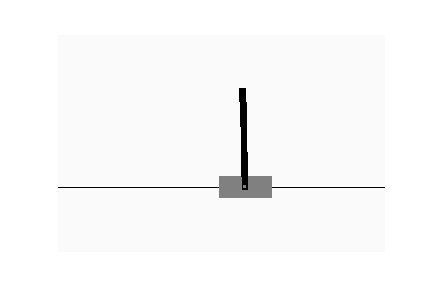
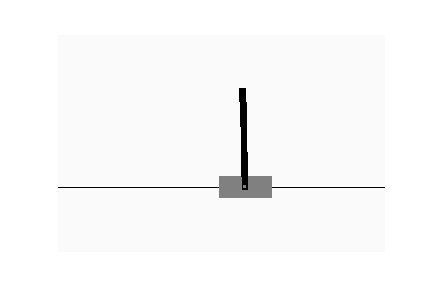
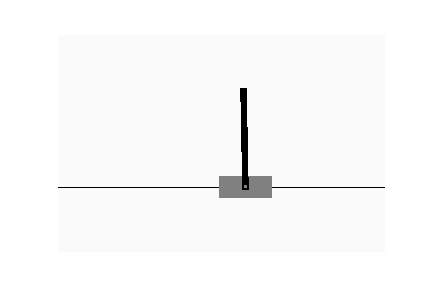
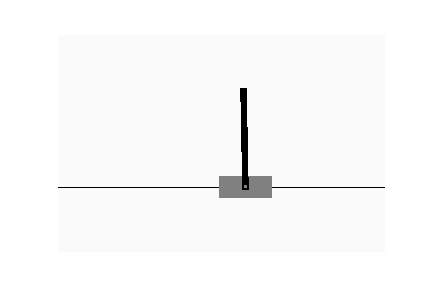
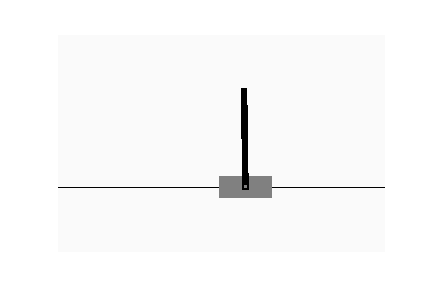
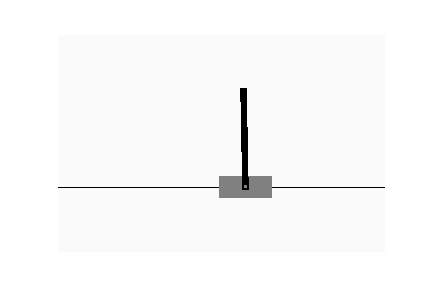
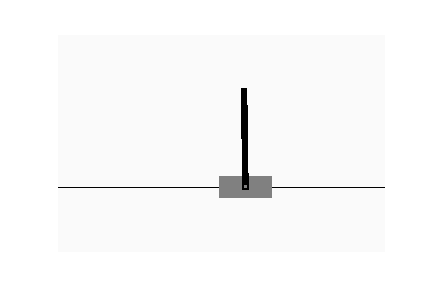
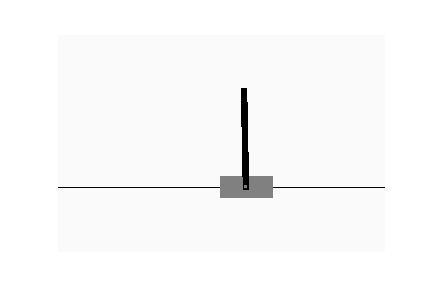
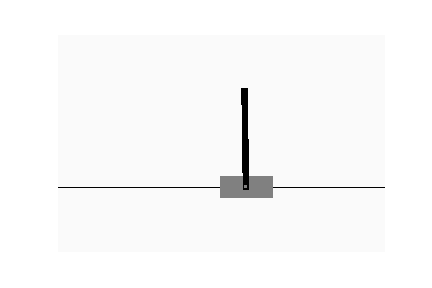
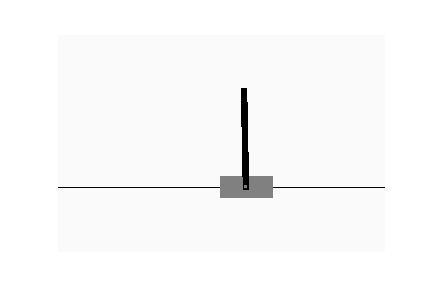
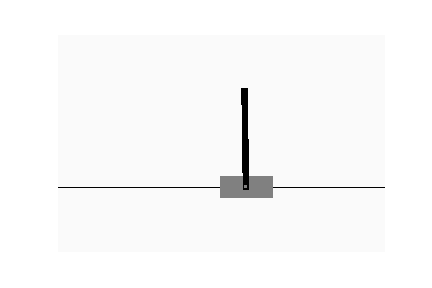
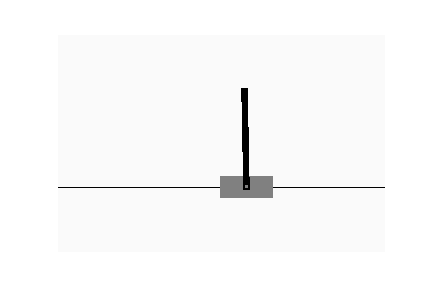
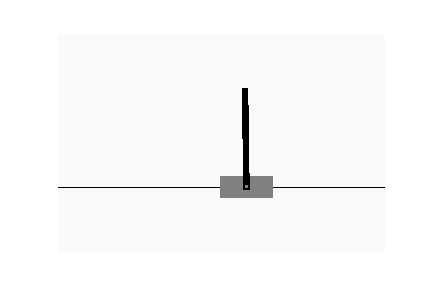
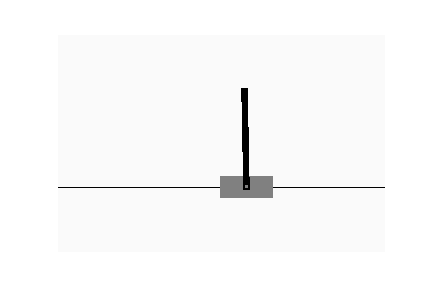
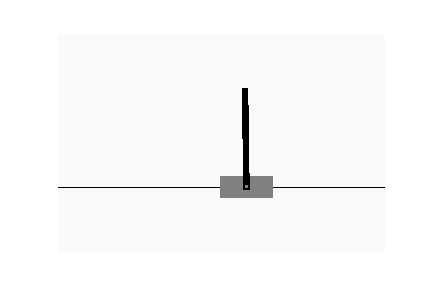
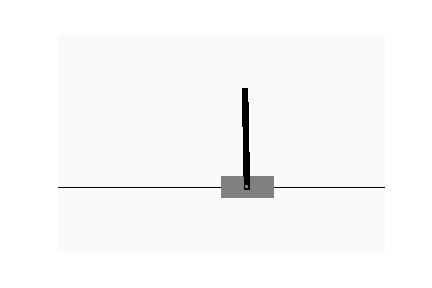
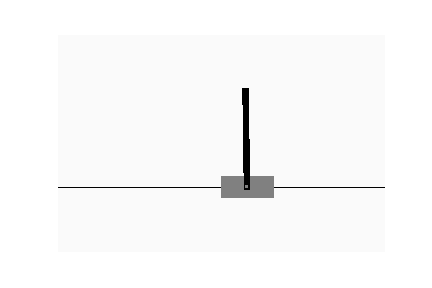
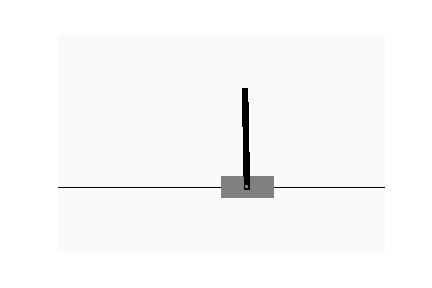
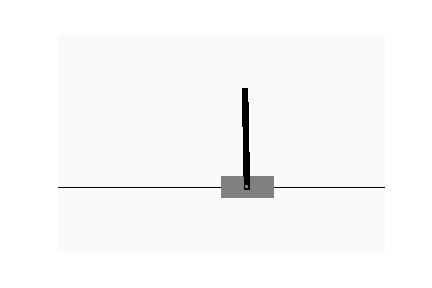
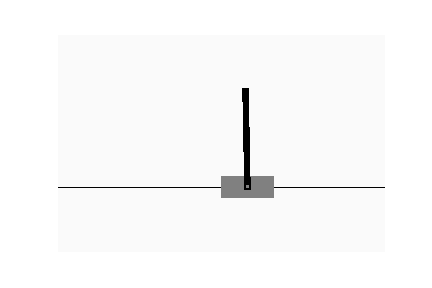
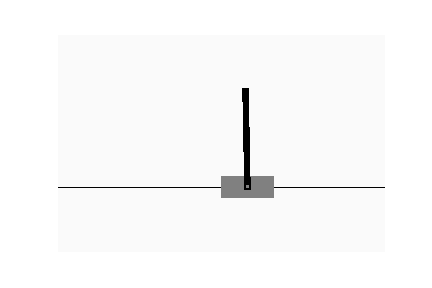
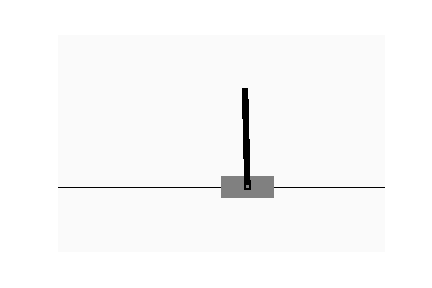
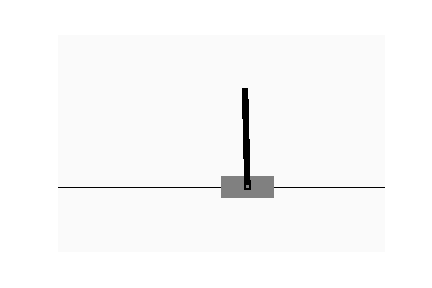
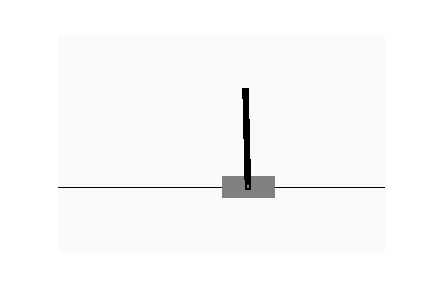
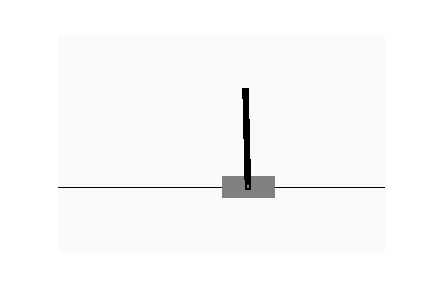
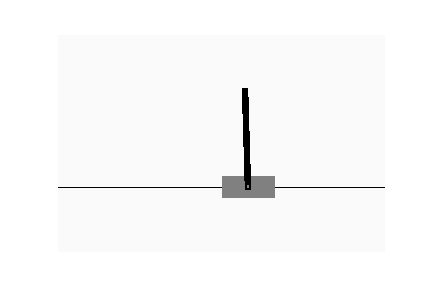
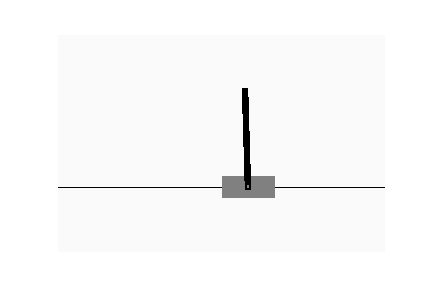
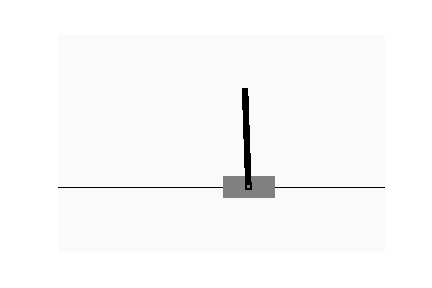
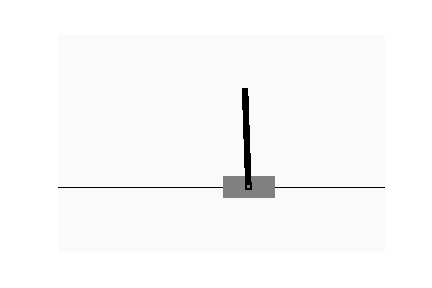
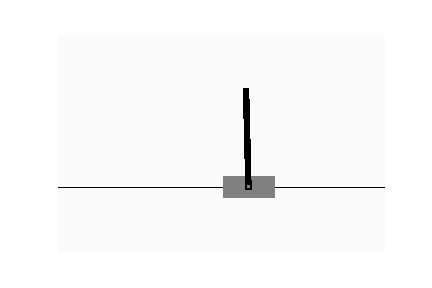
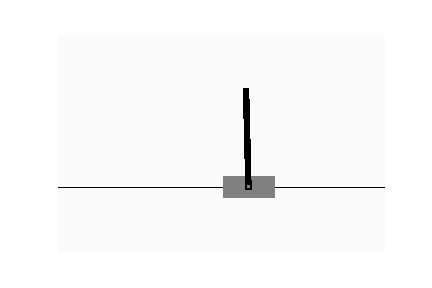
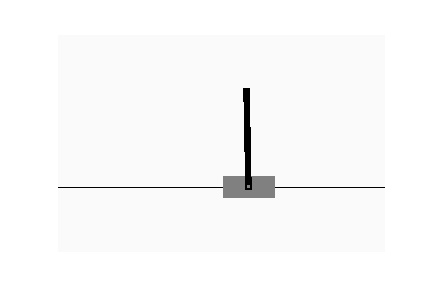
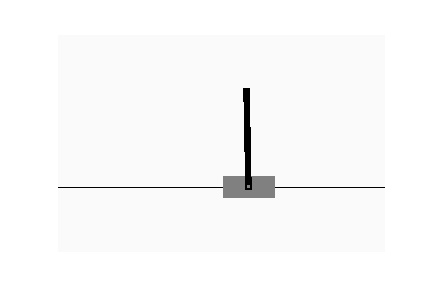
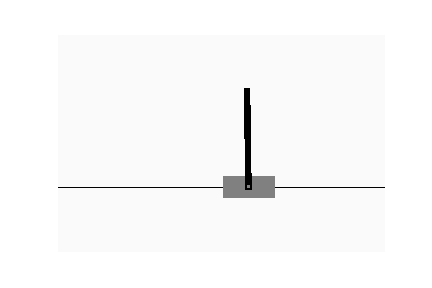
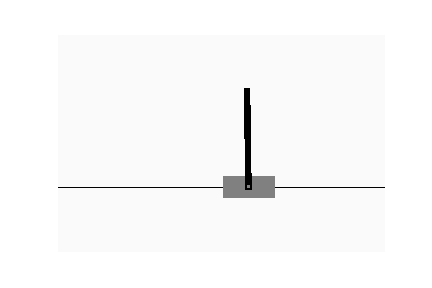
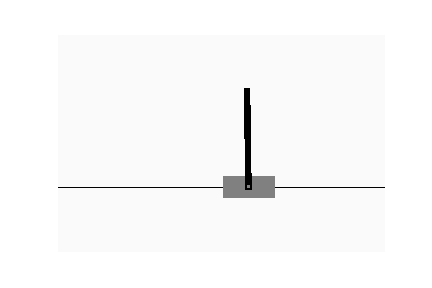
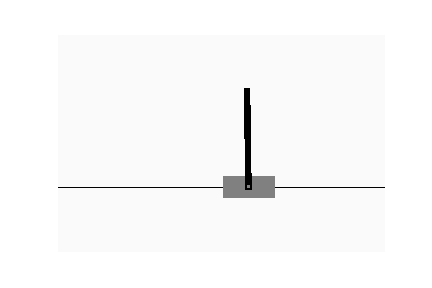
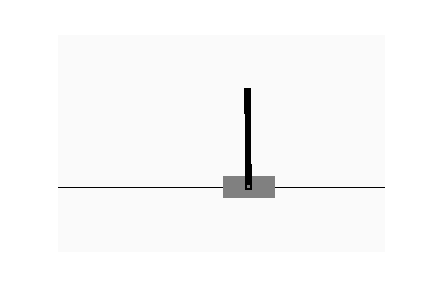
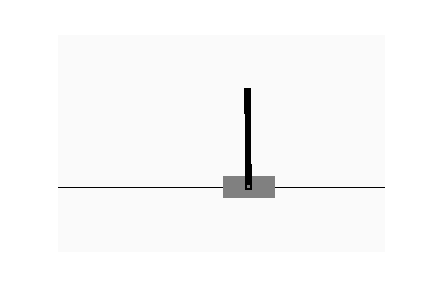
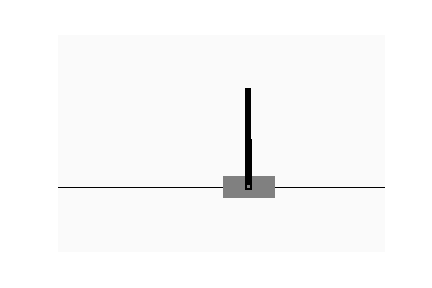
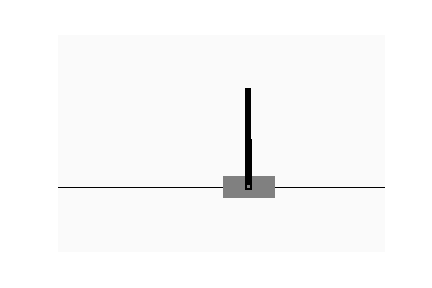
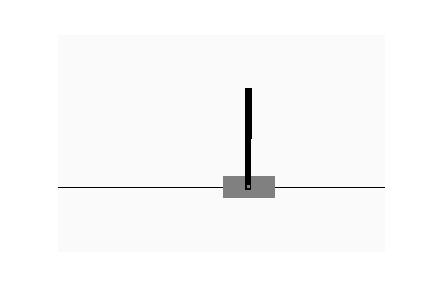
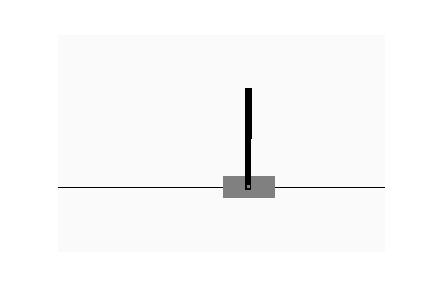
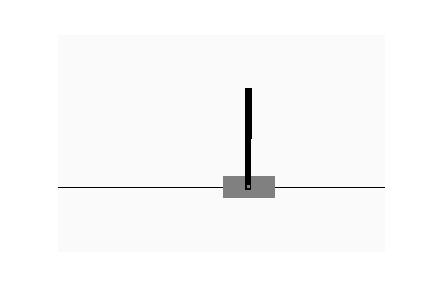
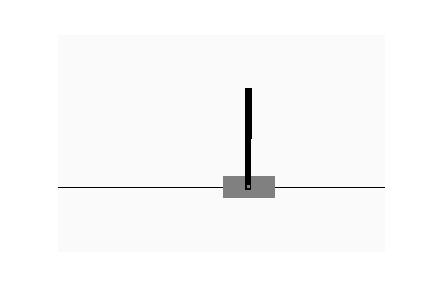
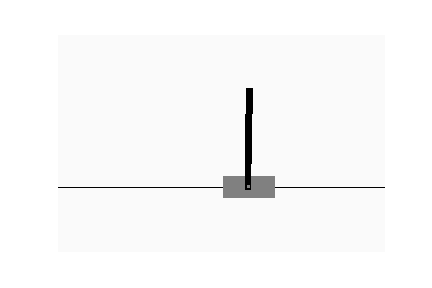
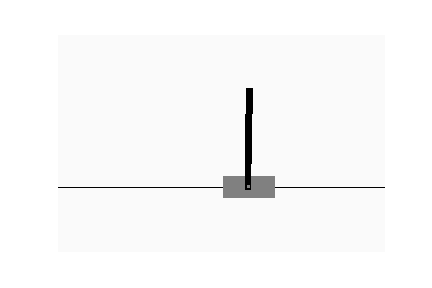
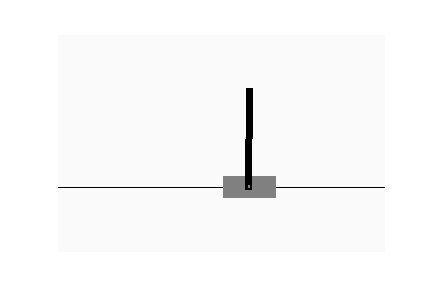
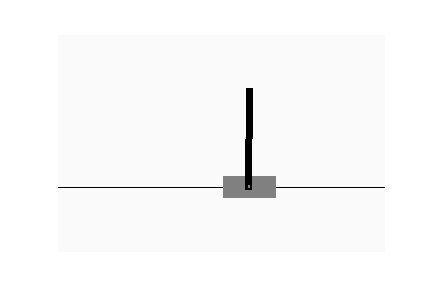
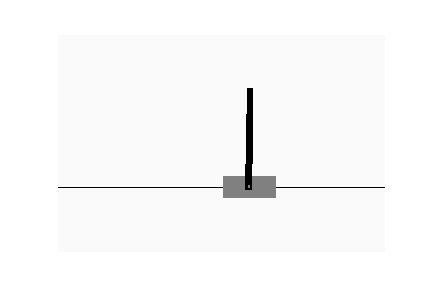
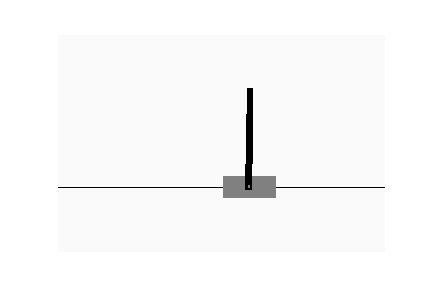
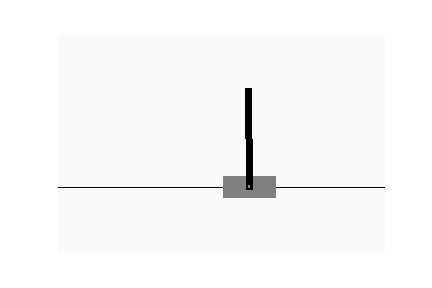
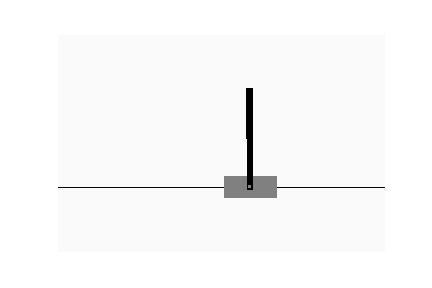
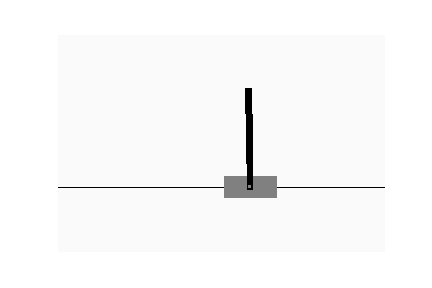
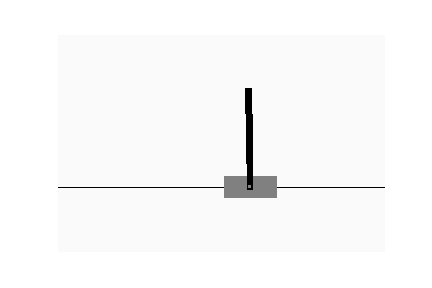
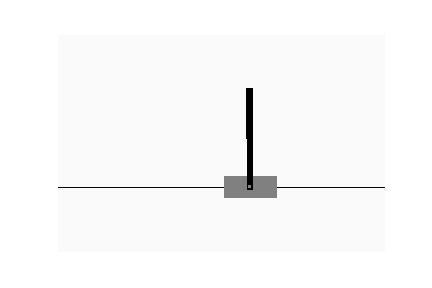
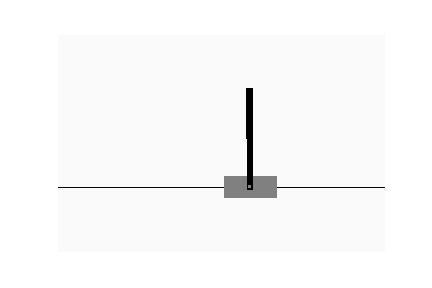
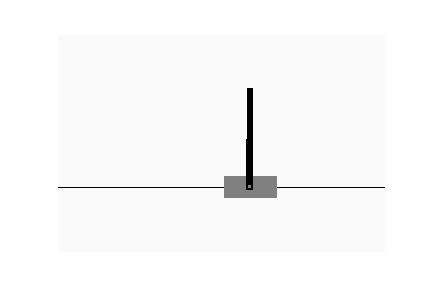
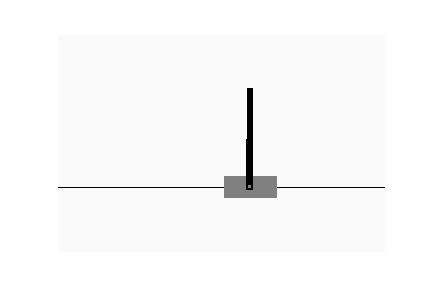
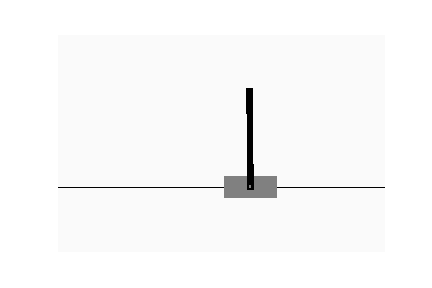
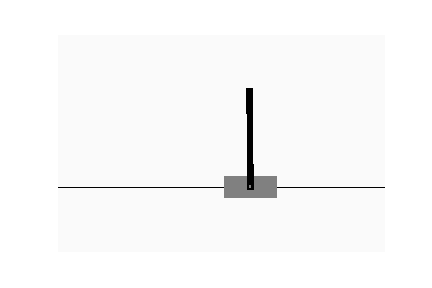
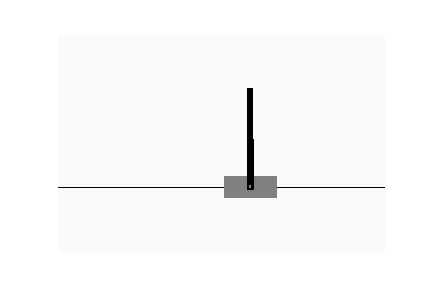
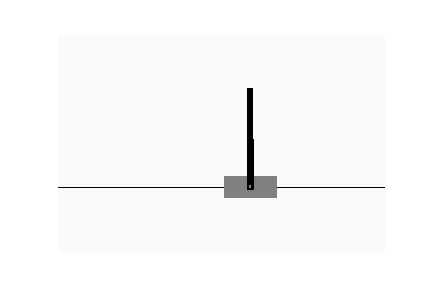
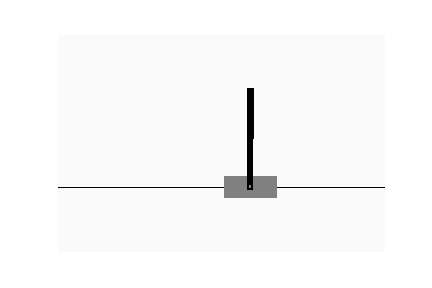
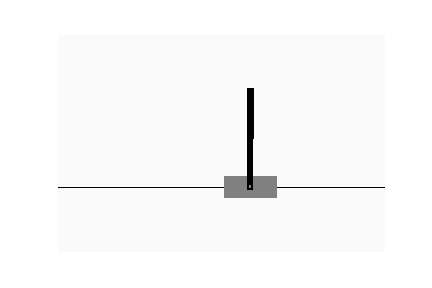
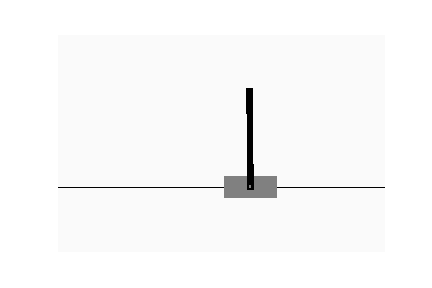
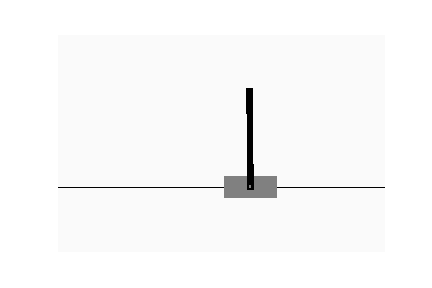
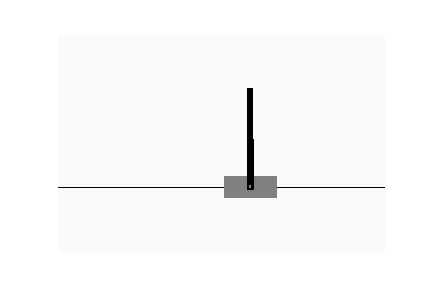
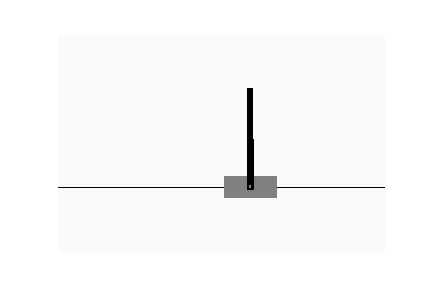
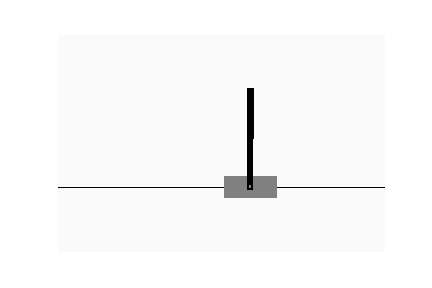
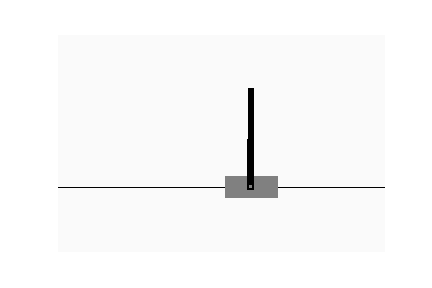
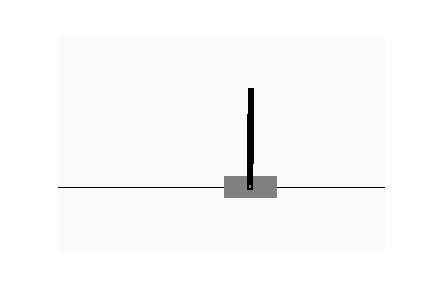
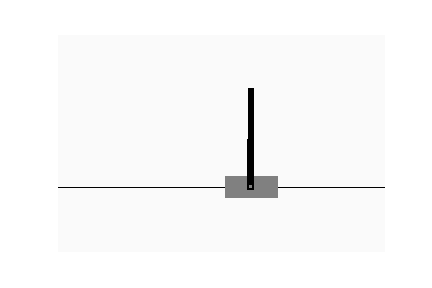
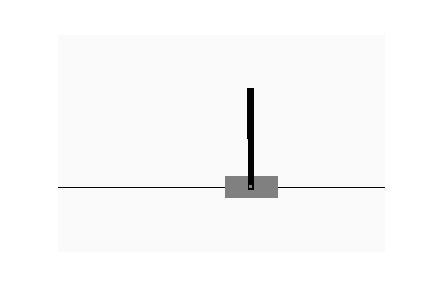
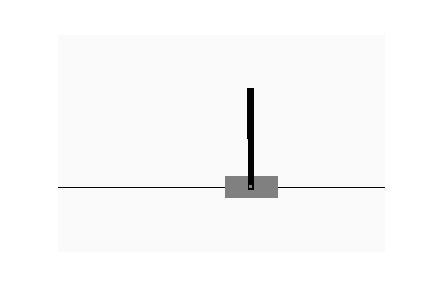
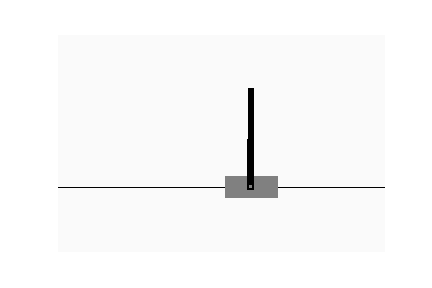
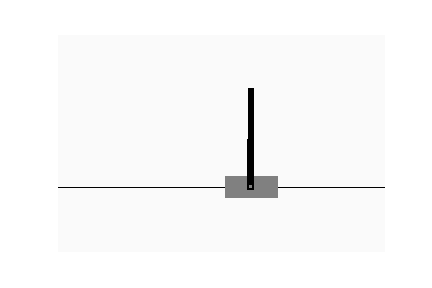
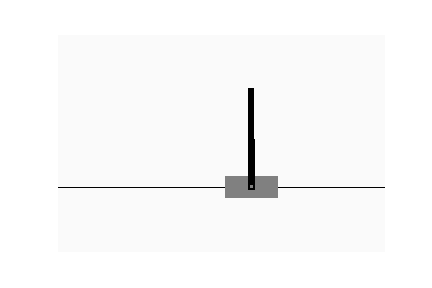
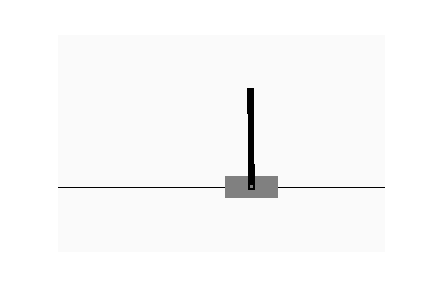
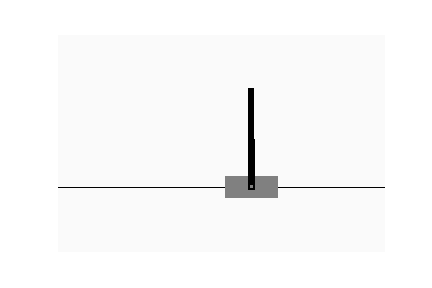
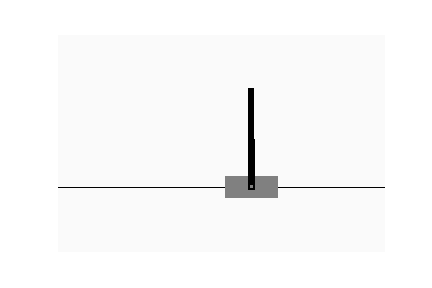
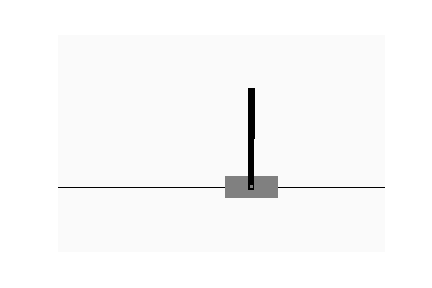
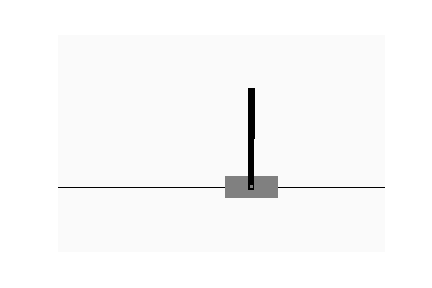
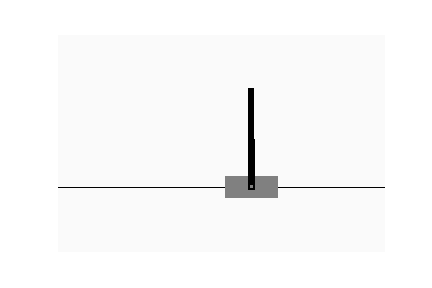
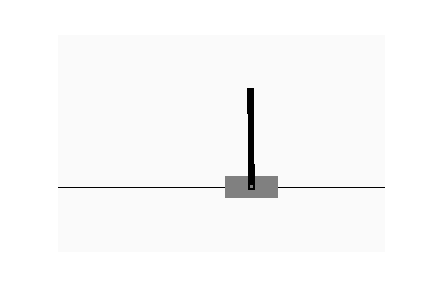
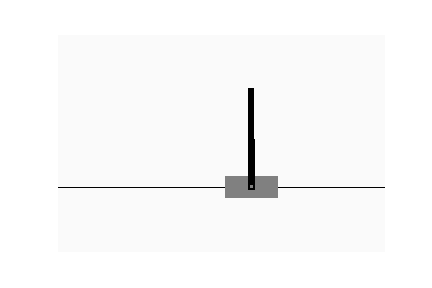
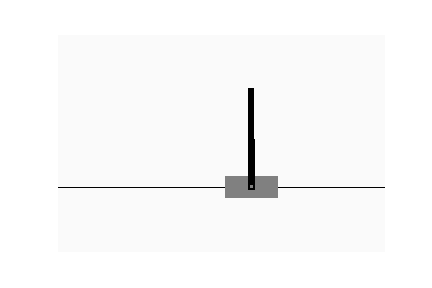
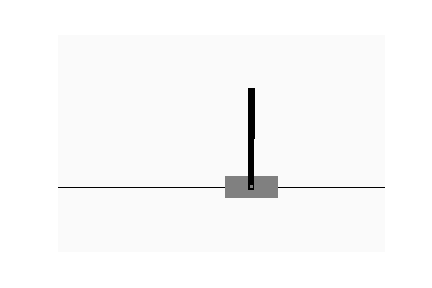
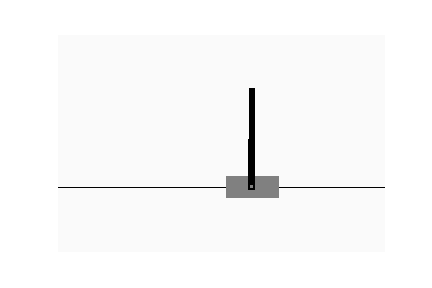
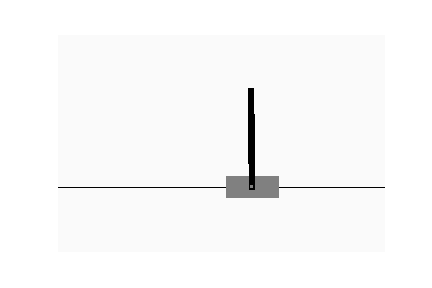
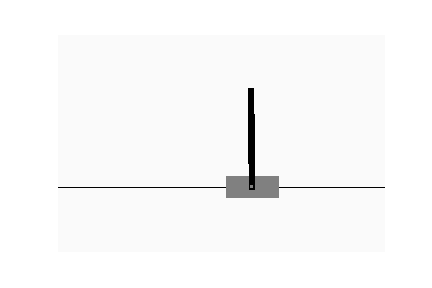
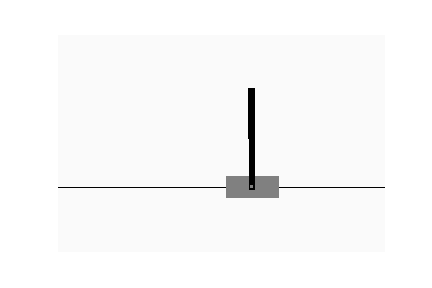
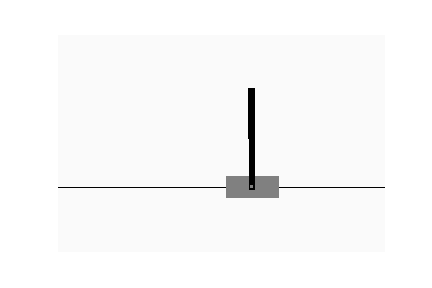
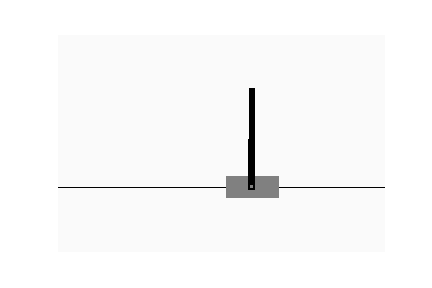
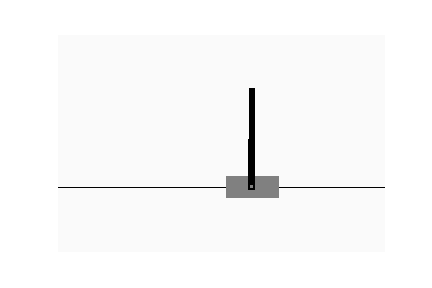
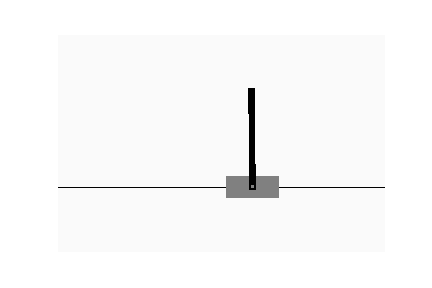
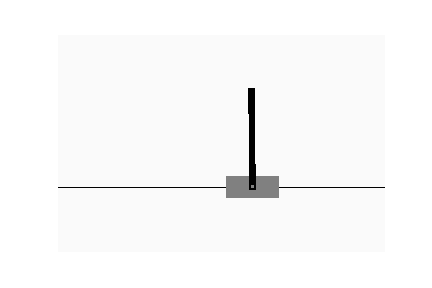
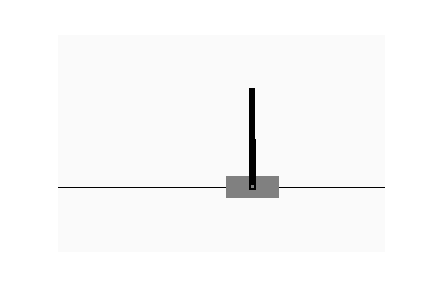
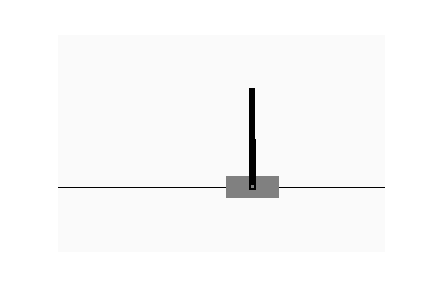
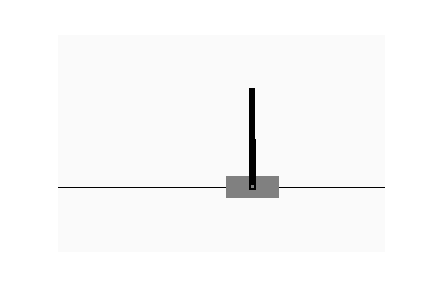
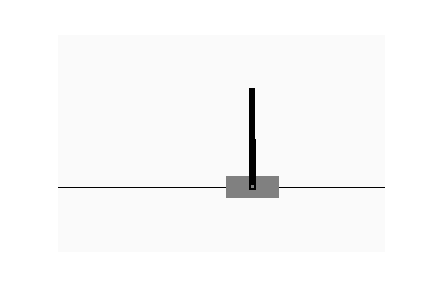
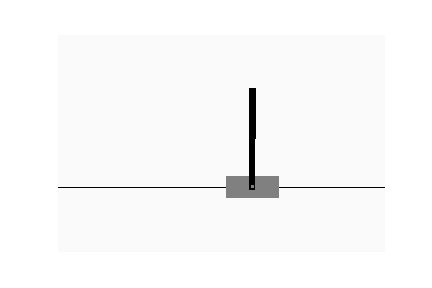
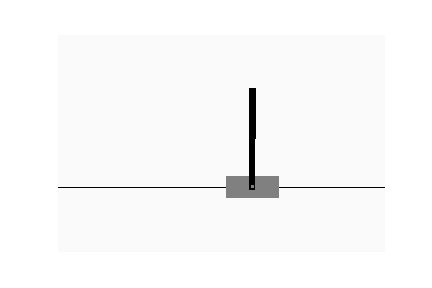
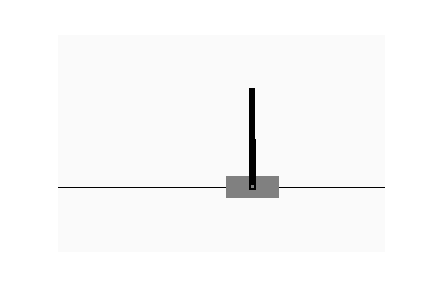
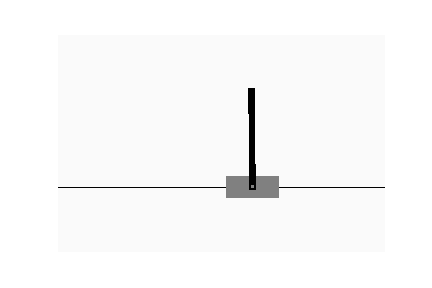
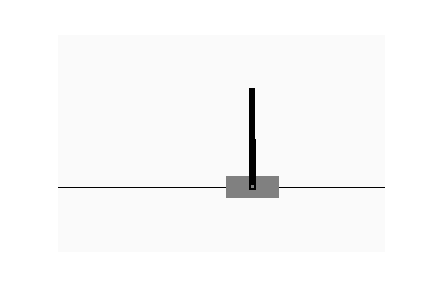
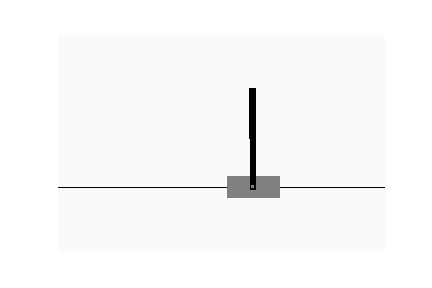
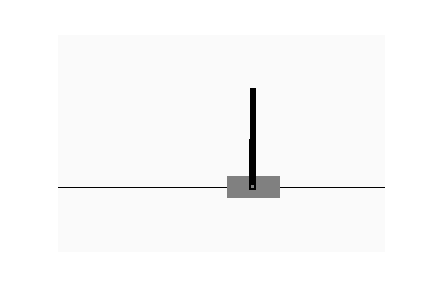
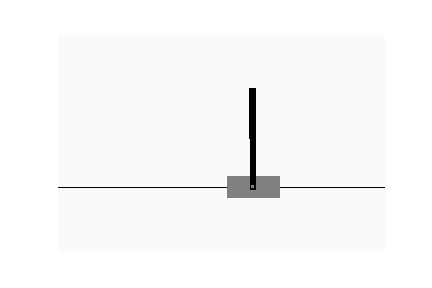
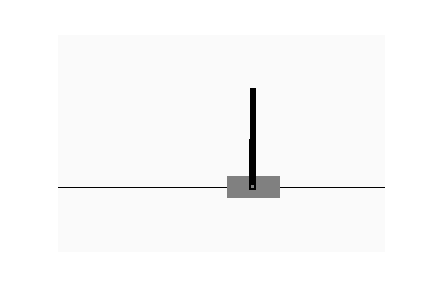
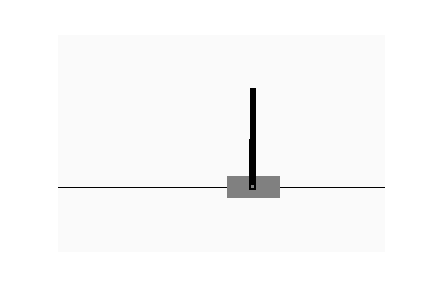
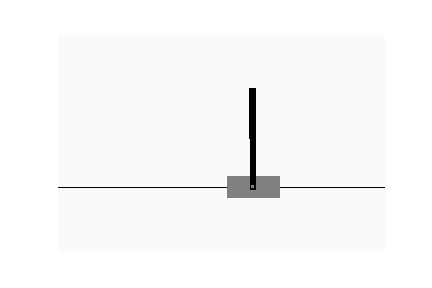
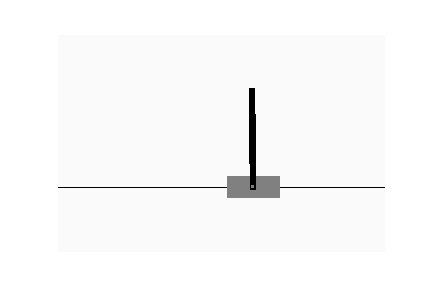
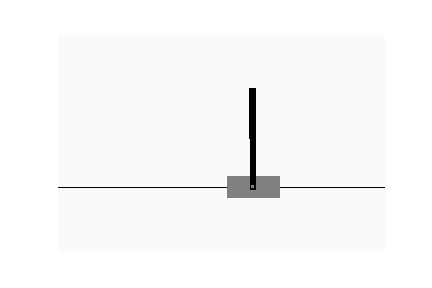
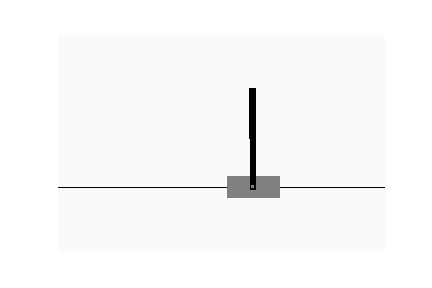
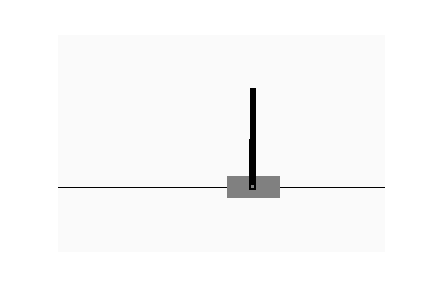
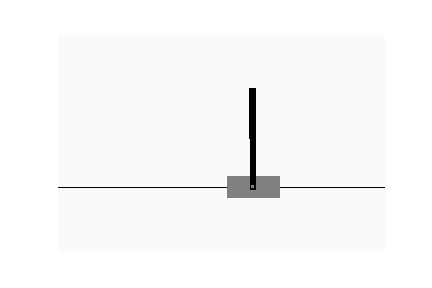
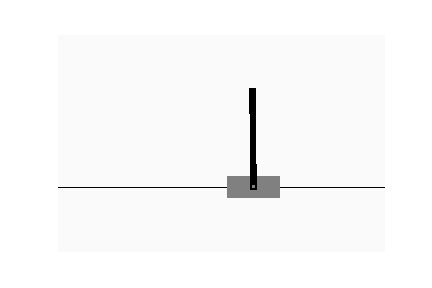
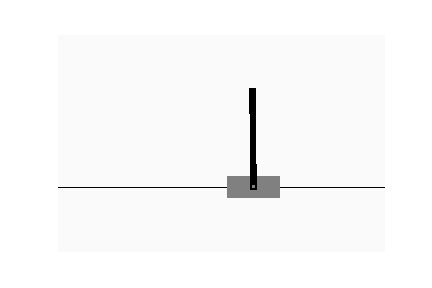
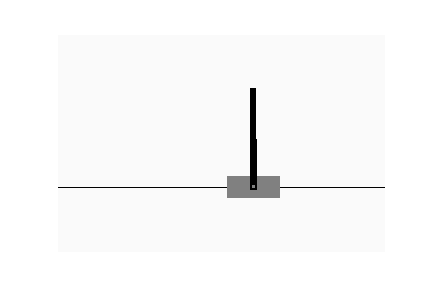
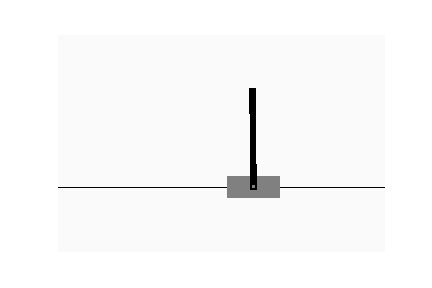
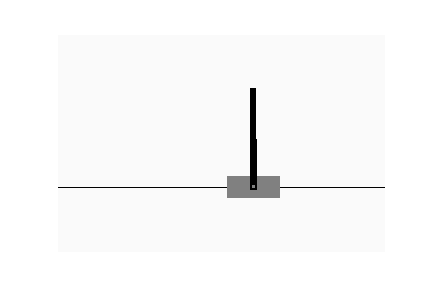
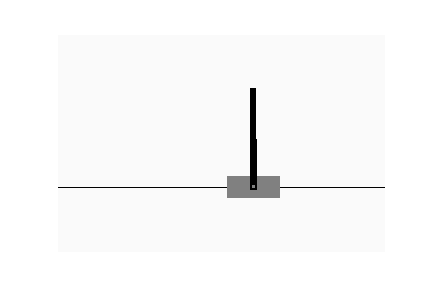
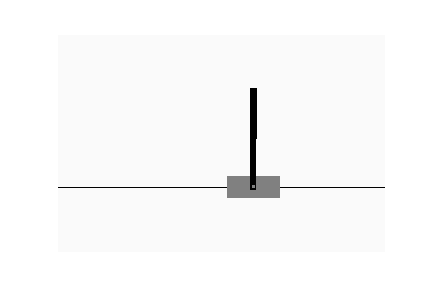
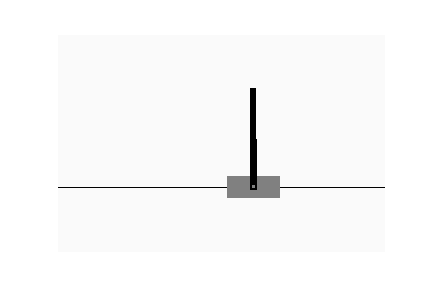
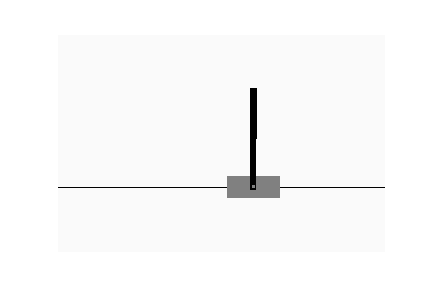
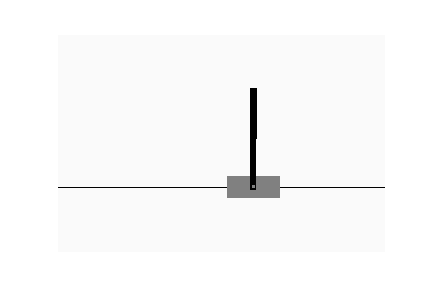
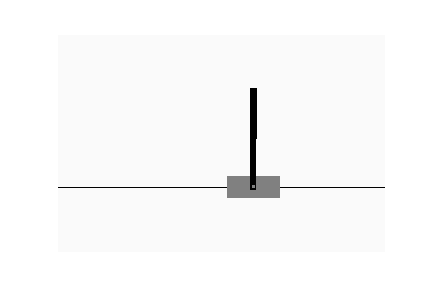
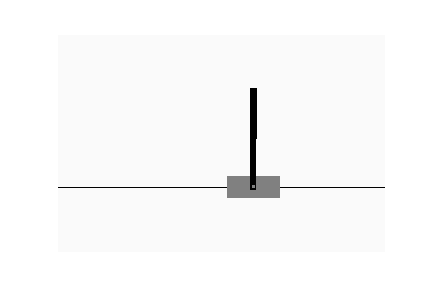
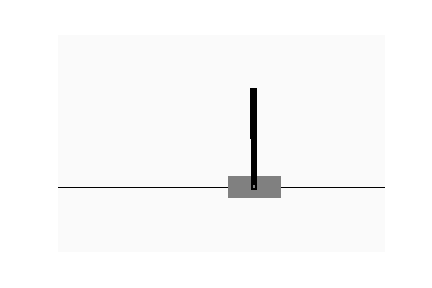
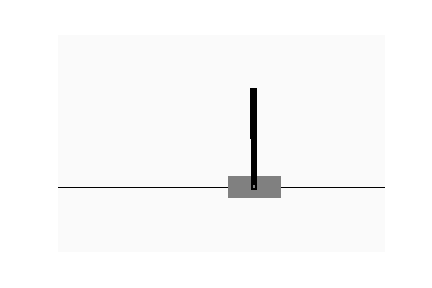
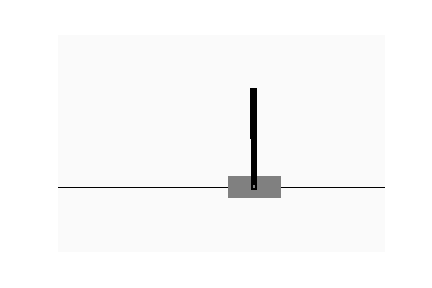
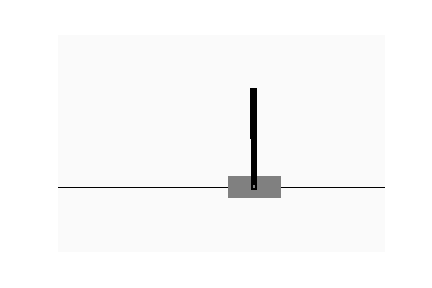
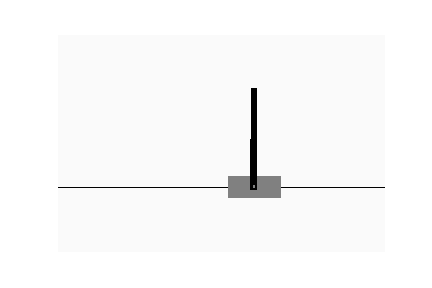
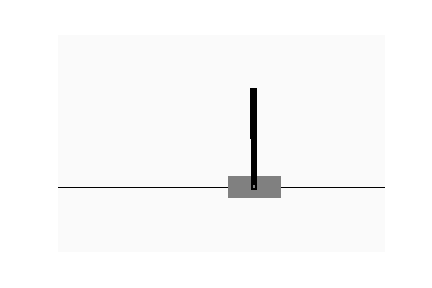
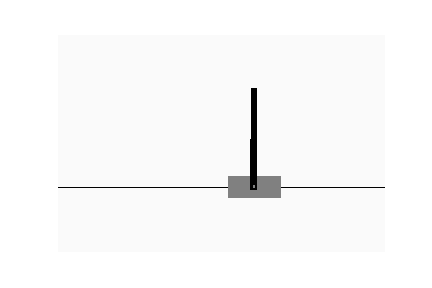
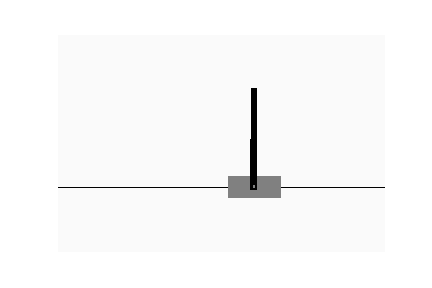
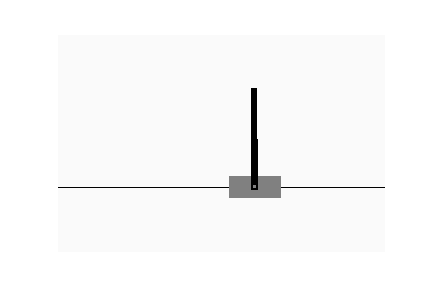
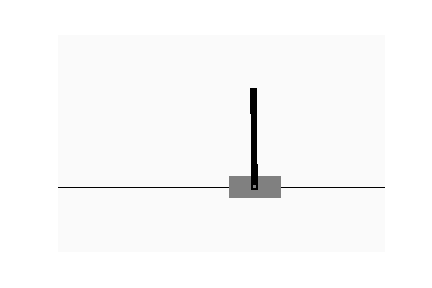
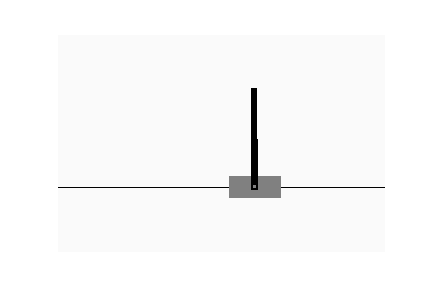
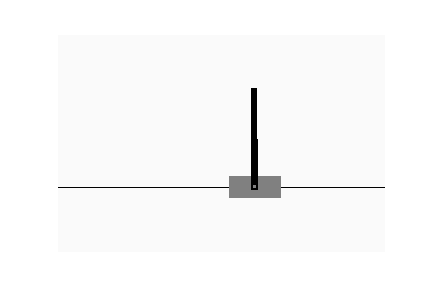
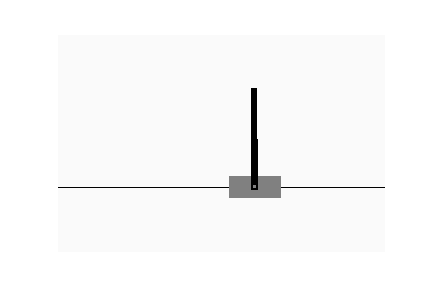
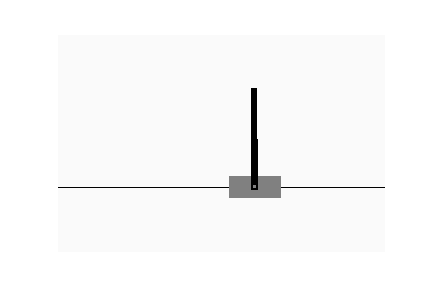
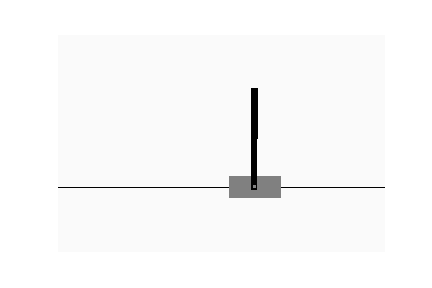
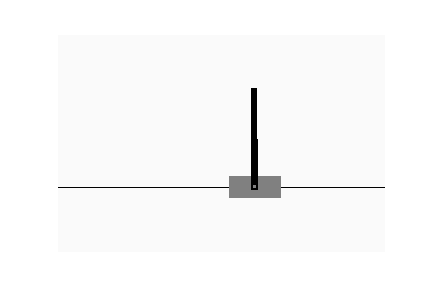
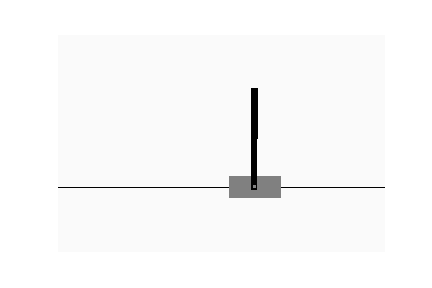
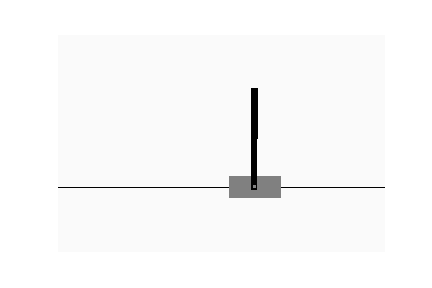
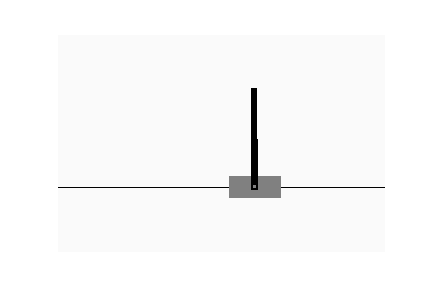
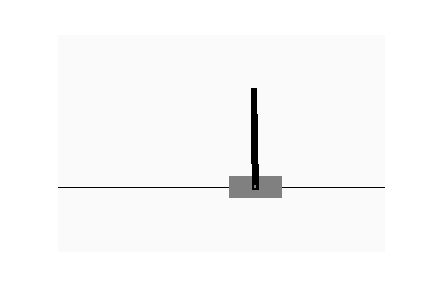
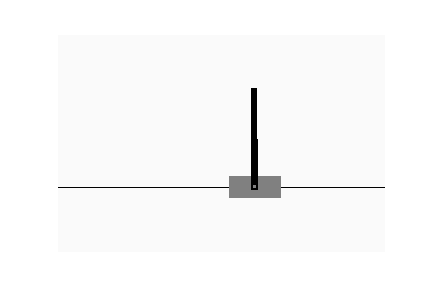
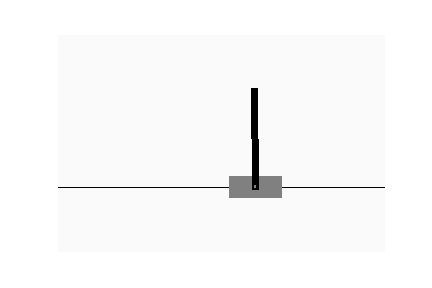
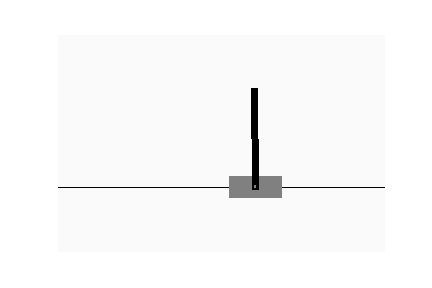
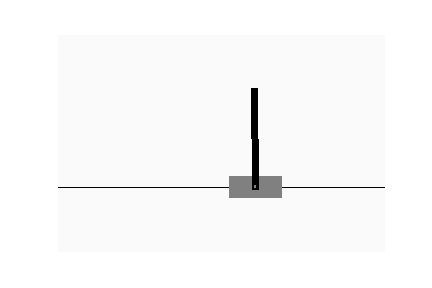
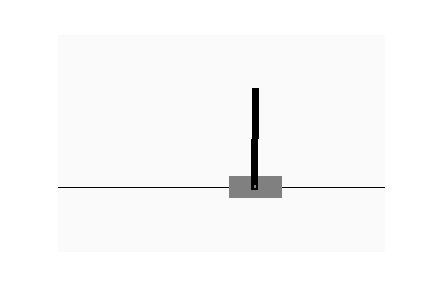
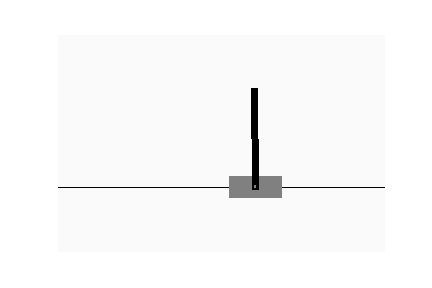
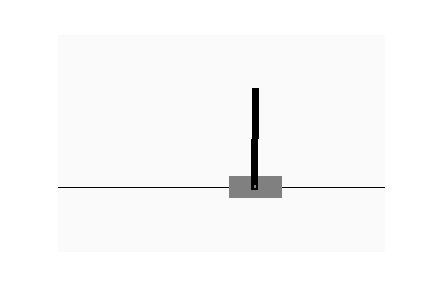
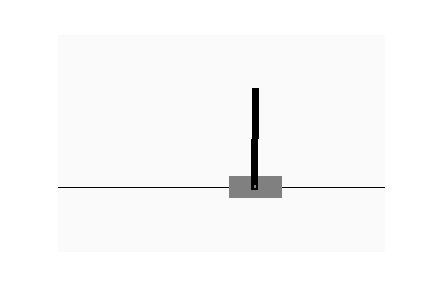
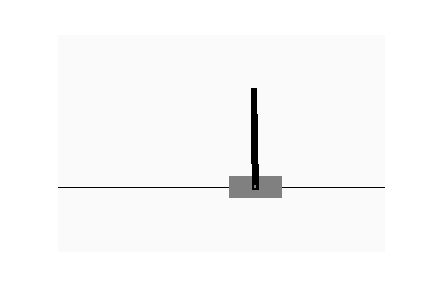
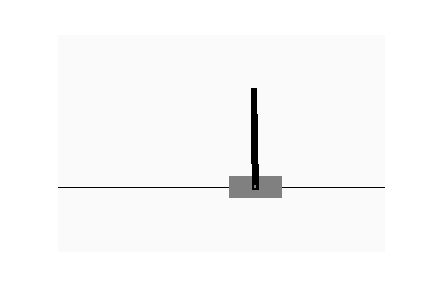
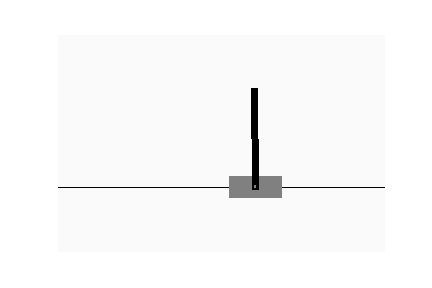
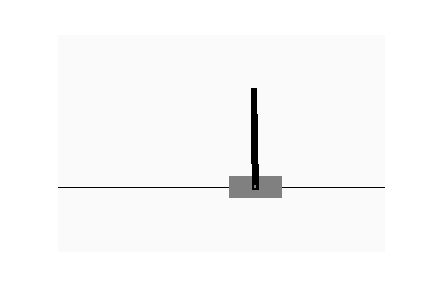
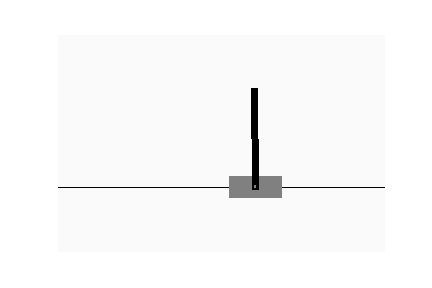
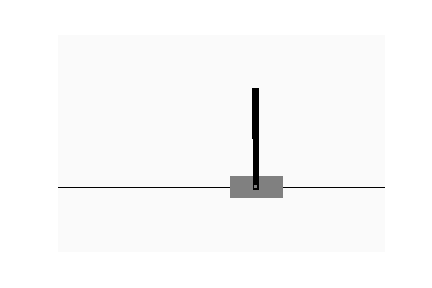
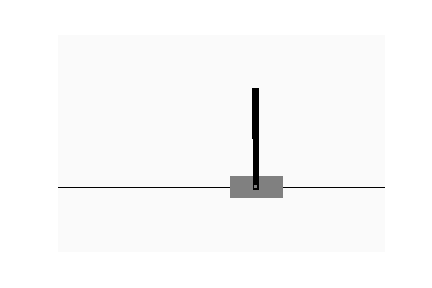
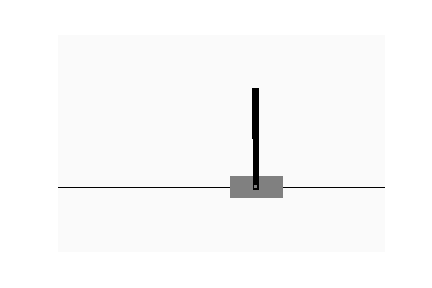
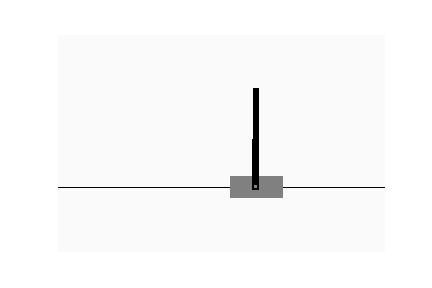
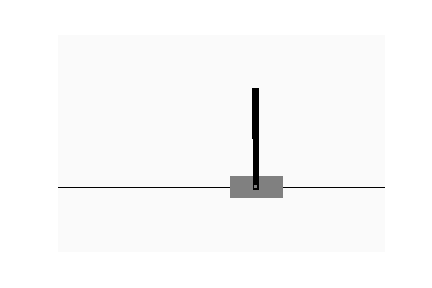
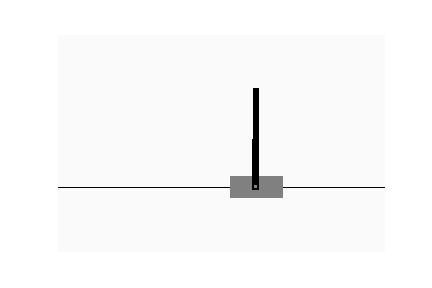
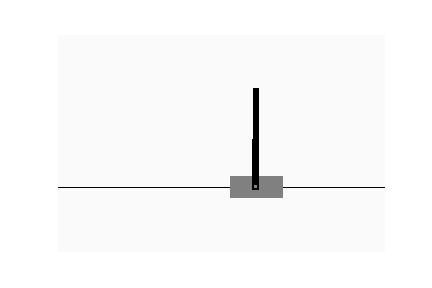
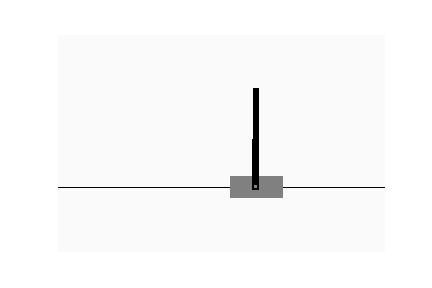
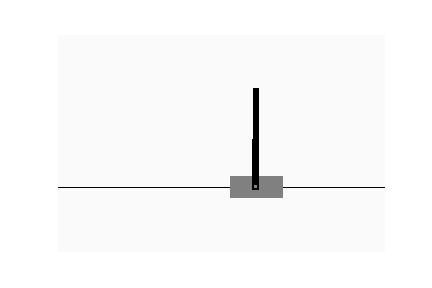
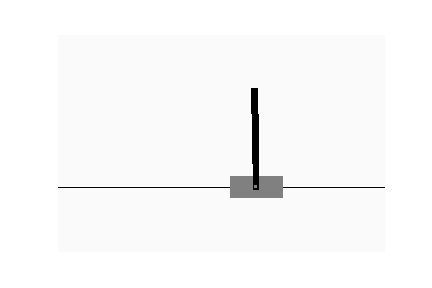
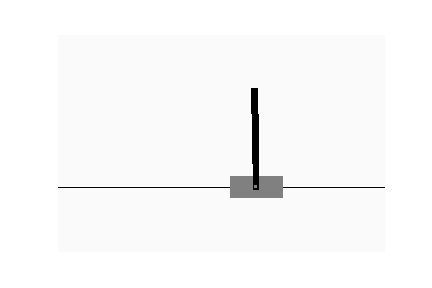
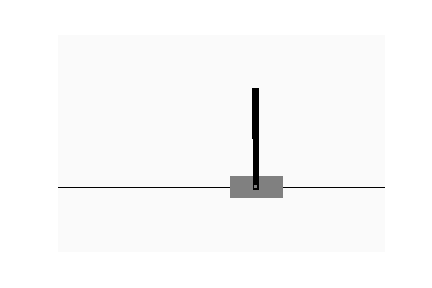
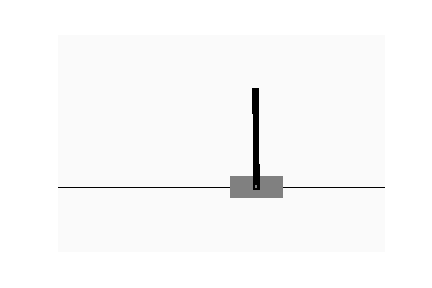
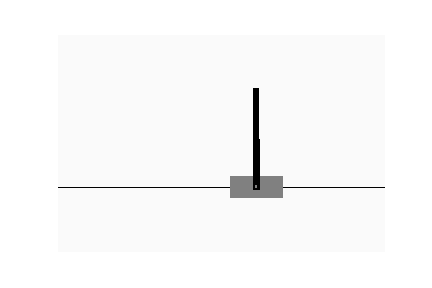
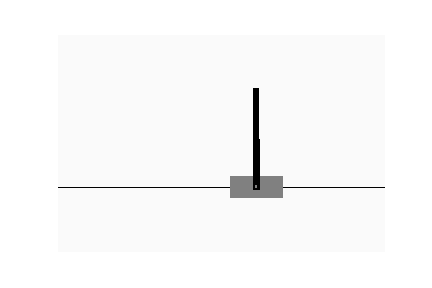
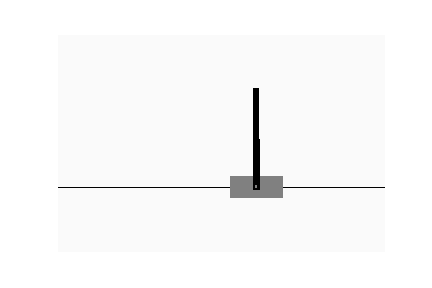
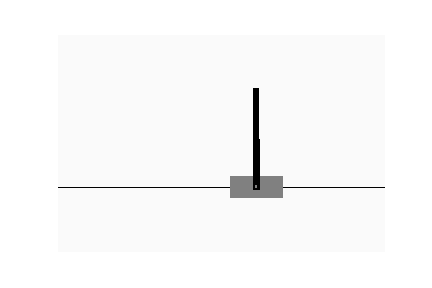
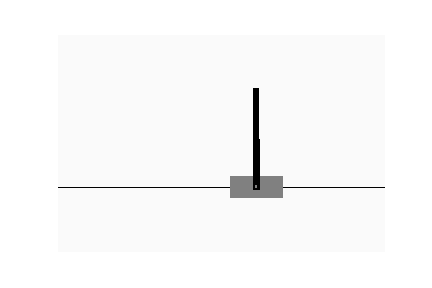
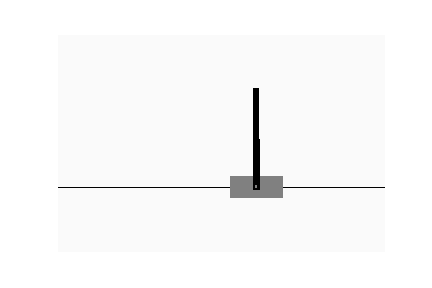
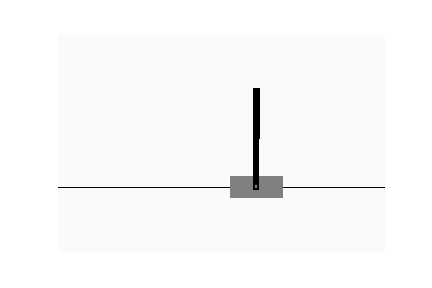
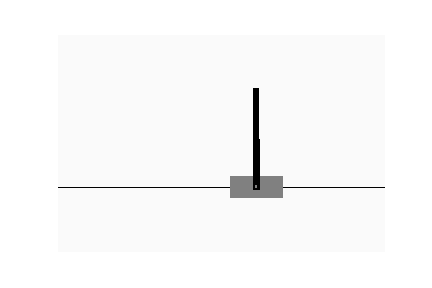
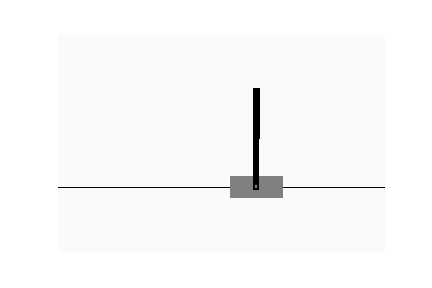
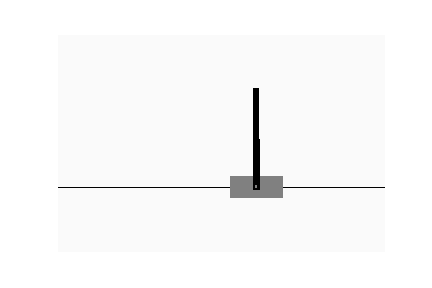
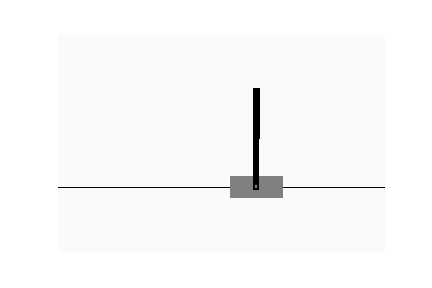
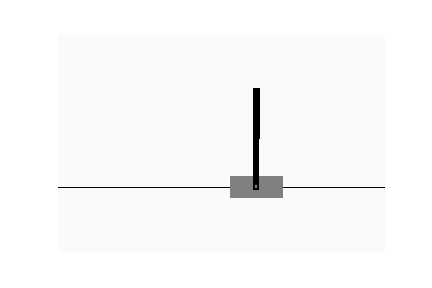
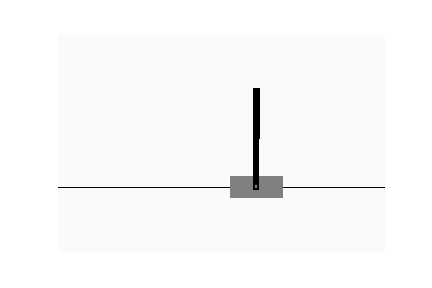
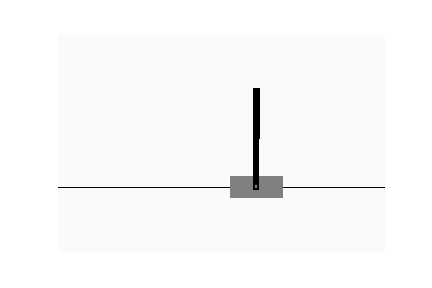
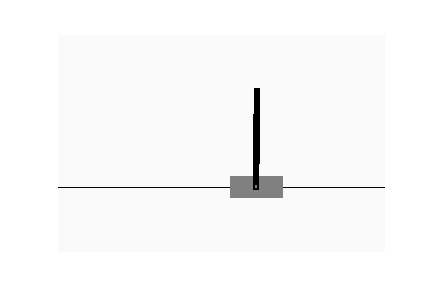
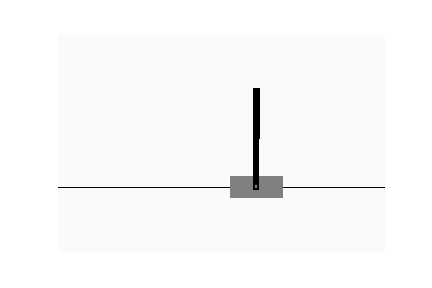
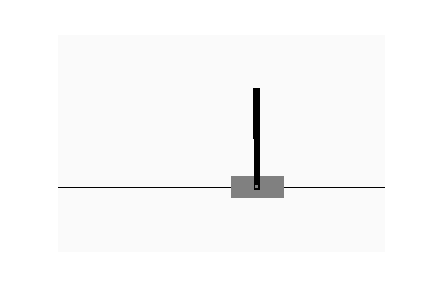
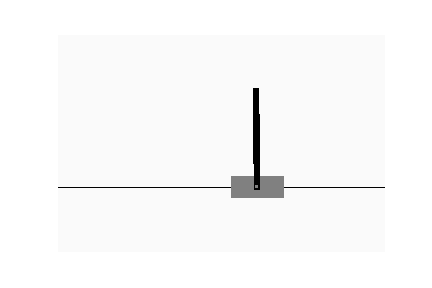
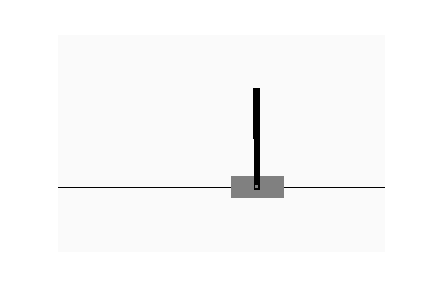
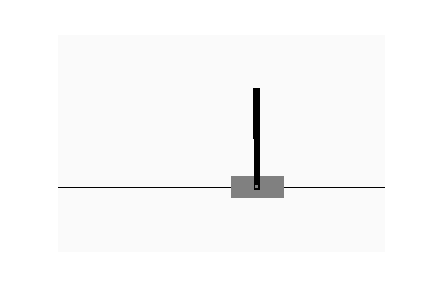
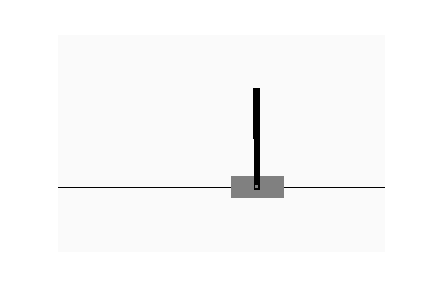
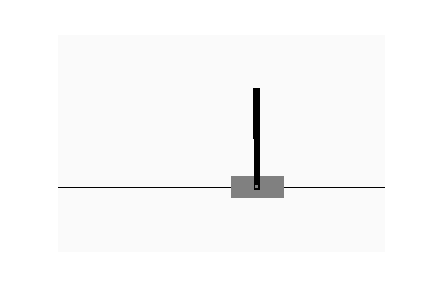
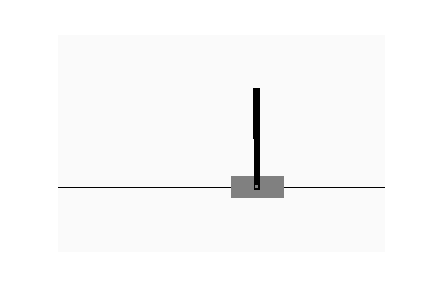
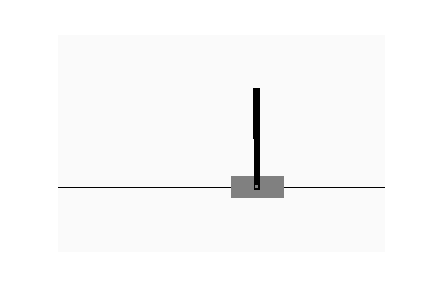
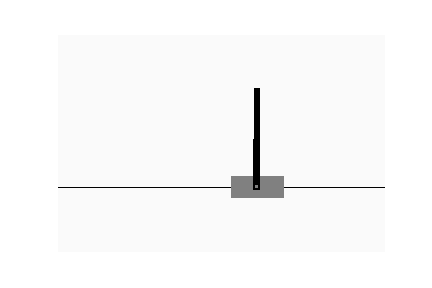
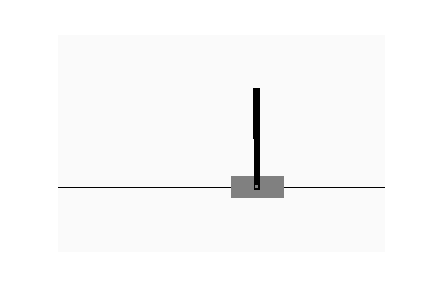
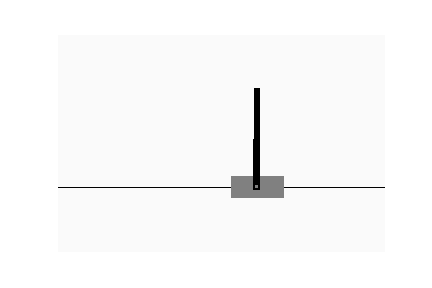
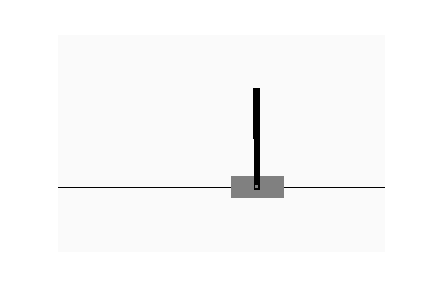
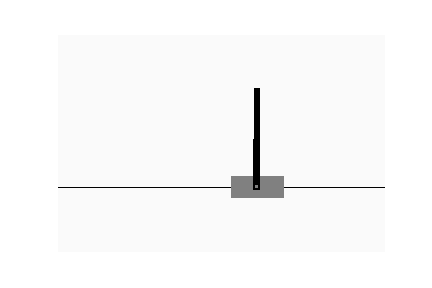
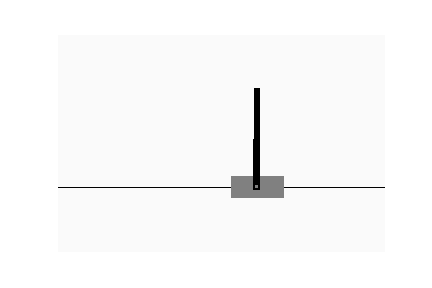
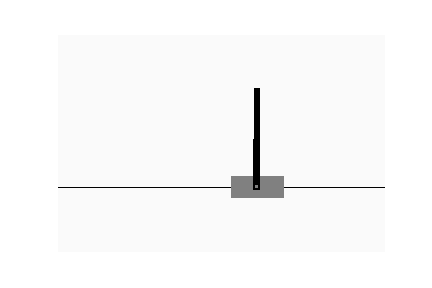
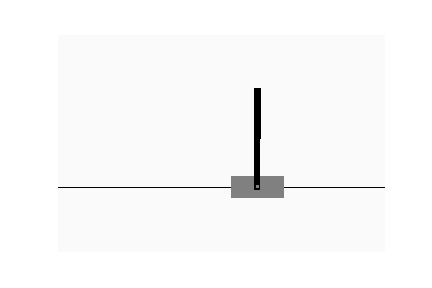
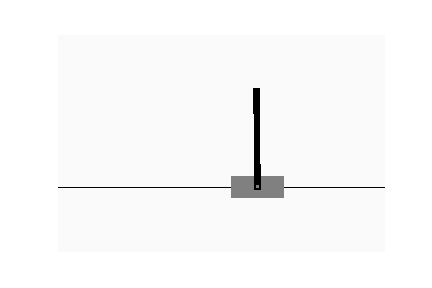
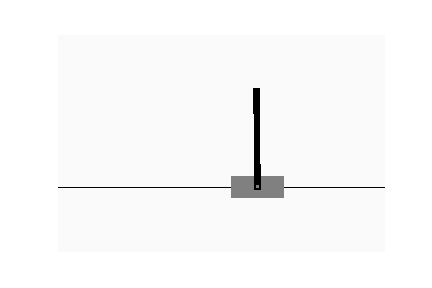
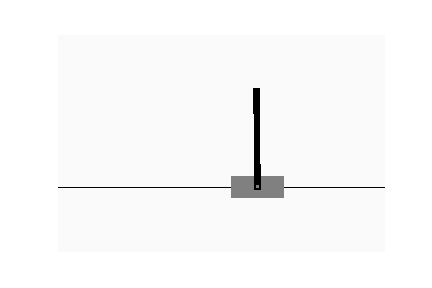
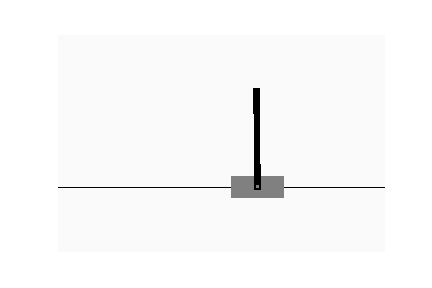
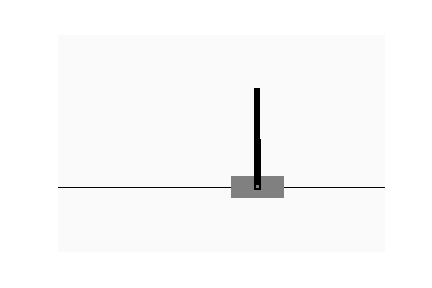
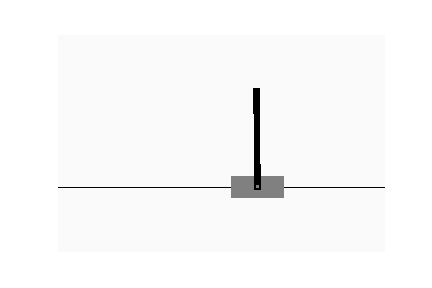
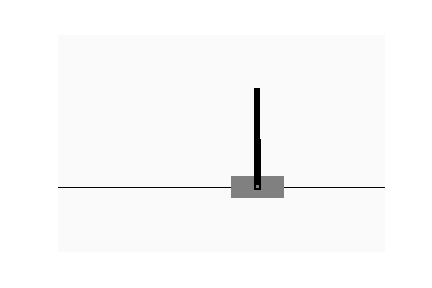
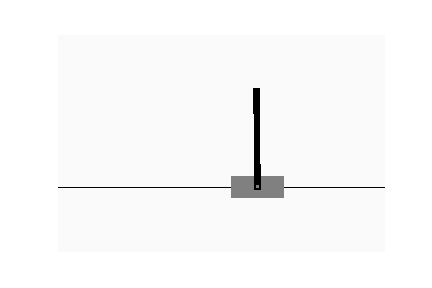
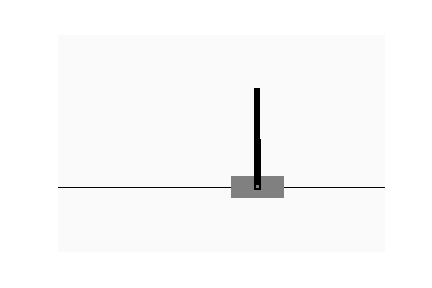
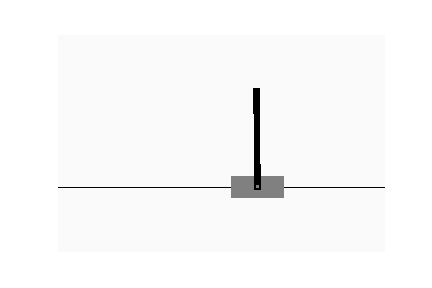
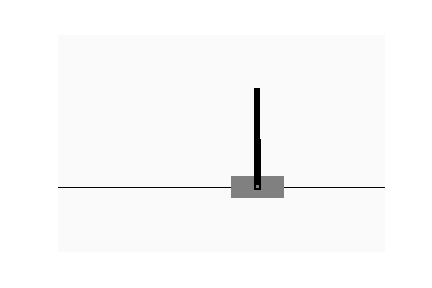
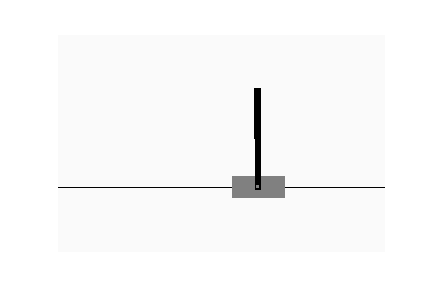
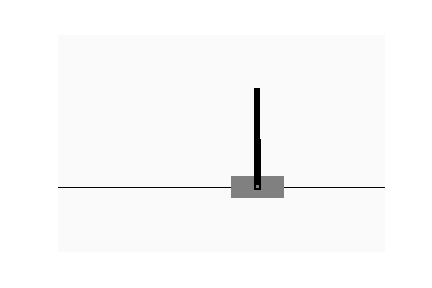
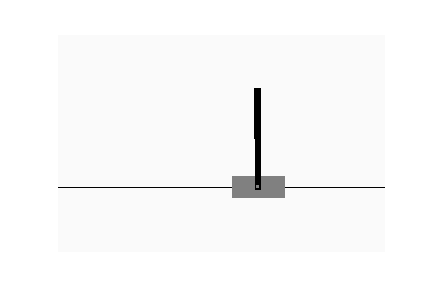
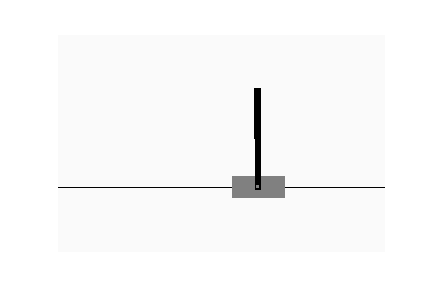
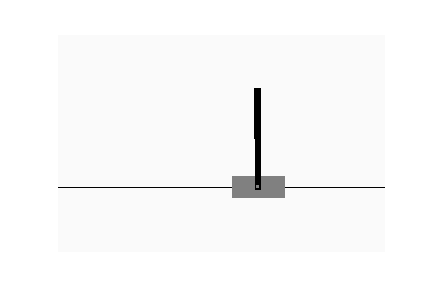
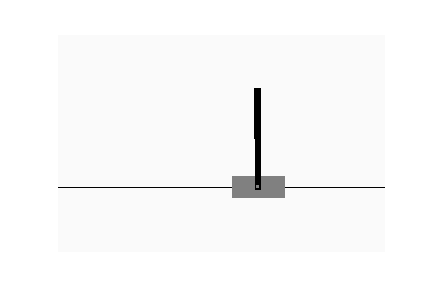
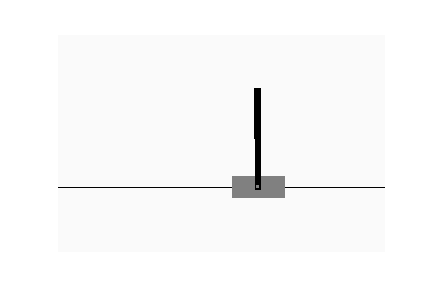
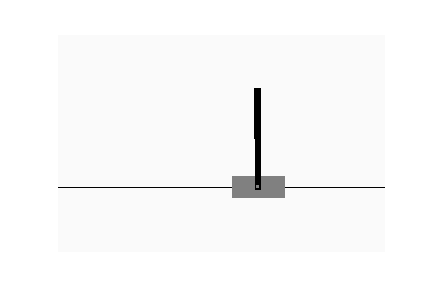
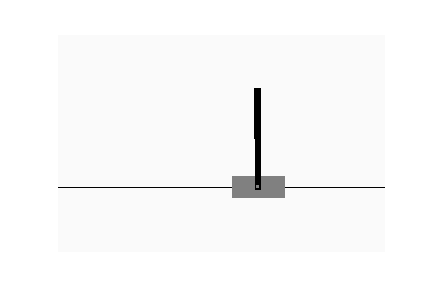
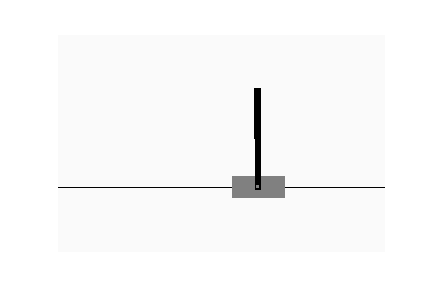
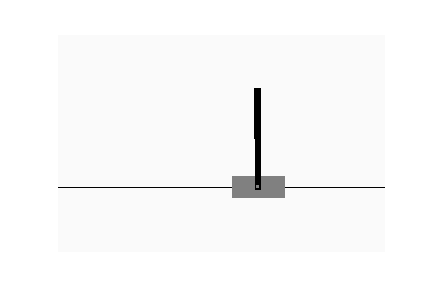
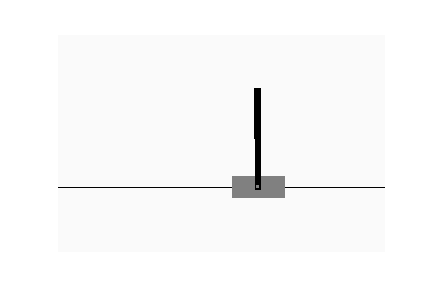
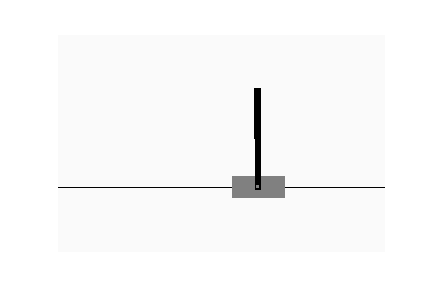
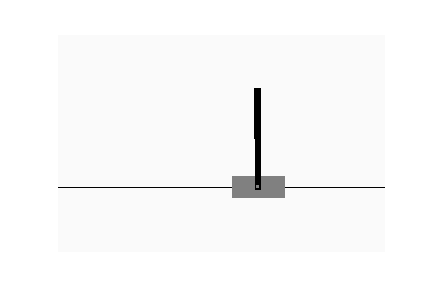
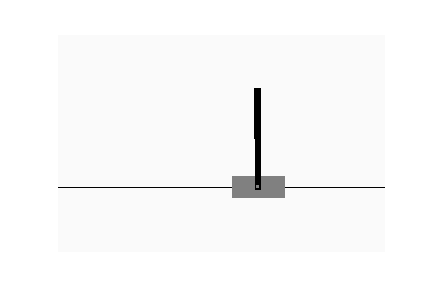
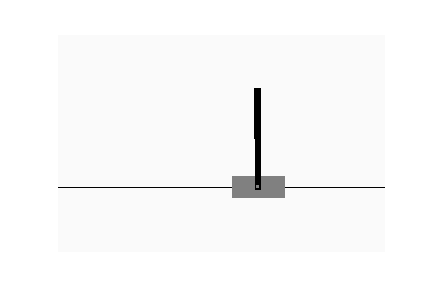
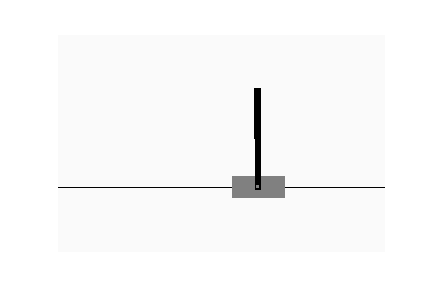
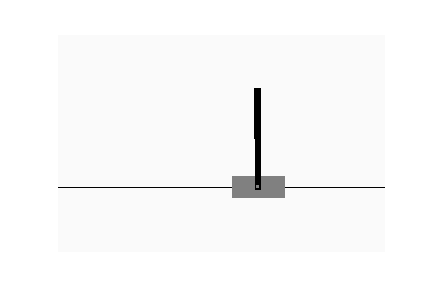
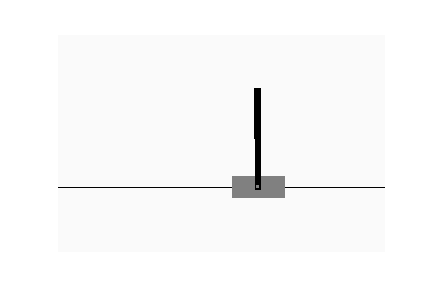
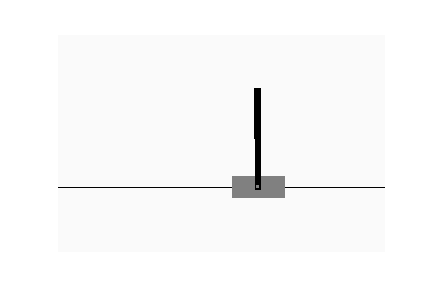
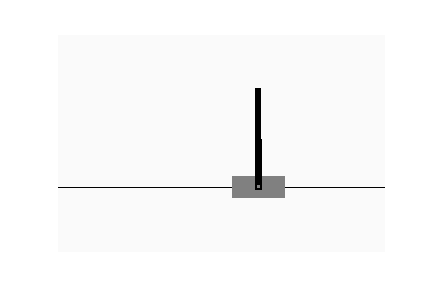
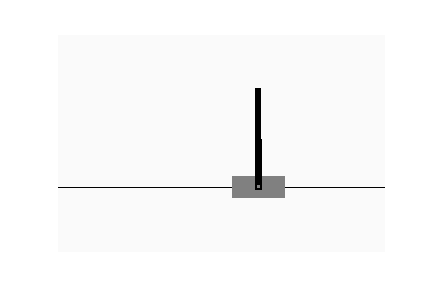
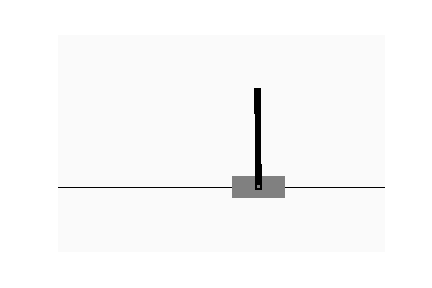
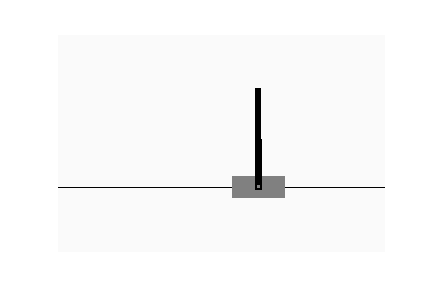
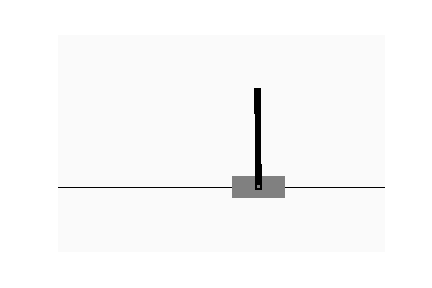
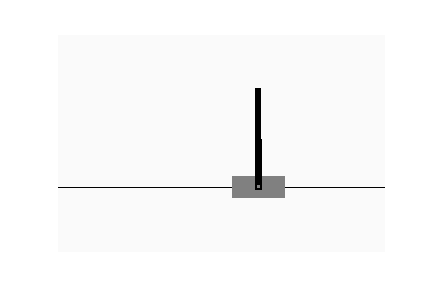
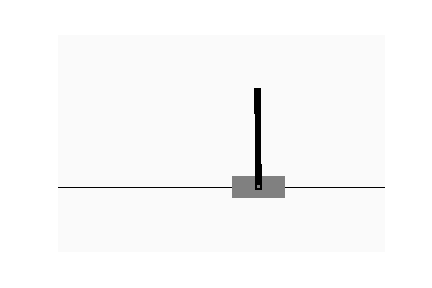
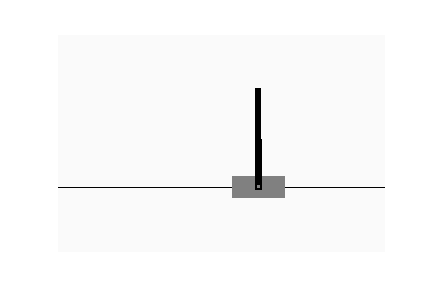
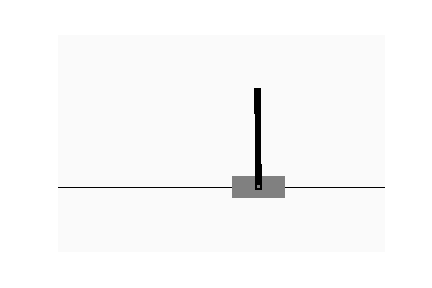
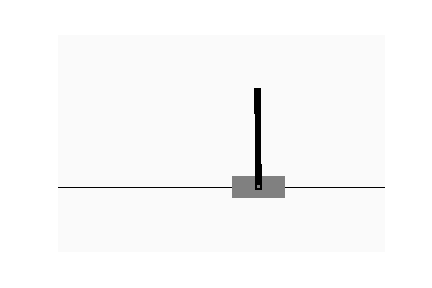
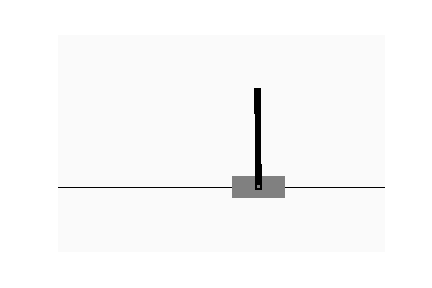
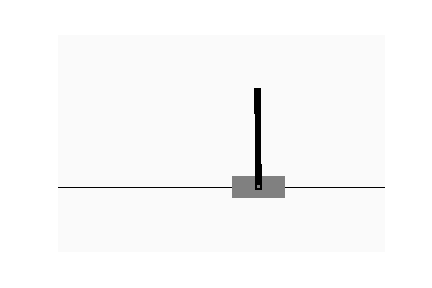
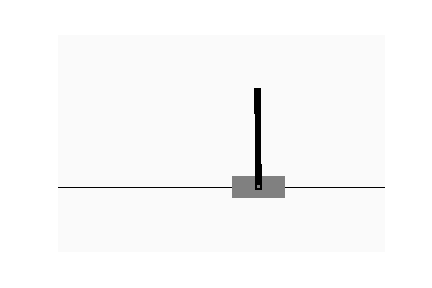
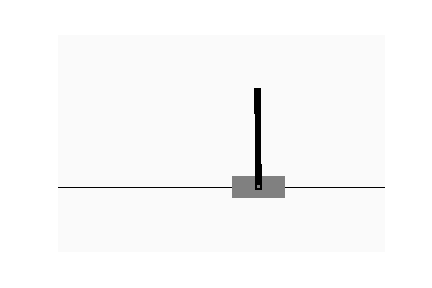
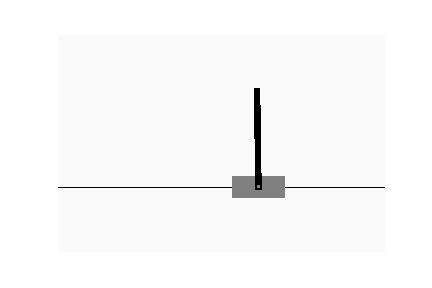
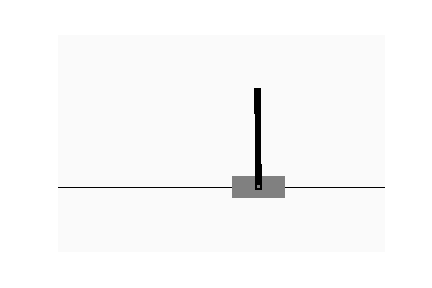
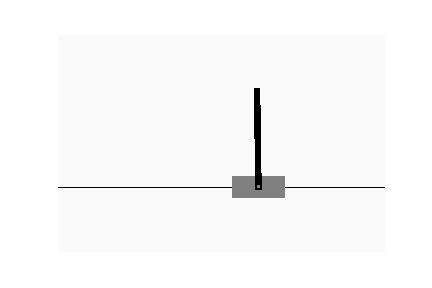
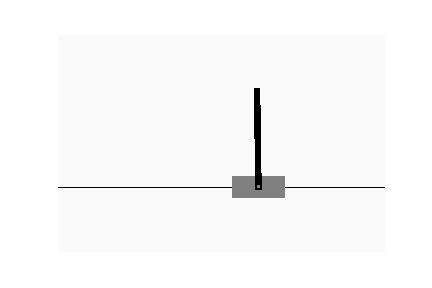
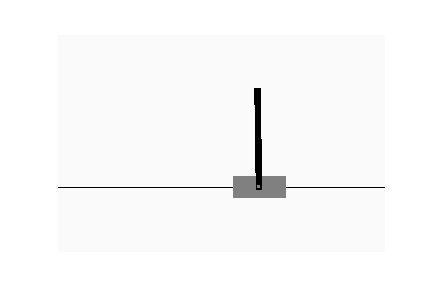
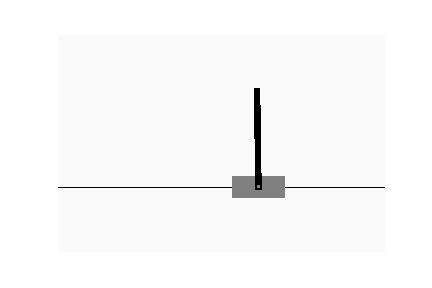
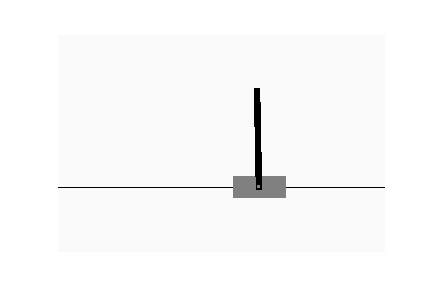
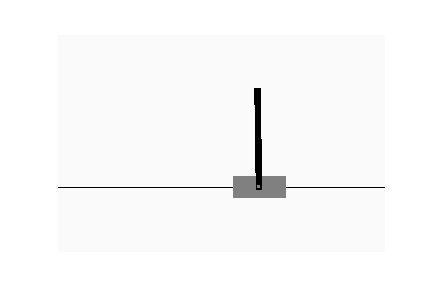
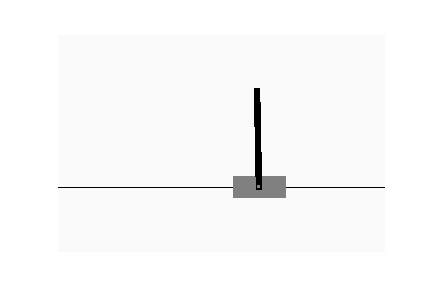
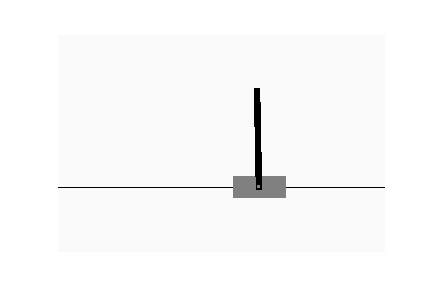
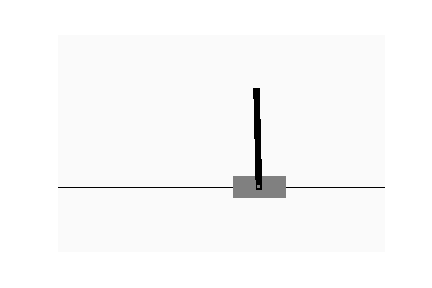
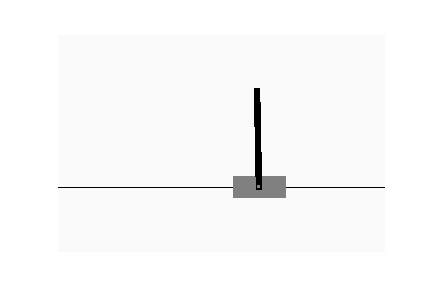
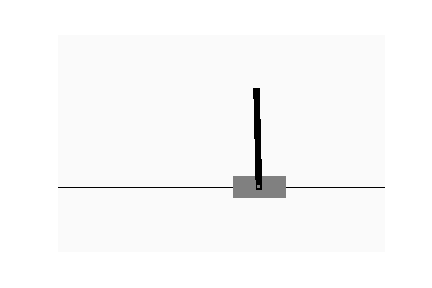
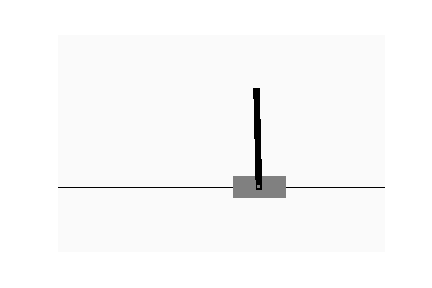
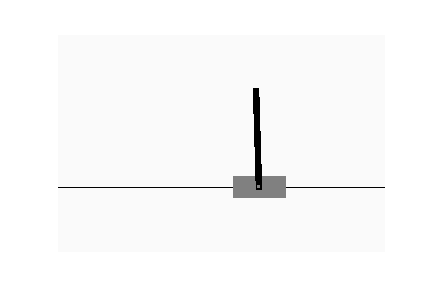
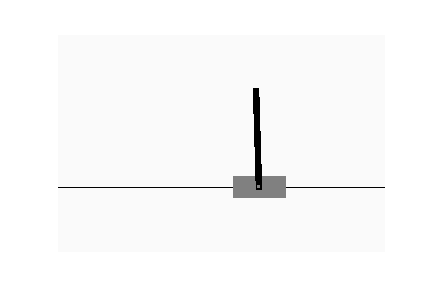
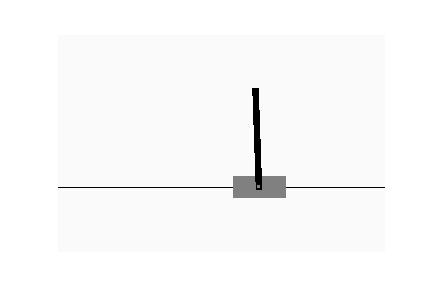
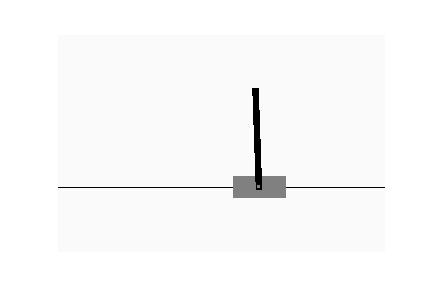
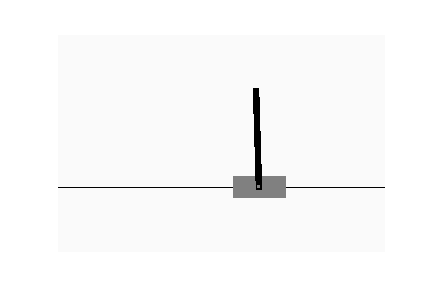
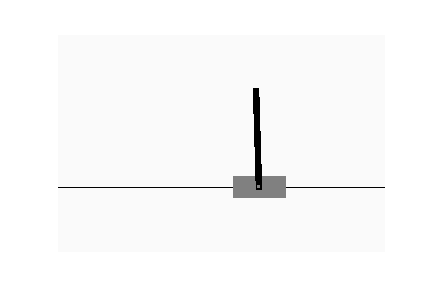
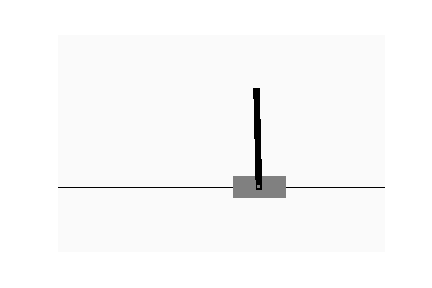
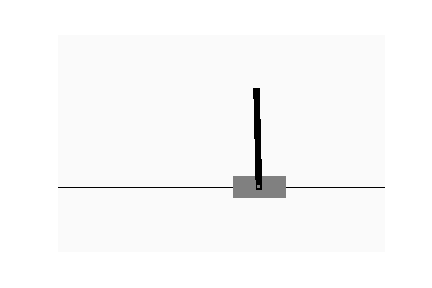
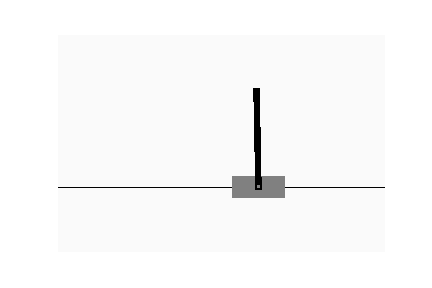
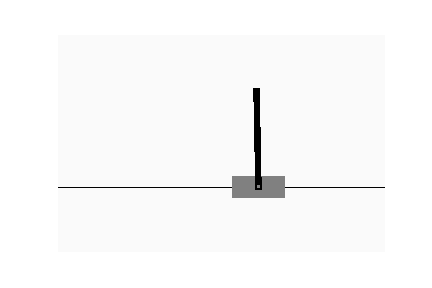
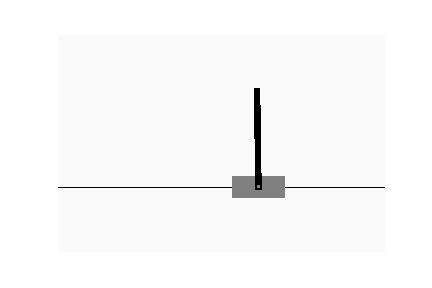
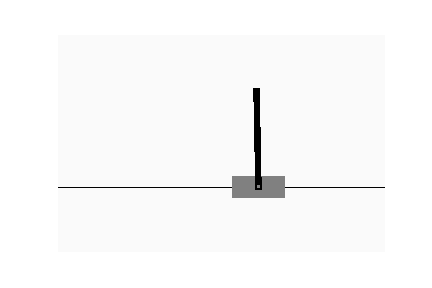
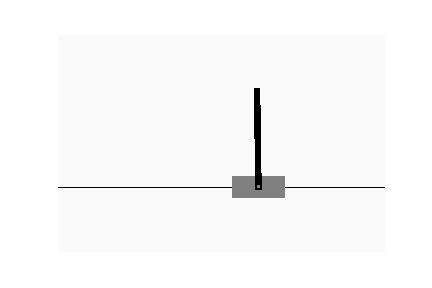
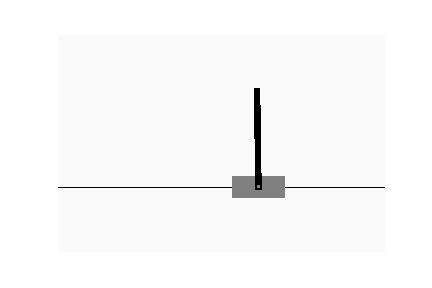
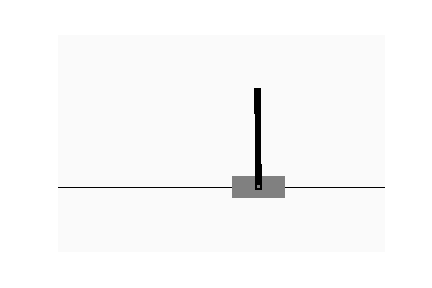
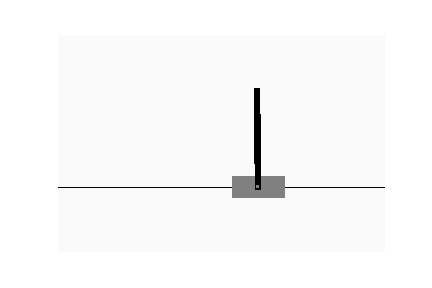
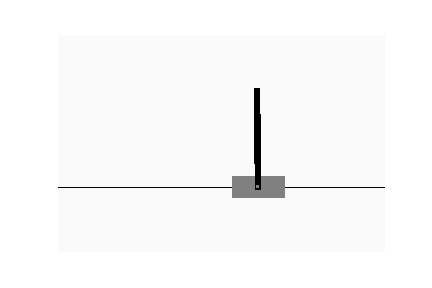
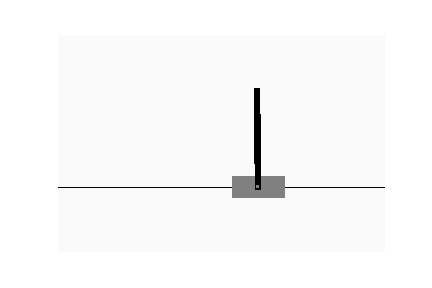
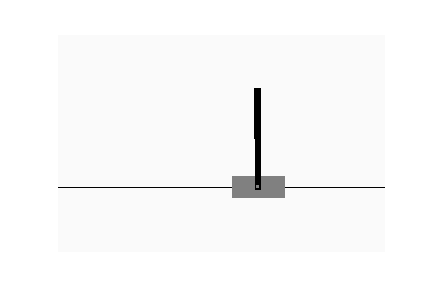
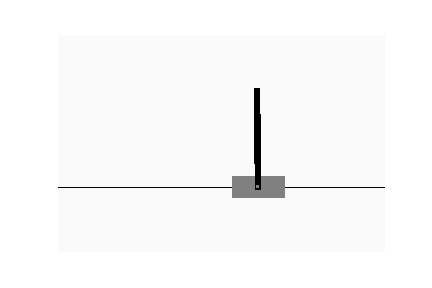
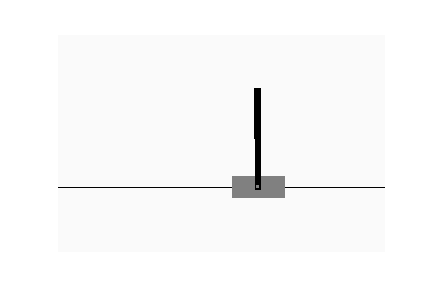
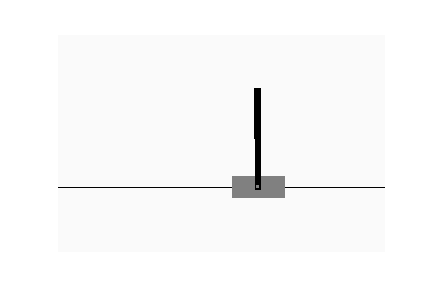
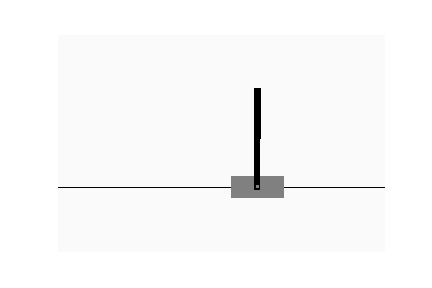
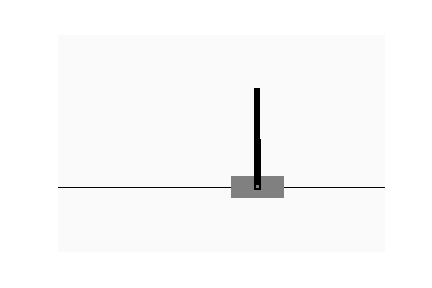
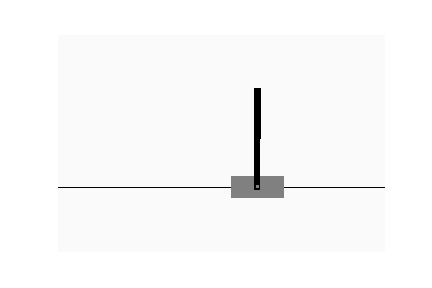
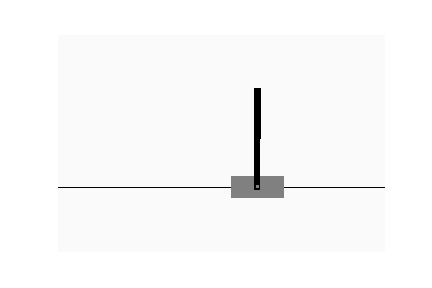
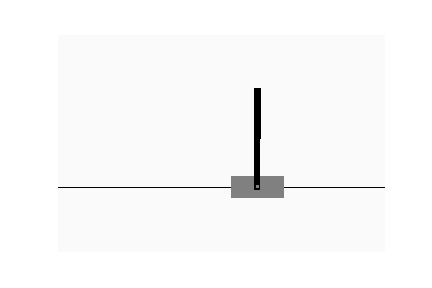
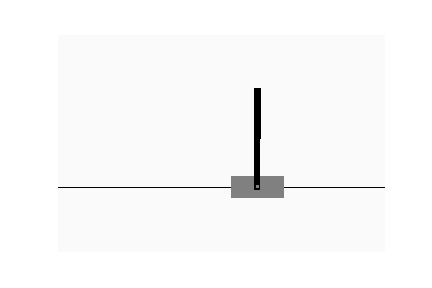
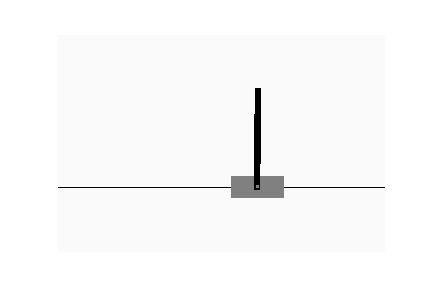
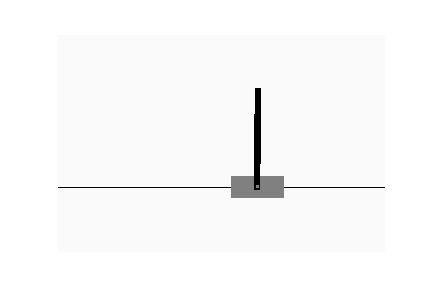
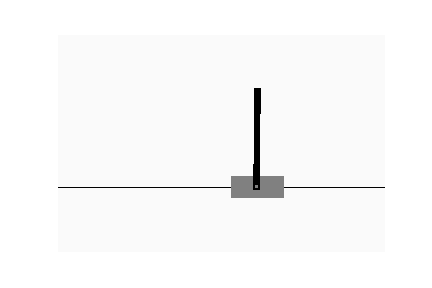
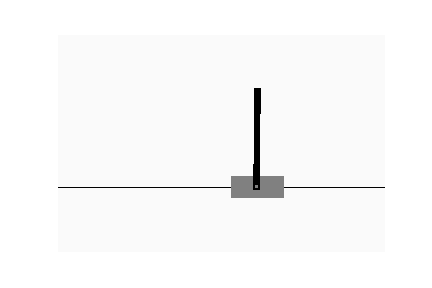
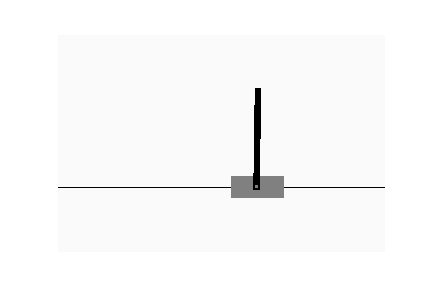
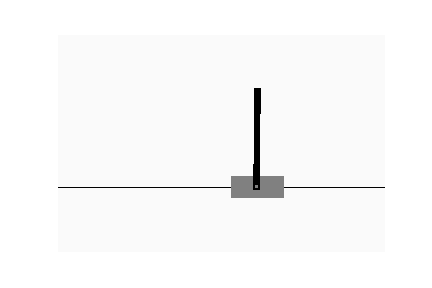
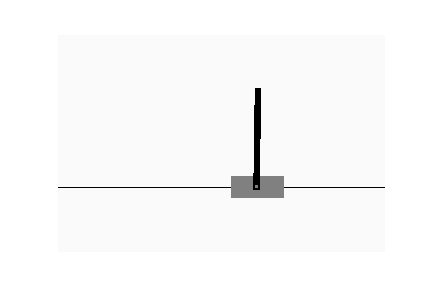
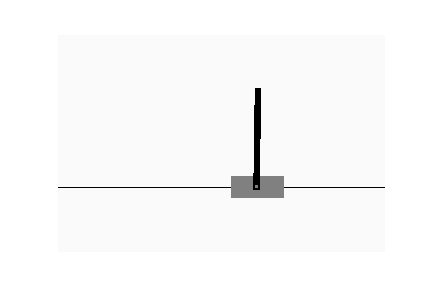
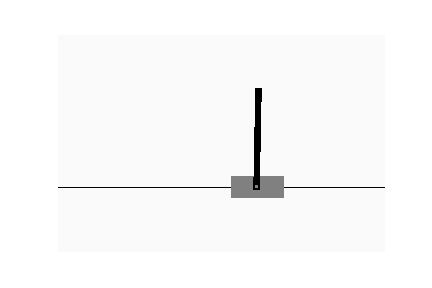
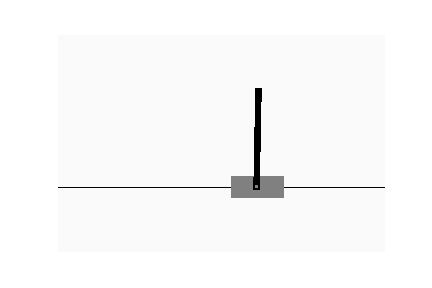
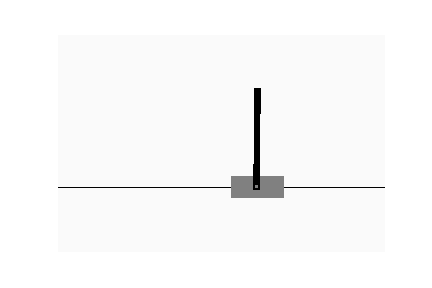
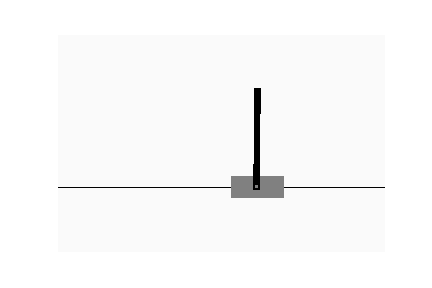
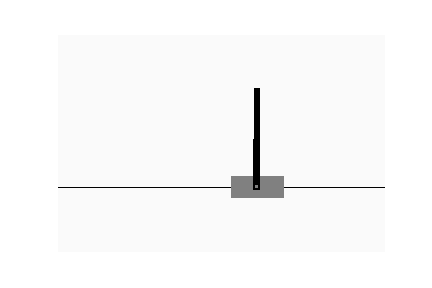
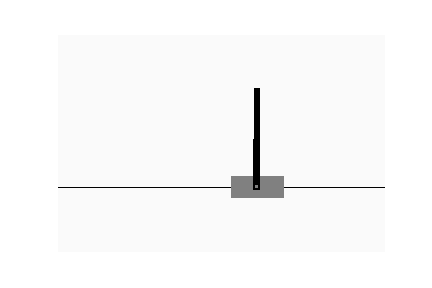
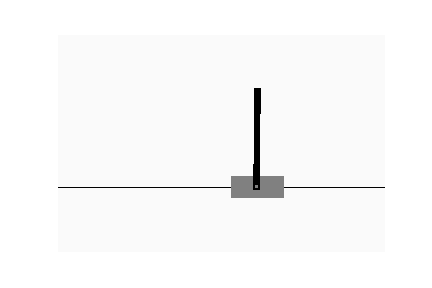
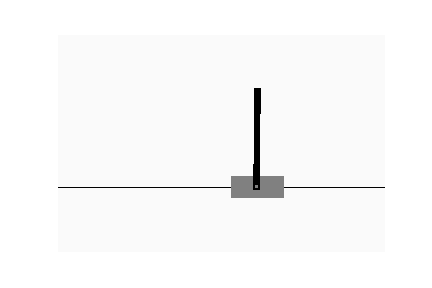
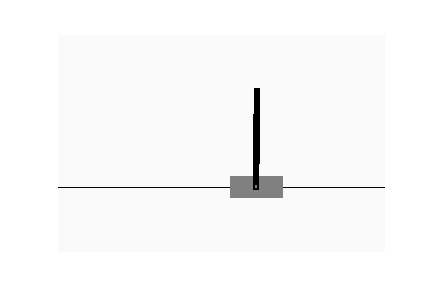
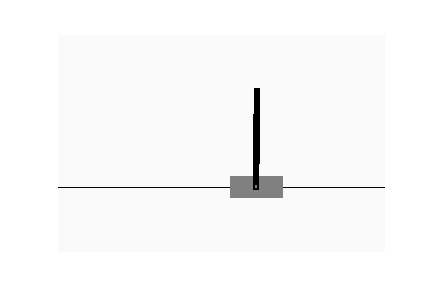
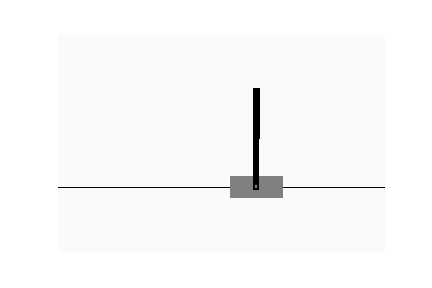
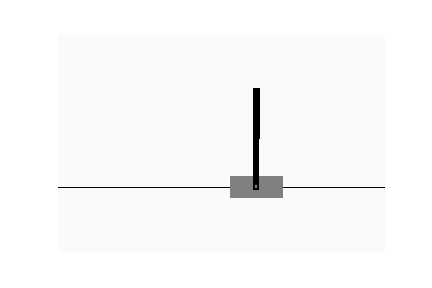
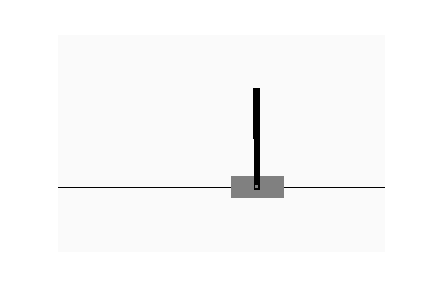
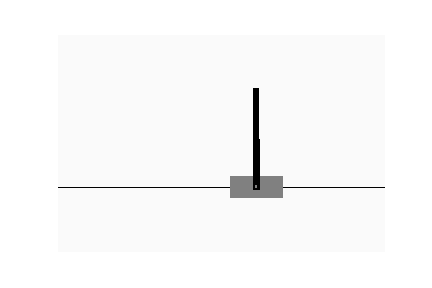
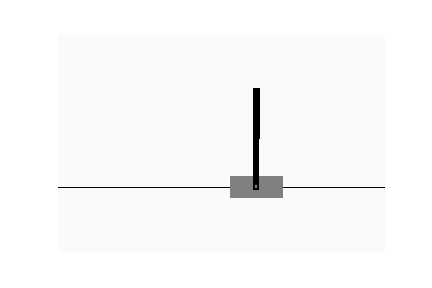
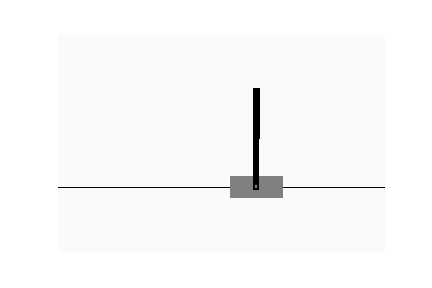
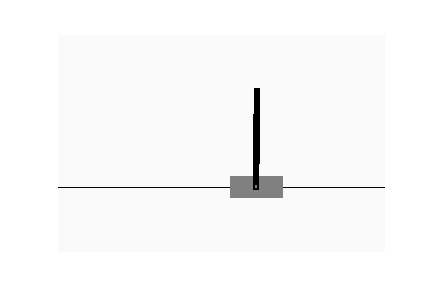
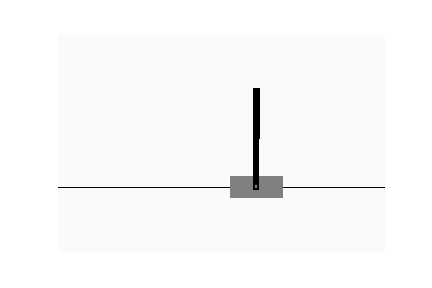
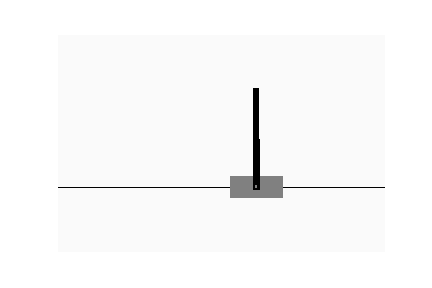
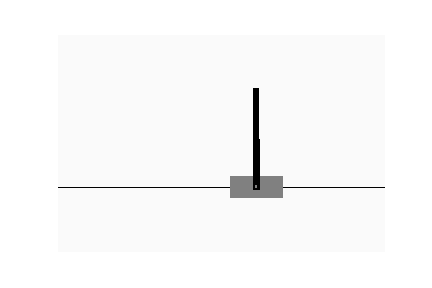
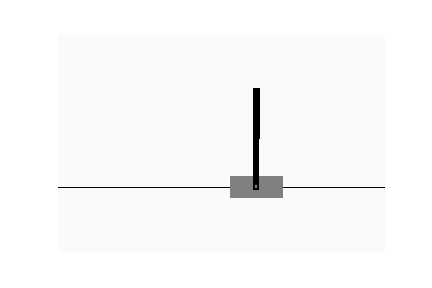
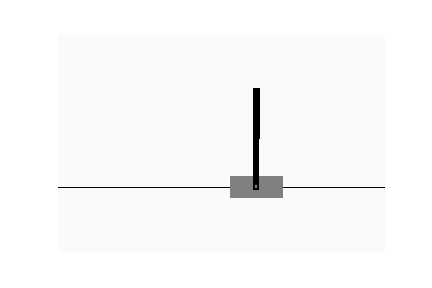
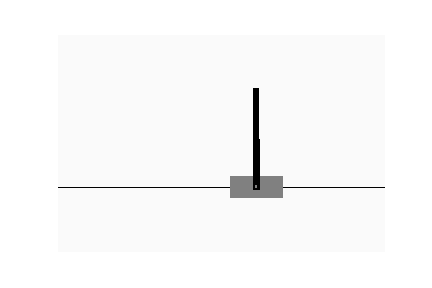
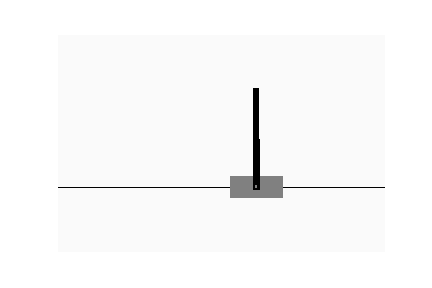
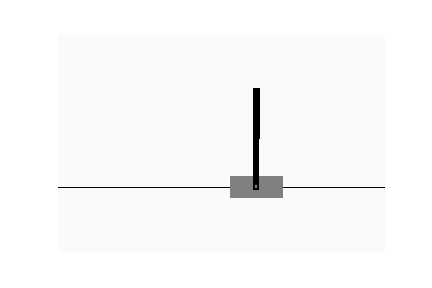
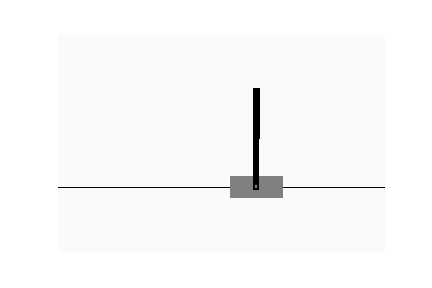
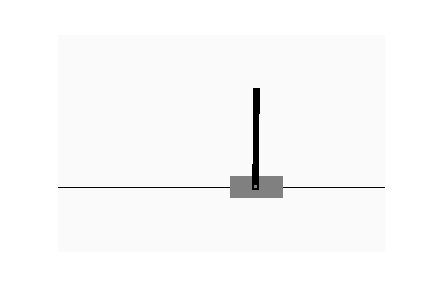
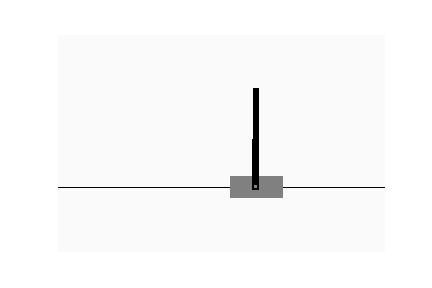
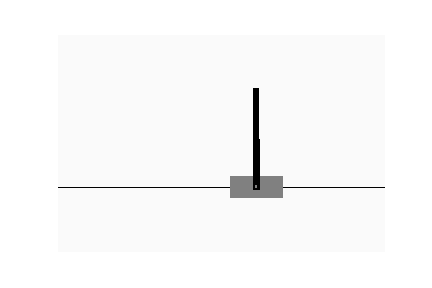
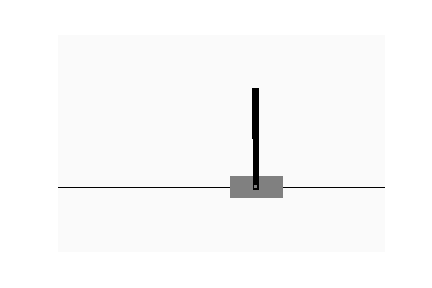
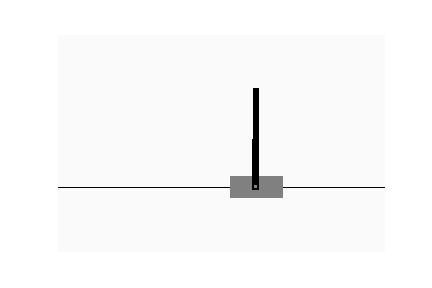
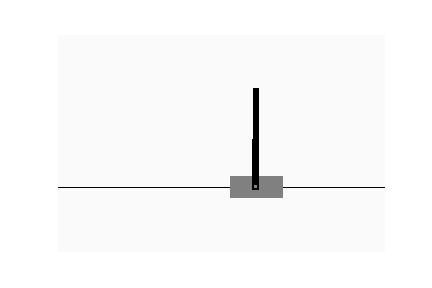
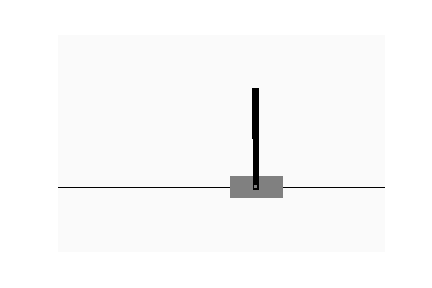
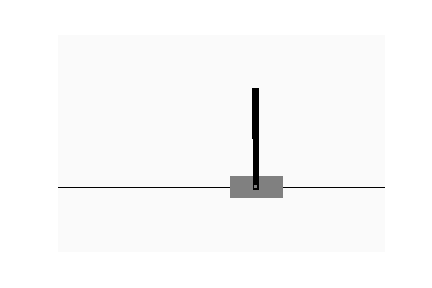
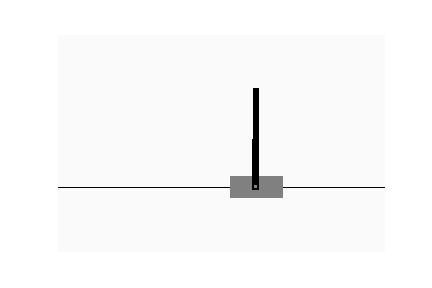
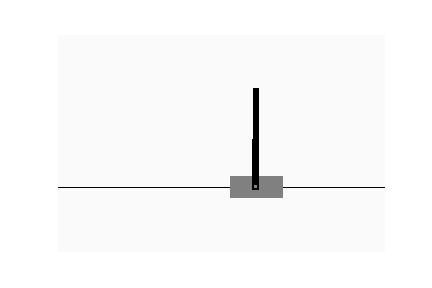
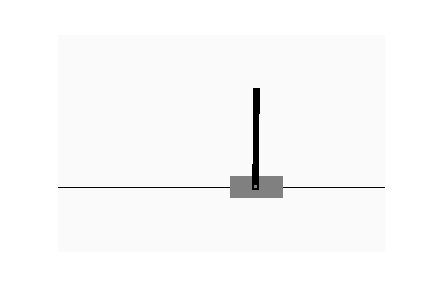
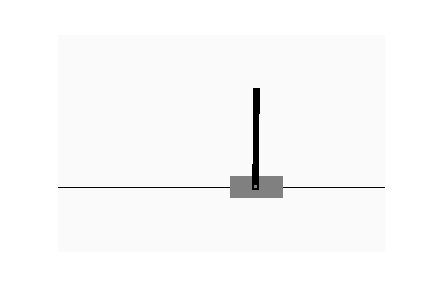
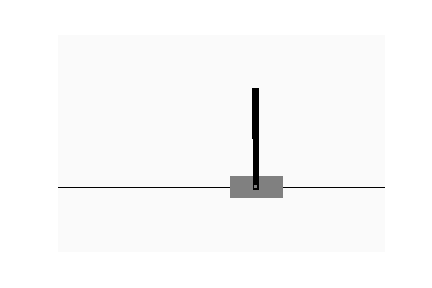
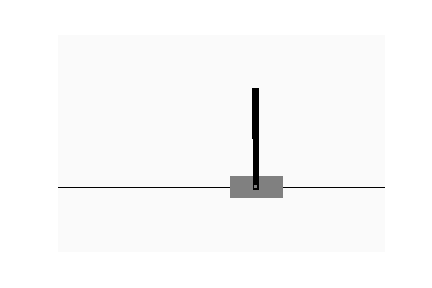
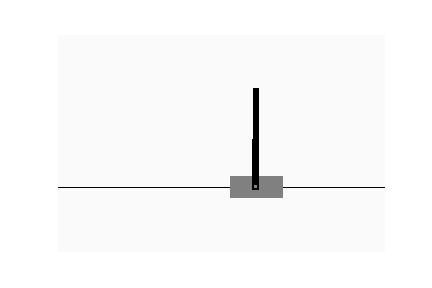
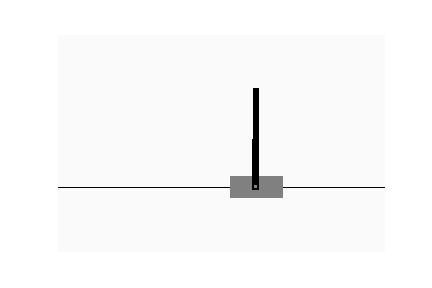
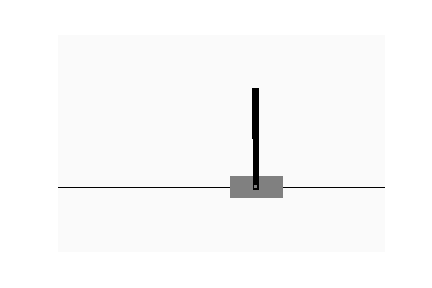
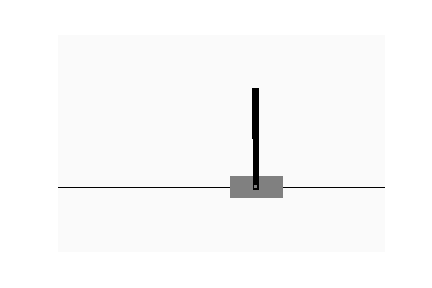
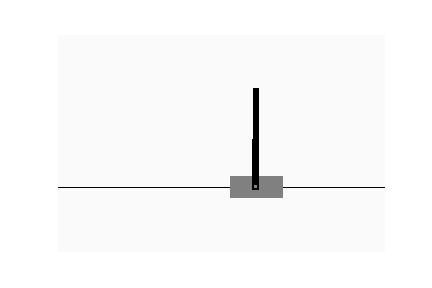
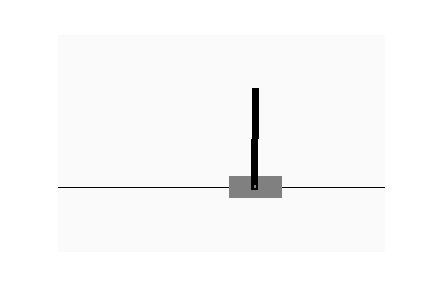
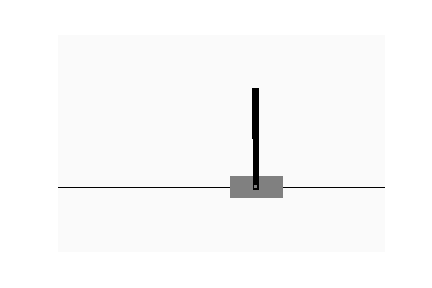
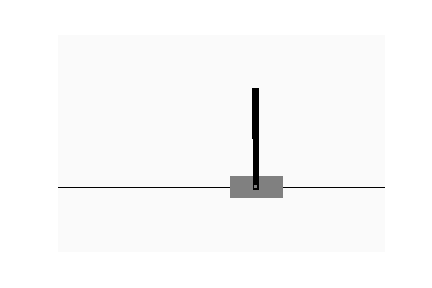
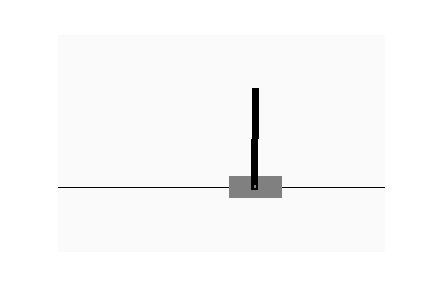
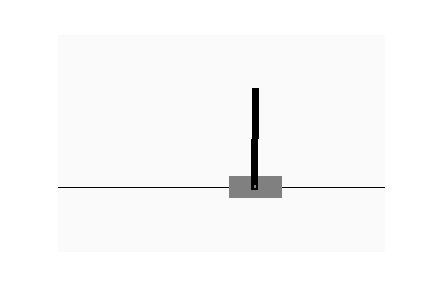
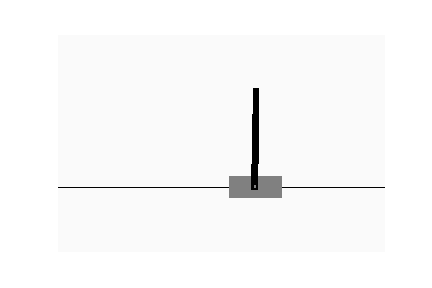
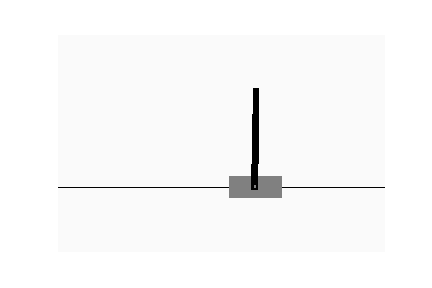
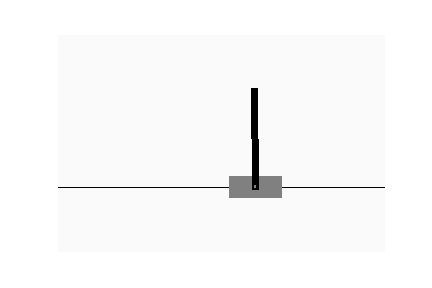
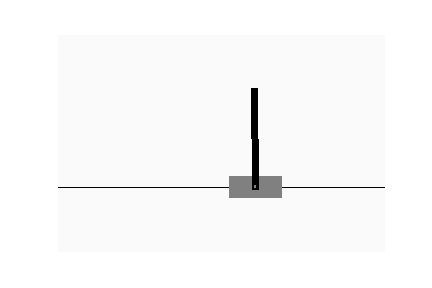
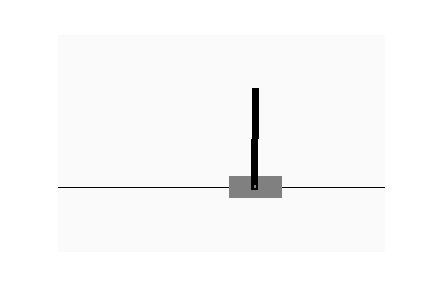
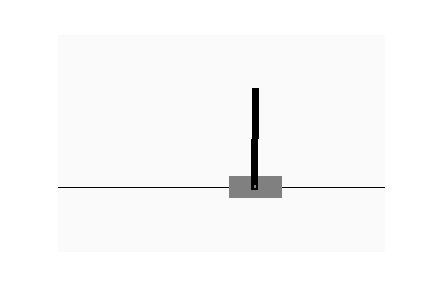
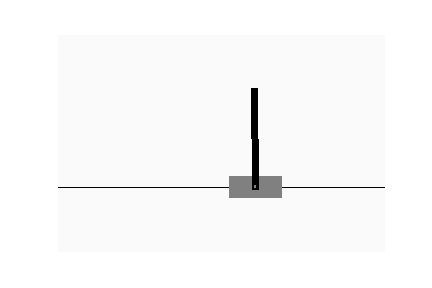
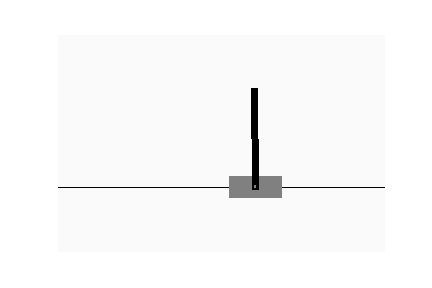
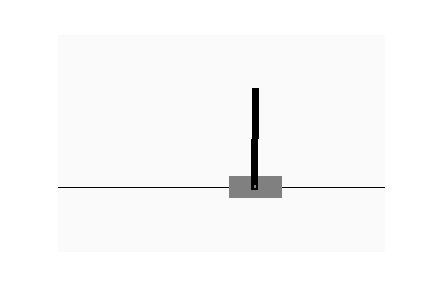
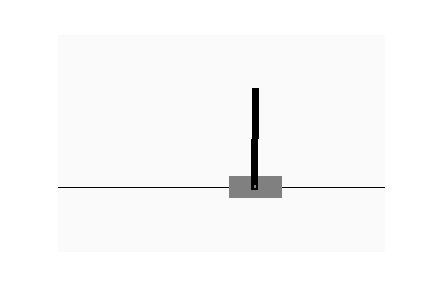
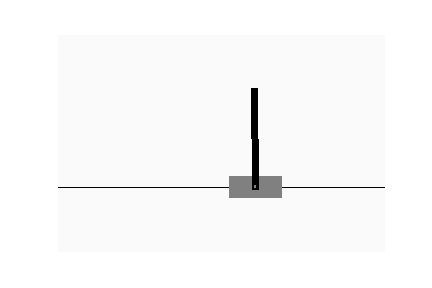
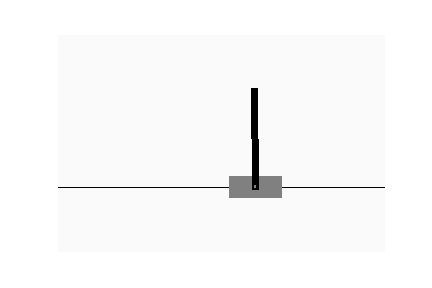
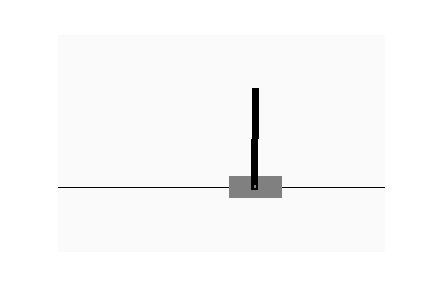
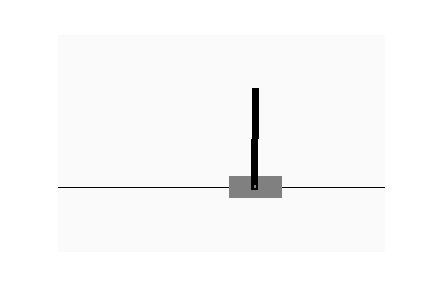
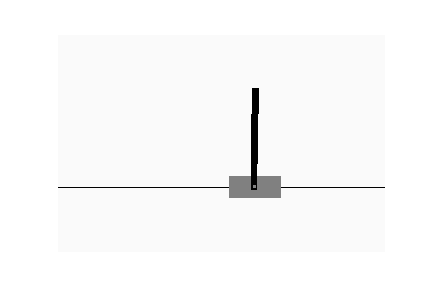
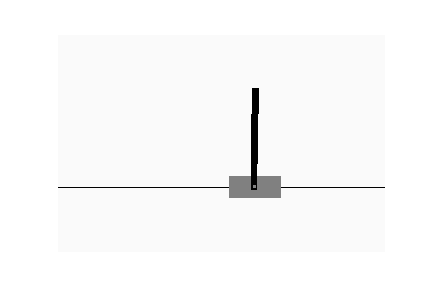
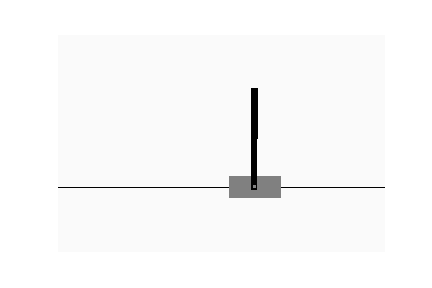
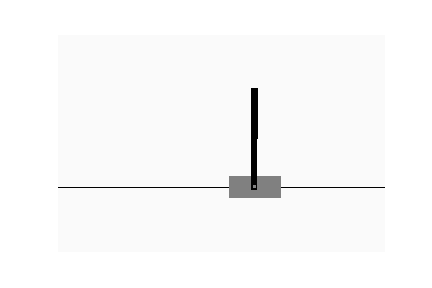
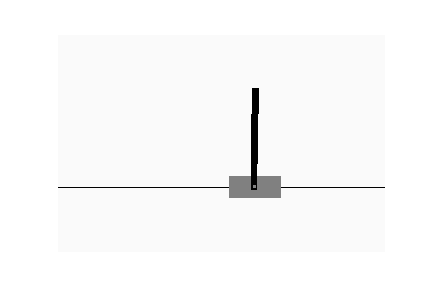
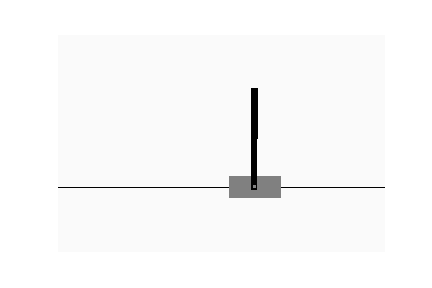
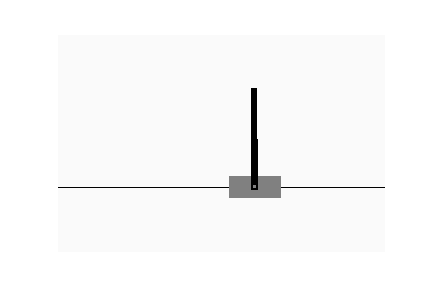
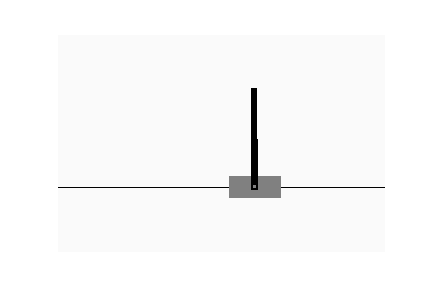
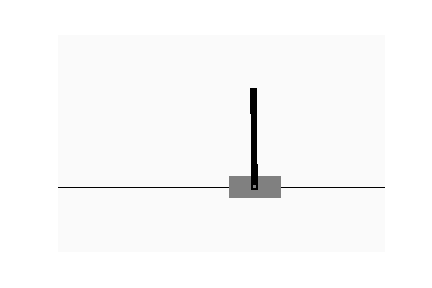
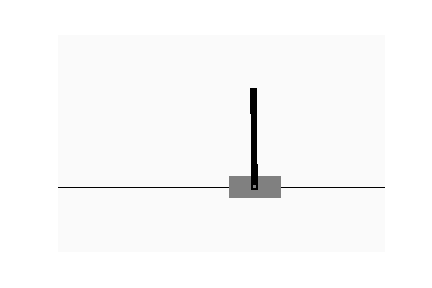
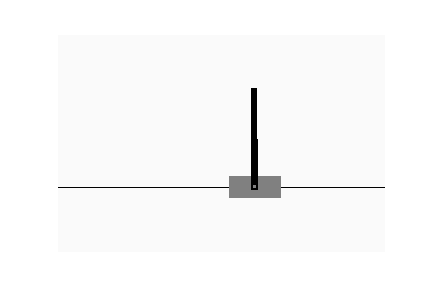
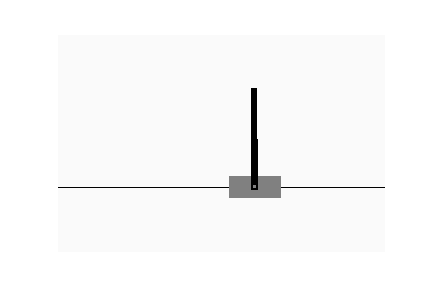
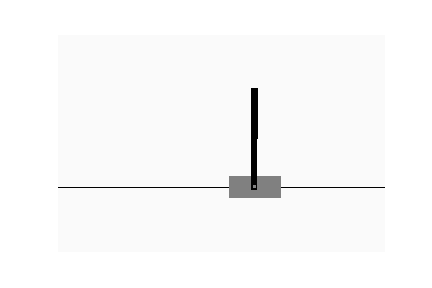
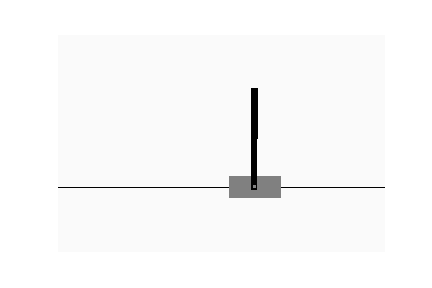
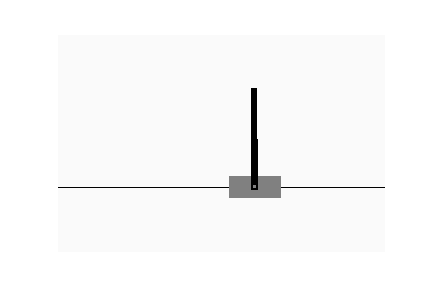
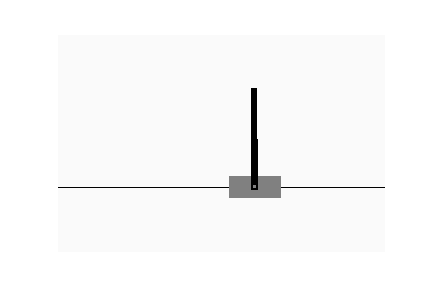
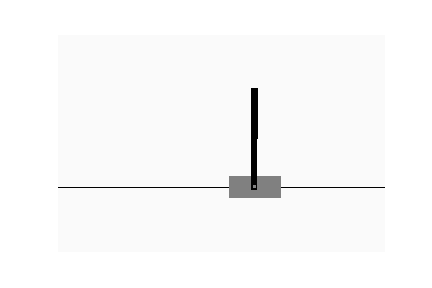
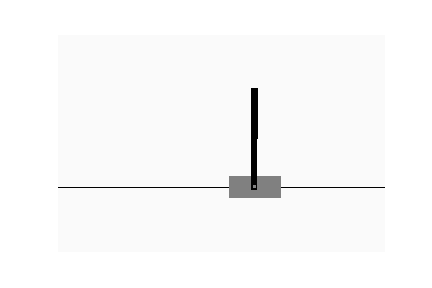
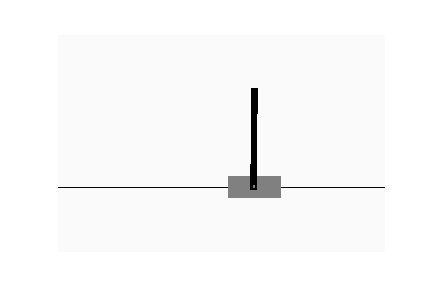
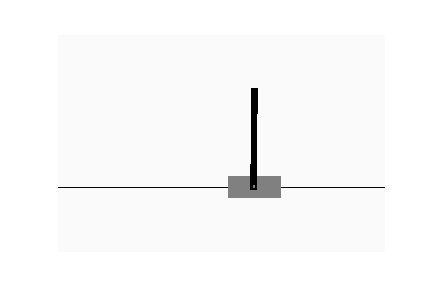
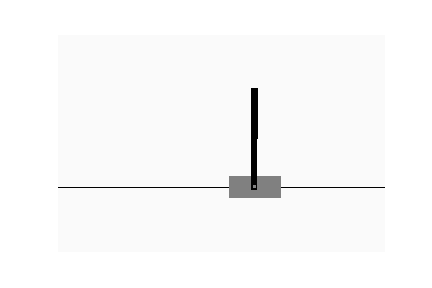
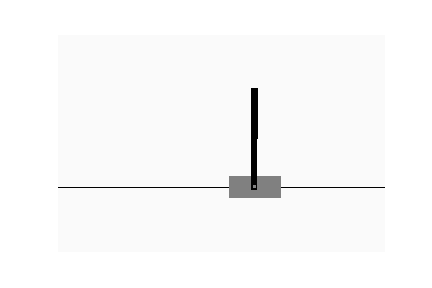
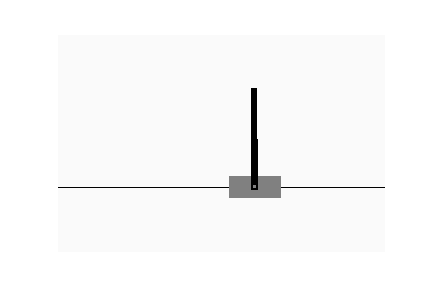
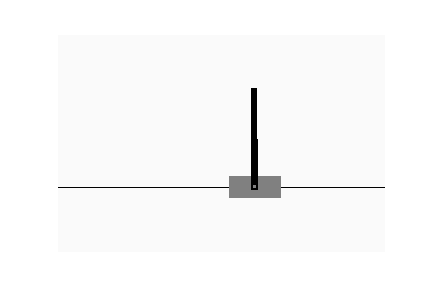
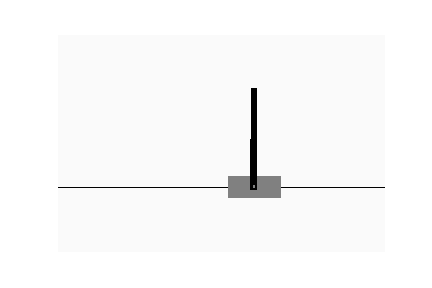
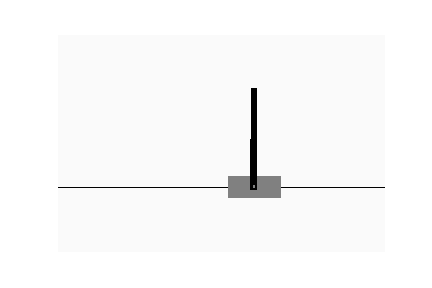
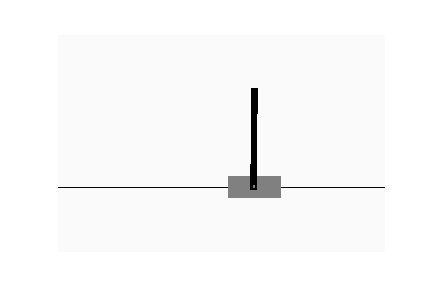
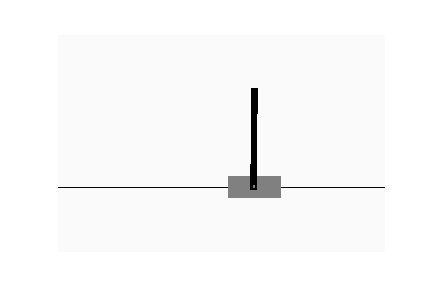

In [57]:
# review solution
s = env.reset()
view = Viewer(env, custom_render=True)
for _ in range(500):
    view.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
view.render(close=True, display_gif=True)

## Exercises

Now it is your turn! Play around the code above and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* number of hidden layers and units


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

More episodes gave better results, but tweaking the learning rate made me able to achieve max score at only 400 episodes.
An extra layer didnt make any difference.

We tried tweaking the discount factor, and found that a little higher discount factor gave a more stable animation, and higher reward, with only around 800

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*[Hint: See introdution notebook.]*

**Answer:**

*A*  
5

*B*  
5,5,4,3,2,2,1,0,0,0

*C*
- $R(t=0) = 0 + 0.9 * 1 + 0.9^2 * 1 + 0.9^3 * 1 + 0.9^4 * 0 + 0.9^5 * 1 + 0.9^6 * 1 + 0.9^7 * 0 + 0.9^8 * 0 + 0.9^9 * 0 = 3.560931$
- $R(t=1) = 1 + 0.9 * 1 + 0.9^2 * 1 + 0.9^3 * 0 + 0.9^4 * 1 + 0.9^5 * 1 + 0.9^6 * 0 + 0.9^7 * 0 + 0.9^8 * 0 = 3.95659$
- $R(t=2) = 1 + 0.9 * 1 + 0.9^2 * 0 + 0.9^3 * 1 + 0.9^4 * 1 + 0.9^5 * 0 + 0.9^6 * 0 + 0.9^7 * 0 = 3.2851$
- $R(t=3) = 1 + 0.9 * 0 + 0.9^2 * 1 + 0.9^3 * 1 + 0.9^4 * 0 + 0.9^5 * 0 + 0.9^6 * 0 = 2.359$
- $R(t=4) = 0 + 0.9 * 1 + 0.9^2 * 1 + 0.9^3 * 0 + 0.9^4 * 0 + 0.9^5 * 0 = 1.71$
- $R(t=5) = 1 + 0.9 * 1 + 0.9^2 * 0 + 0.9^3 * 0 + 0.9^4 * 0 = 1.9$
- $R(t=6) = 1 + 0.9 * 0 + 0.9^2 * 0 + 0.9^3 * 0 = 1$
- $R(t=7) = 0 + 0.9 * 0 + 0.9^2 * 0 = 0$
- $R(t=8) = 0 + 0.9 * 0 = 0$
- $R(t=9) = 0 = 0$ 

### Exercise 3

*You will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross. How can you explain this behavior?*

*[Hint: Do we use the policy network in the same way during training and validation?]*

**Answer:**

This does not seem to be the case when we ran the notebook

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma (see the introduction notebook for definition)?*

**Answer:**

Using the disount factor, the neural network is primed to look at a seires of actions and see the rewards all together.    
This makes the neural network try to maximize its reward by staying in the game for as long as possible.